In [409]:
#!pip install geopy


In [368]:
import numpy as np
import modin.pandas as mpd

In [369]:
#%%time
#data_postcode = pd.read_csv('/Education/property_analysis/data/postcodes/postcodes.csv')


In [370]:
%matplotlib inline
 
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request as req
import json
import numpy as np
import sys
import seaborn as sns
import time
import calendar
import datetime 
import folium  
import os

from geopy.geocoders import Nominatim
from folium.plugins import HeatMap


from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'sans-serif'
rcParams['axes.facecolor'] = '#ffffff'  
rcParams['lines.linewidth'] = 2.0


from IPython.display import HTML
plt.style.use('seaborn-whitegrid')
      

In [371]:
#['IG1','IG2','IG3','IG4','IG5','IG6'] 
#= ['E4','E10','E11','E17']
#= ['NG2','NG5','NG7','NG11','NG8']


In [372]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trimStrings = lambda x: x.strip() if type(x) is str else x
    df_out = df.applymap(trimStrings)
    yield df_out

def set_property_type(df,lookup):
    """
    Translate property type acronyms  
    D: Detached
    S: Semi-detached
    T: Terraced
    F: Flat/maisonette
    O: Other
    """
    df_out = df['property_type'].map(lookup)
    yield df_out

def missig_data(data):
    """
    Return missing data
    """
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def monthly_sales(df):
    """
    Return count of monthly sales
    """
    df_out =  df['date_of_transfer'].str[5:7].astype(int).map(lambda x: calendar.month_abbr[x]).value_counts()
    return df_out

def filter_data(df, from_date, to_date):
    """
    Return data for given dates
    """
    df_out = data[(df['date_of_transfer'] >= from_date) & (df['date_of_transfer'] < to_date)]
    return df_out
    
def remove_null_rows(df, col):
    """
    Drop nulls rows
    """
    out_df = df[df[col].notnull()]
    out_df.reset_index(inplace = True, drop = True)
    yield out_df

def query_latitude_longtitude(area):
    """
    Get latitude and longtitude for a given area
    return tuple
    """
    geolocator = Nominatim(user_agent="PROPPERTY PROJECT")
    city = area
    country = "Uk"
    loc = geolocator.geocode(city+','+ country)
    latitude = loc.latitude
    longtitude = loc.longitude    
    
    return (latitude,longtitude) 

In [373]:
cols = ['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', \
        'property_type', 'old/new','duration','PAON','SAON','Street','Locality', \
        'town/city','district','County','ppd_category_type','record_status_monthly_file_only']

directory = '/Education/property_analysis/data'
property_file = 'ppd_data_Ilford'
postcode_file = 'postcodes'
inflation_file = 'inflation'
suffix = 'csv'
postcode = ['IG1','IG2','IG3','IG4','IG5','IG6']



In [374]:
data_postcode.columns

Index(['postcode', 'In Use?', 'latitude', 'longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'area', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'station_distance', 'Postcode area',
       'Postcode district', 'Police force'],
      dtype='object')

In [375]:
# Load in the land registry data table 

file_path = os.path.join(directory, property_file + "." + suffix)


data = pd.read_csv(file_path,parse_dates=True,usecols=[0,1,2,3,4,9,11],names=cols)

# Exlude O "other" type of property data
data = data.loc[~data['property_type'].isin(['O','F'])]  

data['year'] = pd.DatetimeIndex(data['date_of_transfer']).year
data['month'] = pd.DatetimeIndex(data['date_of_transfer']).month

data['year'] = data['year'].astype(str).astype(int)
data['price'] = data['price'].astype(str).astype(int)
data['outcode'] = data['postcode'].str.split().str[0] 


In [376]:
lookup_type_values = {'D':'Detached','S':'Semi-detached','T':'Terraced','F':'Flat/maisonette','O':'Other'}
data['type']= set_property_type(data,lookup_type_values)

In [377]:
postcode_file = 'postcodes'
file_directory = os.path.join(directory, postcode_file + "." + suffix)

data_postcode = pd.read_csv(file_directory)
rename_columns = {'Postcode':'postcode','Latitude':'latitude','Longitude':'longitude','District':'area',\
                  'Distance to station': 'station_distance'}
data_postcode = data_postcode.rename(index=str, columns=rename_columns)


In [378]:
file_directory = os.path.join(directory, inflation_file + "." + suffix)

data_inflation = pd.read_csv(file_directory)
data_inflation = data_inflation.rename(index=str, columns={'Year': 'year','Inflation Rate':'inflation_rate'})
data_inflation[['inflation rate']] = data_inflation['inflation rate'].astype(float)
data_inflation['inflation rate']  = data_inflation['inflation rate'] * 100
data_inflation.head(3)

,year,amount,inflation rate
0,1860,1.000000,3.333333
1,1861,1.021505,2.150538
2,1862,1.000000,-2.105263


In [379]:
#data_inflation = data_inflation[data_inflation.year>1951]
#ax = plt.gca()
#data_inflation.plot(kind='line',x='year',y='inflation_rate',ax=ax,linewidth=2, madata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABb0AAAMTCAYAAACFfrpxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAXEQAAFxEByibzPwAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzs3Xt0VPW5//HPzCSTe4CQC1QiQbkpoIhKNaIWaql4PK03ROvRA8KxtV6qthV1LX9tT+0B7ULaqudQXTap1R5Qj3ipiBaVuwpYKCVSAi23ALmRhNwzycz8/qCZZu+ZXGfPZCfzfv01s2fv7/4m2csVPnl8Hoff7/cLAAAAAAAAAIBBwNnfGwAAAAAAAAAAwCqE3gAAAAAAAACAQYPQGwAAAAAAAAAwaBB6AwAAAAAAAAAGDUJvAAAAAAAAAMCgQegNAAAAAAAAABg0CL0BAAAAAAAAAIMGoTcAAAAAAAAAYNAg9AYAAAAAAAAADBqE3gAAAAAAAACAQYPQGwAAAAAAAAAwaBB6AwAAAAAAAAAGjbj+3kA0+Hw+tbW1SZKcTqccDkc/7wgAAAAAAAAAYOb3++Xz+SRJcXFxcjp7X7cdE6F3W1ub/vKXv/T3NgAAAAAAAAAAPTRlyhS53e5eX2d56L179269/vrr+vzzz1VaWqqWlhYNGTJE48aN01e+8hXNnTtXKSkpXa7xhz/8Qd///vd7fM/rr79eS5cuDXfrAAAAAAAAAIABzrLQu7GxUT/60Y/09ttvB31WWVmpyspKffLJJ3rhhRe0bNkyXXLJJZ2u9cUXX1i1LUkylMBPmTJFLpfL0vU72rt3ryTpnHPOidg9ADvhmUcs4rlHrOGZR6zhmUes4ZlHLOK5R6wZSM+81+sNdO3oS2sTyaLQ2+v16r777tPmzZsDx7785S/rggsuUFJSko4ePap169appqZGlZWVWrRokQoLC3XRRReFXK/9hyBJDz30kOLiut7muHHjuvy8Yw9vl8sV0dC7/V6RvAdgJzzziEU894g1PPOINTzziDU884hFPPeINQP1me/rbEZLQu9Vq1YFAu+hQ4fqmWee0fTp0w3nPPbYY3rkkUf0wQcfqLW1VQ8//LDWrl0bsidLe6X3yJEj9e1vf9uKLQIAAAAAAAAAYkDf6sNNCgoKAq+XLFkSFHhLUkpKipYtW6bx48dLko4dO6b33nsv6Lzjx4+rpqZGkjRp0iQrtgcAAAAAAAAAiBFhh9779+/XkSNHJEl5eXmaNWtWp+e63W7Nmzcv8P7TTz8NOqdjP29CbwAAAAAAAABAb1gSerebMmVKt+fn5uYGXpeXlwd93rGfN6E3AAAAAAAAAKA3wu7pPXv2bK1fv17l5eVKTEzs9vyOQXdKSkrQ50VFRYHXkydPls/n0549e7Rv3z41Nzdr+PDhmjZtmkaMGBHu1gEAAAAAAAAAg0zYoXdcXJxGjhypkSNH9uj8P/7xj4HXY8eODfq8vdI7MzNTa9as0YsvvqgTJ04EnZefn6/Fixdr4sSJfdw5AAAAAAAAAGCwsWSQZU/t2LFDGzZsCLyfPXu24fOqqiqVlpZKkiorK/XEE0+EDLwlaevWrZo3b54++OCDyG0YAAAAAAAAADCgRC30rqqq0uLFiwPvZ82aFVSl3bGft3S62vvRRx/VunXr9Je//EWbNm3Sk08+qby8PElSc3OzHnroIe3atSvi+wcAAAAAAAAA2J/D7/f7I32T+vp6LVy4MBBOp6en64033jAMtZSk559/XsuWLZMknX322SosLFR2dnbI9f7jP/5Df/rTnyRJEyZM0FtvvSWHwxHy/l6vN3DvhISETs+zQktLS+A+QCzgmUcs4rlHrOGZR6zhmUes4ZlHLOK5R6wZSM+83+8P7Hfq1KlyuVy9XiPsnt7dqa2t1V133RUInZ1Op5566qmgwFuS5s+fr69+9asqKSnR2LFjQwbekpSamqqnn35aX/va19Ta2qp9+/bpk08+UX5+fkS/FgAAAAAAAACAvUU09C4rK9OiRYtUXFws6XTg/cQTT2jmzJkhz3e73Tr77LN19tlnd7v2yJEjNWvWLL3//vuSpM2bN/co9D7nnHP69NeBnioqKpIkTZo0KWL3AOyEZx6xiOcesYZnHrGGZx6xhmcesYjnHrFmID3zHbt29FXEenp/8cUXmjt3biDwjouL05IlS3TjjTdado8pU6YEXpeUlFi2LgAAAAAAAABgYIpI6P3hhx/qtttuU1lZmSQpKSlJzz77rK677jpL7zNkyJDA6/r6ekvXBgAAAAAAAAAMPJaH3i+//LLuvfdeNTY2SpIyMjL029/+ttOWJqH0NMBuaGgIvE5LS+vdRgEAAAAAAAAAg46lPb1XrFih5cuXB97n5eXphRde0JlnntnttR6PR1dffbUqKyvV0tKijRs3Kicnp8tr9u3bF3g9duzYvm8cAAAAAAAAADAoWFbp/dJLLxkC76lTp2rlypU9Cryl00Ms4+Pj1dLSIklav359l+c3NTXp448/DrzvyRBLAAAAAAAAAMDgZkno/fnnn2vp0qWB9/n5+SosLNSwYcN6tc7VV18deP3iiy+qubm503N/+ctfqqamRpI0ceJEXXjhhb3cNQAAAAAAAABgsAk79PZ4PPrhD38or9crSTrrrLP07LPPKikpqddr3XHHHYHe3IcPH9b999+vuro6wzltbW361a9+pYKCAkmSw+HQ448/HuZXAQAAAAAAAAAYDMLu6f3GG2/o2LFjgffTpk3TypUre3TtyJEjdc011wTeDx8+XEuXLtX9998vr9erDRs26KqrrtLXv/51nXHGGTp58qQ+/vhjHTlyJHDNo48+qosuuijcLwMAAAAAAAAAMAiEHXqvXr3a8P7111/v8bXTp083hN6SdNVVV+m5557TI488opqaGtXU1GjVqlVB16alpemRRx7RTTfd1LeNAwAA2/P6/NpQXK5Xt5focFWjGj1tSnbHaXRGsm6+eJSuHJ8tl9PR39sEAAAAANhI2KF3cXGxFfswmDlzptatW6dVq1Zp/fr1OnDggOrr65Wenq7c3FzNnDlTN954o7Kysiy/NwAA6H9en18FWw6qcOshlVQ3BX2+90St1haVatSwJM3Pz9Odl42Rk/AbAAAAACALQu+dO3dasY8gaWlpWrRokRYtWhSR9QEAgD01t3r1wMpdWltU2u25JdVNeuLdvdpxqFq/uGWqEuNdUdghAAAAAMDOwh5kCQAAYBWvz6/vrdzZo8C7o7VFpXpg5S55ff4I7QwAAAAAMFAQegMAANso2HJQ7xeV9enatUWlKtx6yNoNAQAAAAAGHEJvAABgC16fP+zQunDrQaq9AQAAACDGEXoDAABb2FBcHnJoZW8crWrSxuIKi3YEAAAAABiICL0BAIAtvLq9xJJ1Vm0/ask6AAAAAIK1tbX19xYQAj8XI0JvAABgC4erGi1Z54hF6wAAAACduf322zVhwgRNmDBBJSXWFG90Zt26dbrzzjt12WWXadKkSZo2bZquueYaHTt2LKr7kKQ333xT3//+90N+9sYbbwT28swzz0R8LzjN6/WqsLBQS5Ys6e+t2Epcf28AAABAkho91lQmNFi0DgAAANDfCgoKtHTpUsOxtrY2HTlyRFlZWVHbR0NDg+6++2599tlnmj59etTui66VlZXp29/+tvbu3avrr7++v7djK4TeAADAFpLd1vxakmLROgAAAEB/ampq0vLlywPvzz//fF166aVyu91yOp1yu91R20t1dbU+++yzqN0PPXPo0CHt3bu3v7dhS/yrEAAA2MLojGTtPVEb9jpnZiRbsBsAAACE4vX5taG4XK9uL9HhqkY1etqU7I7T6Ixk3XzxKF05Plsup6O/txlxv/vd7yJ+j4MHD6qlpUWSlJeXp//93/+Vy+WK+H376oYbbtANN9zQ39sAJBF6AwAAm7j54lFaW1Qa9jrzLs61YDcAAADoyOvzq2DLQRVuPaSS6qagz/eeqNXaolKNGpak+fl5uvOyMXLGQPgdSQ0NDYHXkyZNsnXgDdgNgywBAIAtXDk+W6OGJYW1Rm5Gkq4YH73ehgAAALGgudWre175k554d2/IwLujkuomPfHuXn33lT+pudUbpR0OTj6fL/A6mq1MgMGASm8AAGALLqdD8/Pz9MS7fe9JNz9/TEz877QAAADR4vX59b2VO/V+UVmvrltbVKoHVu7Sc7dNG5S/n91+++3atm2bJOnDDz/UqFGjJElvvPGGHn30UUnSqlWrNHXqVG3fvl2vvvqqPv/8c1VWViopKUljx47V1VdfrXnz5gUF2rNmzdKxY8cMx1avXq3Vq1cH3u/bt69X+y0tLdXq1au1bds2HTx4UDU1NfJ6vRoyZIhGjx6tSy+9VLfeequGDx9uuO6zzz7THXfcYTi2bds2TZgwQZI0ffr0QKuXjl/7vffeq/vuu6/T/WzevFlvvfWWdu3apYqKCjkcDmVmZmratGm69tprdfnll3d6rRXfY6s988wzevbZZwNfW0tLi5YuXaqtW7cqPj5eeXl5uuGGGzRv3jzDdX//+9/19ttva/v27Tpy5IhOnTolh8Oh9PR0jRs3Tpdffrnmzp2r1NTUTr8H7To+I9dff33QAFRJamlp0UsvvaSPPvpIBw4cUE1NjVJTU5WXl6crr7xSt956q4YOHWrlt6bfEHoDAADbWHDZGO04VN2nNidzJo/Qgvw86zcFAAAQwwq2HOx14N1ubVGpCrce0sIZYyze1cDg9/v105/+VC+//LLheEtLi3bs2KEdO3bo5ZdfVmFhoUaOHBmxffzyl7/UCy+8oNbW1qDPKioqVFFRoR07dujFF1/Uz3/+c1111VUR28vx48e1ePHiwB8MOjpy5IiOHDmiN998U/n5+Vq2bJkyMjK6XM8u3+OOTp06pbvuusvwh4tdu3Zp2rRpgfetra366U9/qtdee81Q0d+uublZ5eXl2rJli55//nn993//ty644IKw9vXnP/9Zv/rVr1RdXW04Xl1drerqau3cuVO/+c1v9J//+Z+aM2dOWPeyA0JvAABgGy6nQ7+4ZaoeWLmrV8H3nMkjtHzeVPpGAgAAWMjr86tw66Gw1ijcelDz8/MGZbV3d5YvX67PPvtMDodDl1xyiS644AI5nU7t3r1bmzZtkt/v16FDh/Tggw9q5cqVgeu+853vqK6uTkeOHAkcnzx5sq655ppe72HZsmV6/vnnJSmwjylTpigtLU0NDQ364osvtGXLFnm9XjU2NuoHP/iB1qxZoy996UuSpDPPPFMPP/ywamtrtWLFCklSbm6ubr31VknqVZBcVlam2267TcePH5ckxcXF6fLLL9e5554rh8OhoqIibdq0SW1tbdq6davmzp2rV199Naj6vKO+fo8jaenSpUGV+pJ09dVXB14vXrxY7777riQpPj5eM2bM0IQJE5SSkqLa2lr9+c9/1vbt2+X3+1VVVaX77rtPa9euDVR8T5kyRQ8//HCnz8i4ceMM9/7www/1s5/9TG1tbZKk0aNH64orrlBWVpZqamq0efNmFRcXq7a2Vg8++KCampoG/FBSQm8AAGArifEuPXfbNBVuPaSCLQe77BuZm5Gk+fljtCA/j8AbAADEDK/Pr5pGT8Tvs2l/Zbc9vLtztKpJf9h9XDPGZlq0q2BDk922DNU/++wzZWVl6Zlnngmq0t2wYYPuvvtueb1e7dy5U3/6058ClcA333xz4Pr2QHPcuHFauHBhr+5/8OBB/eY3v5F0Olh94YUXdOmllwadt2/fPt15552qrKxUU1OT3nrrLd19992STofaCxcuVElJSSD0bj/WWw899FAg8M7Ly9Nzzz2nsWPHBu3lnnvu0dGjR1VSUqIf/OAHKigo6HTNvn6PI2nTpk3KysrST37yE1166aU6efKkPvjgA51//vmSpE8//TQQeA8ZMkQvvfSSJk6cGPJr+/a3v62mpiZVVFToo48+0je+8Q1Jp5+HcePG9egZOX78uB555BG1tbXJ6XRq8eLFuuOOO+R0/nPU4+LFi/X666/rxz/+sVpbW/XjH/9Y559/vs4++2zLvz/RQugNAABsx+V0aOGMMZqfn6crnvpYx2qC/7H12DUTtXDGWbb8Bw4AAECkvLv7hH709h5V1kc+9LbK91buiuj6malu/eQbk/Uv50WnfUVv/PznPw/ZluLKK6/UN77xjUAP5k8++cTyQPadd94JVPb+27/9W8jAW5ImTJigBQsW6Oc//7kkac+ePZbuQzodBO/YsUOSlJ6e3mm7kQkTJqigoEDXXXed6uvrtXXrVm3dulX5+fmdrt2f3+POdAzhk5OTDWF0x97s9913X8jAW5K+/OUv6/rrr9fvf/97Sad/Lu2hd288//zzqq2tlSTdcsstmj9/fsjzbrrpJp08eVJPP/20Wlpa9Pzzz+vJJ5/s9f3swtn9KQAAAP3D5XSoqdUb8rPcYckE3gAAIOY88sbuARV4R0NlvUePvLG7v7cRJC8vr9OgWTodararrKy0/P6XXHKJfvCDH+iWW24JVI93pn0wpSTV1dVZvpc//OEPgdd33HFHl21RcnNzdfvttwfe/9///V+n5/b39ziUc889t8v+21dffbUefPBB3XTTTfrXf/3XLtcK9+fi8Xj01ltvSZISEhK6vd+CBQuUnJwsSXrvvffk8Qzc/9ZQ6Q0AAGyr1etTdSf/6255XUuUdwMAAAD0XHs7i850HNLY0mL977bTp0/X9OnTuz3P4/Ho8OHDgfft1eFW+vTTTwOvZ8+e3e35c+bM0f/8z/9IUsihl+36+3scytSpU7v8fObMmZo5c2a36zQ2NqqkpCTwvi8/l6KiIjU2NkqSRo0apYSEhC7Pd7vdmjx5srZt26aWlhbt2bMnatXxViP0BgAAtlXV4JHfH/qz8rrm6G4GAADABpbecN6Aa28Sae3tTewmM7PrPuaJiYmB1/7Ofum1UEtLiw4ePKgjR47oyJEjOnTokIqLi7V3715DRa/Ve2lra1Np6ekh9fHx8UF9vEMZN26c4uPj1draqvLycnk8Hrnd7qDz7PY9lk6Hy71RX1+vQ4cO6ciRIzp69Kj+/ve/a9++fdq/f78h6O7L/g8cOBB4/be//a3XwymPHz9O6A0AAGC1ii6quctqqfQGAACx51/OG6mrJ4+IyiDLH77+Z33014qw15k1MUs/v6nritxw2HWQZVJSUo/PjWQg++GHH+qll17Sjh07Oq0Wdrlc8npDtxUMV01NTeB1amqqXC5Xt9c4nU6lpaWpqqoqsEZ2dnbQeXb5HneUnp7e7Tk+n09vvfWWfv/732vPnj3y+Xwhzwv353Lq1Kk+X2vF9f2J0BsAANhWRX3nwTbtTQAAQKxyOR0antp1mwIr/Nsloy0JvW+/JC8q+4VRW1ubHnnkEb3zzjtBn2VlZenss8/WpEmTdPHFF8vpdOquu+6KyD46hs0OR8//ONExCHY6B85Ywu5C/YaGBt17773aunWr4bjD4dCIESM0duxYTZ48WdOnT1dJSYkef/zxPu+lY2B+7rnn6qKLLtKIESN6fH13rVrsjNAbAADYVleV3uW1tDcBAACIpCvHZ2vUsCSVVDf1eY3cjCRdMT7Lwl2hp379618HAm+3261bb71Vs2bN0rnnnhtUjbxhw4aI7WPIkCGB13V1dfJ6vd0Gw62trYbBjWlpaRHbX7T97Gc/CwTeqamp+vd//3fNmDFDEyZMUEpKiuHcV155Jax7dfw5Dx8+XNddd50mTZoU1poDBaE3AACwra5C764+AwAAQPhcTofm5+fpiXf39nmN+fljbNl6ZLDzeDwqLCwMvH/qqac0Z86cTs9vbyMiWd8GxO12a+TIkTpx4oRaW1t14MABTZgwoctr9u/fH6hSzs7O7nYA40BRVlamN998U9Lpyu7f/OY3XQ7jrK6uDrzuy88lNzc38Hr//v09uubUqVNKS0sbUNX1oQzs3QMAgEGtsov2JicbPPK0he59BwAAAGssuGyMrp7U83YIHc2ZPEIL8vOs3RB65O9//7tqa2slna607irwlqTPPvss8DpUuNqbtiShXHjhhYHX77//frfndzxnoA5SDOUvf/lLIMw/55xzugy8pfB/LhdccIHi4k7XPJeWlnYbfHs8Hs2ZM0fnnXeeZs+erb/+9a9dnm9nhN4AAMC2uqvm7ioUBwAAQPhcTod+ccvUXgffcyaP0PJ5U+WkyrtfeDz/HHTa2NiolpbOf2/es2eP/vCHPwTet7a2Bp3TsR1JXwYrXn/99YHXv/vd73TixIlOzz127JhefvnlwPtrr7221/ezq44/l44DPkP58MMPtW3btsD7UENIO1Zjh/q5pKSk6Gtf+1rgfUFBQZc/v4KCAp08eVKtra1qbGzU2LFju9yjnRF6AwAA2+ou9GaYJQAAQOQlxrv03G3T9Pi152rUsKQuz83NSNLj156r5741TYnxXfdtRuScddZZio+Pl3Q6xF6+fHnISuF169Zp4cKFhqC7uTl4dk5qamrgdWlpaa+D7xkzZgQqtmtrazV//nwdOHAg6Lz9+/drwYIFqq+vlyRdeuml+upXv9qre9nZxIkTA6+PHz+u3/72t0Hn+Hw+vfbaa3rooYcMx5uagnvrd/y5HDt2LOQ97777brndbknSX//6V91///06depU0HlvvvmmnnnmGcN17VXiA9HA3TkAABj0Krqp5GaYJQAAQHS4nA4tnDFG8/PztLG4Qqu2H9WRqkY1eNqU4o7TmRnJmndxrq4Yn0UPbxtITU3VDTfcoFWrVkk6XcG7ZcsWXXrppRo2bJjKy8v1ySef6ODBg5KkuLg4eb1e+f3+kBXIqampGjp0qGpqanTs2DF997vf1YUXXqikpCTdfvvtPdrT8uXLddNNN6miokKHDh3SN7/5TV1++eWaNGmSHA6H9uzZo02bNgUqmkeMGKGnnnpqwPeW7uiss87SjBkztHnzZknSf/3Xf+m9997TBRdcoNTUVJWVlWnjxo2BSvj4+PjAHyRC/VzOOOMMORwO+f1+ff755/rhD3+ocePGKTs7W9ddd50kacKECfp//+//6fHHH5ff79e6deu0bds2ffWrX9Xo0aNVXV2t7du364svvgisO3PmTH3rW9+K9Lcjogi9AQCAbVWaKrkdDqljgUoZld4AAABR5XI6NHNitmZOzO7vraAbjz76qA4fPqxPP/1UklRcXKzi4uKg8770pS/pySef1GOPPaajR4/q5MmTKi0t1YgRxpY28+bN069//WtJ0vr167V+/XqlpaX1OPQeMWKEXn/9dT3wwAPauXOn2tra9PHHH+vjjz8OOveKK67Qk08+qYyMjN5+2bb31FNPacGCBdq3b58kaefOndq5c2fQeePHj9fSpUs1b948tba2av/+/fJ4PIGqbUlKS0vTv/zLvwTa07z99tuSTgfd7aG3JM2dO1c1NTVasWKF6uvrVVtbq9WrV4fc34033qgf//jHYfdx72+E3gAAwJaaW72qbTb2rTsrM0V/q2gIvK+g0hsAAAAIKSkpSQUFBXrzzTf1zjvvaO/evaqtrVVCQoIyMjI0fvx4XXnllbruuuuUmJioyy67TCtXrpR0Ojy96667DOs98MADGjp0qN544w2VlJTI5XIpOztbVVVVPQ6nR4wYoZUrV+qjjz7SmjVrtHPnTp08eVJtbW3KycnRtGnT9M1vflMzZsyw/PthF8OHD9drr72mVatWae3atTpw4IDq6+uVmJiorKwsTZw4UVdddZXmzJmjuLg4XXLJJdq0aZOampq0bt06XXPNNYb1lixZotzcXK1Zs0alpaVKTExUXFyc/H6/IbjOz8/X1KlTtWfPHm3cuFH79+9XTU2N4uPjNXLkSF144YWaO3euzjvvvGh/SyLC4Q/V0GeQ8Xq92rVrlyRp6tSphub7VisqKpIkTZo0KWL3AOyEZx6xiOc+OkqqGzXjSWPVxzfO/5Le/vPxwPtbLs7V0hsHxy9ldsYzj1jDM49YwzOPWMRzj1gzkJ55K7LcwdMUBwAADCqV9R7De7fLqbHZqYZjDLIEAAAAAJgRegMAAFuqMAXamalu5aQnGI6V19HeBAAAAABgROgNAABsyRx6Z6UlKDst0XCsrJZKbwAAAACAEYMsAQCALVXWB4feWWnGSu+T9S3y+vxyOQf2ZHEAAAAA0dE+xNEKI0eODBosCXsg9AYAALYU3N4kQTnpxkpvn/908J1tOg4AAAAAoaxZs0arV6+2ZK3p06cTetsU7U0AAIAthWpvMjzFHVTVzTBLAAAAAEBHVHoDAABbqgjR3sTpdCgz1W3o5V1W26zJZwyJ9vYAAAAADEBLly7V0qVL+3sbiDAqvQEAgC0F9fROPd3P2zzMkkpvAAAAAEBHhN4AAMCWgnp6/2OIZU66cZhleS2hNwAAAADgnwi9AQCA7TS0tKnR4zUca6/0zgqq9G6O2r4AAAAAAPZH6A0AAGzH3NpEOt3TW5Ky04yV3mVUegMAAAAAOiD0BgAAtmNubZIU71JKwun529mm9iYVVHoDAAAAADog9AYAALZjDr2zOlR35zDIEgAAAADQBUJvAABgO+b2Jh1D7+BK7xb5fP6o7AsAAAAAYH+E3gAAwHbMld6Zqe7A62xTpXebz6/qRk9U9gUAAAAAsD9CbwAAYDsVXVR6Z6a65XAYz2eYJQAAAACgHaE3AACwnYo6Y+V2Vuo/q7vjXE4NTzG2OClnmCUAAAAA4B8IvQEAgO10VektSdlp5tCbSm8AAAAAwGmE3gAAwHYqu+jpLYUeZgkAAAAAgEToDQAAbMbv9weF2N1VepfV0t4EAAAAAHAaoTcAALCV2uY2ebw+w7Hg0DvR8L6cQZYAAAAAgH8g9AYAALYSqlVJZqox9M5JZ5AlAAAAACA0Qm8AAGAr5tA7LTFOifEuw7Esc6U3Pb0BAAAAAP9A6A0AAGylsr7rft5S8CDL8toW+f3+iO4LAAAAADAwEHoDAABbMVd6m1ubSMGDLD1en041tUZ0XwAAAACAgYHQGwAA2EpFDyq9Qx2jxQkAAAAAQCL0BgAANlNpCq+zQlR6J8S5NCyaGWOGAAAgAElEQVQ53nCsvJbQGwAAAABA6A0AAGymJ5XekpQdNMyyOWJ7AgAAAAAMHITeAADAVsw9vUNVekvBwyzLqPQGAAAAAIjQGwAA2Ewlld4AAAAAgDAQegMAANvw+fyqrPcYjnUaepsqvRlkCQAAAACQCL0BAICNVDd65PX5DccyO2tvYgrDK2hvAgAAAAAQoTcAALAR8xBLSRqe6g55rrm9SRntTQAAAAAAIvQGAAA2UllnbG2SkeJWvCv0rytB7U1qW+T3+0OeCwAAAACIHYTeAADANirqjdXamZ1UeUtSjqnSu6nVq/qWtojsCwAAAAAwcBB6AwAA26gwDaPsbIilFFzpLTHMEgAAAABA6A0AAGykst7Y3iSrkyGWkpQY71JaYpzhWFktfb0BAAAAINYRegMAANswV3pndhF6S1K2qRLcfD0AAAAAIPYQegMAANvoTXsTScpJN/b1Lq8l9AYAAACAWEfoDQAAbKOyvneht7nSu7yO9iYAAAAAEOsIvQEAgG30ttI721zpTXsTAAAAAIh5hN4AAMAWWr0+VTUaB1n2tqc3gywBAAAAAITeAADAFqoaPPL7jceo9AYAAAAA9BahNwAAsAVzaxOX06Fhye4urzFXelcwyBIAAAAAYh6hNwAAsIUK0xDLjBS3XE5Hl9eYQ++6ljY1etos3xsAAAAAYOAg9AYAALYQNMSym37eUnB7E0kqp9obAAAAAGIaoTcAALCFSlOld3f9vCUpNSFOyW6X4Rh9vQEAAAAgthF6AwAAWzBXemf2oNJbknKChlk2W7YnAAAAAMDAQ+gNAABsIai9SQ8qvUOdR3sTAAAAAIhthN4AAMAW+tLeRAoeZllGpTcAAAAAxDRCbwAAYAt9rfTOTjO2N6mg0hsAAAAAYhqhNwAAsIXgnt7uHl2Xk25qb8IgSwAAAACIaYTeAACg37W0eVXb3GY4Zm5b0pnsoNCb9iYAAAAAEMsIvQEAQL+rrPcEHctKTQxxZjBzexMqvQEAAAAgthF6AwCAfmdubeJ2OZWeFNeja80V4TWNrWpu9Vq2NwAAAADAwELoDQAA+l2oft4Oh6NH12anB1eEm9cDAAAAAMQOQm8AANDvKuuNIXVWD/t5S1J6YpwS4oy/0tDiBAAAAABiF6E3AADod8GV3j0PvR0OR9AwywqGWQIAAABAzCL0BgAA/c4cevem0lsKHmZZVkulNwAAAADEKkJvAADQ78JpbyJJOaZK73IqvQEAAAAgZhF6AwCAfhdOexMpuNK7nEpvAAAAAIhZhN4AAKDfVYRZ6W0+n0GWAAAAABC7CL0BAEC/qwy7p7fx/LJa2psAAAAAQKwi9AYAAP2qoaVNDR6v4VhWb9ubpBvbm5jbpQAAAAAAYgehNwAA6FfmIZaSlBnmIMuTDR61en1h7QsAAAAAMDARegMAgH5lrspOincpxe3q1RrmQZZS6DAdAAAAADD4EXoDAIB+ZQ6ns9IS5HA4erXGsOR4xbuM15TVEnoDAAAAQCwi9AYAAP3KXOmdmeru9RoOhyOoD3g5wywBAAAAICYRegMAgH5lDr2zetnPu515mGU5wywBAAAAICYRegMAgH5VUe8xvO9z6G26jtAbAAAAAGJTnNUL7t69W6+//ro+//xzlZaWqqWlRUOGDNG4ceP0la98RXPnzlVKSkqP1nr//fe1evVq7dmzRzU1NRo6dKjy8vJ0zTXX6IYbblBiYvDQKgAAMLAEtzfpa6W38bqKOtqbAAAAAEAssiz0bmxs1I9+9CO9/fbbQZ9VVlaqsrJSn3zyiV544QUtW7ZMl1xySadr1dfX64EHHtCmTZsMxysqKlRRUaHt27frlVde0a9+9SudffbZVn0JAACgH1SEGGTZF9lpxj+GM8gSAAAAAGKTJaG31+vVfffdp82bNweOffnLX9YFF1ygpKQkHT16VOvWrVNNTY0qKyu1aNEiFRYW6qKLLgq51j333KNPP/1UkpScnKyvf/3rGj16tMrKyrR27VpVV1frwIEDWrhwoV577TVlZWVZ8WUAAIB+UGnu6d3HSu+cdHN7Eyq9AQAAACAWWRJ6r1q1KhB4Dx06VM8884ymT59uOOexxx7TI488og8++ECtra16+OGHtXbtWrndbsN5r7zySiDwPvPMM1VQUKBRo0YFPn/wwQf1ve99T5988olOnDihJUuW6Omnn7biywAAAFHm9/sjVuldTqU3AAAAAMQkSwZZFhQUBF4vWbIkKPCWpJSUFC1btkzjx4+XJB07dkzvvfee4RyPx6MVK1YE3j/99NOGwFuShgwZomeffVY5OTmSpDVr1mj//v1WfBkAACDKapvb5GnzGY71tae3OSyvrG+R1+fv894AAAAAAANT2KH3/v37deTIEUlSXl6eZs2a1em5brdb8+bNC7xvr+hut3HjRp08eVKSdNlll2nKlCkh10lNTdWdd94p6XSF2DvvvBPW1wAAAPpHZX1wNXafK71N7U18fulkiPUBAAAAAIObJaF3u85C6o5yc3MDr8vLyw2fdewJfsUVV3S5TsfP//jHP3Z7XwAAYD8Vpn7eaYlxSox39Wmt4SkJcjqMx8rrCL0BAAAAINaE3dN79uzZWr9+vcrLy5WYmNjt+R2D7pSUFMNnRUVFgddTp07tcp2zzjpL6enpqq2t1cGDB1VXV6e0tLRe7h4AAPQnc+jd1yGWkuRyOpSVlqCyDr28Tw+zHNLnNQEAAAAAA0/Yld5xcXEaOXKkzj//fE2YMKHb8ztWZY8dO9bw2eHDhwOvzb28Qxk5cqSk0y1ODh061MMdAwAAuzCH3pl9bG3SjmGWAAAAAABLBln21I4dO7Rhw4bA+9mzZwdeezwenTp1StLpID0zM7Pb9dqHWUoK9AIHAAADh7mnd1/7ebfLNl1fRugNAAAAADEnaqF3VVWVFi9eHHg/a9YsTZw4MfC+rq4u8LonbVLM53W8HgAADAxWtjeRgodZnm5vAgAAAACIJWH39O6J+vp63X333SopKZEkpaen67HHHjOc4/F4Aq97GnonJPzzH7Ydr+/K3r175XA4uj+xj1paTv/jvWN/cmAw45lHLOK5t87BE8b/U8vXWBPW99XRXGt4/7djFfycLMAzj1jDM49YwzOPWMRzj1gzkJ55v98f9hoRr/Sura3VokWLtGvXrtM3dDr11FNPKTc317gR5z+30tNQuuM3oOP1AABgYKhu9hreD0tyhbVeRpLx7/lVTd5OzgQAAAAADFYRrfQuKyvTokWLVFxcLOl0MP3EE09o5syZQecmJycHXrf/5aE7Hau73W53j64555xz5HKF9w/qrrT/tWTSpEkRuwdgJzzziEU899apf+uE4f3UCWdp0sTsPq933FEmffbP6vH6Nic/JwvwzCPW8Mwj1vDMIxbx3CPWDKRn3uv1Bgqo+ypi5dFffPGF5s6dGwi84+LitGTJEt14440hz+8Yejc396z/ZsfzUlNTw9gtAACINp/Pr8p6Y3uyzHB7eqeZe3q3yOcL/3+NAwAAAAAMHBEJvT/88EPddtttKisrkyQlJSXp2Wef1XXXXdfpNS6XS8OHD5d0uoK7urq62/u0ry9JWVlZYe4aAABEU01Tq7ymQDorLbzQOyfdOBekzedXdWPP5n4AAAAAAAYHy0Pvl19+Wffee68aGxslSRkZGfrtb38bsqWJ2dixYwOvjx071u35x48fl3S6B/jo0aP7uGMAANAfKuqC25kNT+1Zu7LOZKa6ZR4NUh7iPgAAAACAwcvS0HvFihX66U9/Kp/PJ0nKy8vTqlWrdP755/fo+okTJwZe7969u8tz//a3v6murk6SNHr0aKWkpPRx1wAAoD+YQ+9hyfGKd4X3q0mcy6nhKcbgnNAbAAAAAGKLZaH3Sy+9pOXLlwfeT506VStXrtSZZ57Z4zU6VoNv3Lixy3M3bNgQeD1jxoxe7BQAANhBZb0xjA63tck/1zG2OCmr7dmsEAAAAADA4GBJ6P35559r6dKlgff5+fkqLCzUsGHDerXO9OnTlZmZKUlav359p9Xe9fX1KigoCLy//vrr+7BrAADQn8yV3laF3jnpxnVCtVEBAAAAAAxeYYfeHo9HP/zhD+X1eiVJZ511lp599lklJSX1ei2Xy6V7771XkuT3+3XfffepuLjYcM6pU6d0zz33qLy8XNLp6vDJkyeH+VUAAIBoqzBVememWhN6Z5vC83IqvQEAAAAgpsSFu8Abb7xhGDo5bdo0rVy5skfXjhw5Utdcc43h2Lx587RmzRpt27ZNpaWluvHGG/W1r31NY8eOVUVFhdauXauqqipJ0vDhw/WTn/wk3C8BAAD0g6BKb8tCb2N7E3p6AwAAAEBsCTv0Xr16teH966+/3uNrp0+fHhR6O51OrVixQvfff782b94sj8ejd999N+ja3NxcrVixQjk5OX3bOAAA6FeR6umdbWpvQk9vAAAAAIgtYYfe5vYjVkhJSdGLL76oDz74QG+++aZ2796tmpoaJSYmauzYsZo9e7ZuueUWJScnW35vAAAQHZHq6R3U3oRKbwAAAACIKWGH3jt37rRiHyHNnj1bs2fPjtj6AACg/5hDb8t6eqcHtzfx+/1yOByWrA8AAAAAsLewB1kCAAD0VpvXp6pGj+FYpCq9PW0+1Ta1WbI2AAAAAMD+CL0BAEDUVTV45Pcbj1kVeodap7yOvt4AAAAAECsIvQEAQNSZ+2w7HdKwZLclayfEuTQ0Od5wrKyWvt4AAAAAECsIvQEAQNRV1htD6OGpCXI5reu5nZNm7utNpTcAAAAAxApCbwAAEHXmIZZZFg2xbJedblzPXFkOAAAAABi8CL0BAEDUVZgqvTMt6ufdztzXu5z2JgAAAAAQMwi9AQBA1EW80tvU3qSM9iYAAAAAEDMIvQEAQNRV1nsM782V2eHKMbU3qaDSGwAAAABiBqE3AACIugpT5XVmqtvS9c2V3gyyBAAAAIDYQegNAACiLqi9icWV3qEGWfr9fkvvAQAAAACwJ0JvAAAQdZFub5JtWq/R41V9S5ul9wAAAAAA2BOhNwAAiKqWNq9ONbUajplD6nCZ25tIp6u9AQAAAACDH6E3AACIKnOVtyRlplobeie5XUpLjDMcK2eYJQAAAADEBEJvAAAQVZWmiut4l0NDkuItv4+5epxhlgAAAAAQGwi9AQBAVAUNsUxNkMPhsPw+5hYn5vsCAAAAAAYnQm8AABBVFfXG8DnT4n7e7bLTjeuW1VLpDQAAAACxgNAbAABElbm9SZbF/bzb5aQbK70ZZAkAAAAAsYHQGwAARJW50jsrUpXe5p7eDLIEAAAAgJhA6A0AAKLK3Fs7M0KV3uYwnUGWAAAAABAbCL0BAEBUBQ2yjFilt6m9CZXeAAAAABATCL0BAEBUVUapvUmOaZBlXUubmjzeiNwLAAAAAGAfhN4AACCqolbpbRpkKdHiBAAAAABiAaE3AACImkZPmxpM1daR6umdmhCnZLfLcKy8jhYnAAAAADDYEXoDAICoqazzBB2LVKW3JGWb1i6rpdIbAAAAAAY7Qm8AABA1FfXG0Dkp3qUUUzW2lcwtThhmCQAAAACDH6E3AACIGnM/78w0txwOR8TuZ670pr0JAAAAAAx+hN4AACBqKuqN7U2yItTPu112mqnSm0GWAAAAADDoEXoDAICoMVd6R7KftyRlpxvXN98fAAAAADD4xPX3BgAAQOwIam8S8UpvBln2ldfn14bicr26vUT7jp9Uc5tfQ9dVaXRGsm6+eJSuHJ8tlzNyrWkAAAAAoK8IvQEAQNRU1ke30jvHPMiSSu9ueX1+FWw5qMKth1RS3WT47ERdrfaeqNXaolKNGpak+fl5uvOyMXISfgMAAACwEUJvAAAQNVFvb2Jav6axVS1tXiXEuSJ634GqudWrB1bu0tqi0m7PLalu0hPv7tWOQ9X6xS1TlRjP9xQAAACAPdDTGwAARE1Q6B3lQZah9oDTvD6/vrdyZ48C747WFpXqgZW75PX5I7QzAAAAAOgdQm8AABAVfr9fFab2JpkRrvROT4qTO874605ZLaF3KAVbDur9orI+Xbu2qFSFWw9ZuyEAAAAA6CNCbwAAEBV1LW3ytPkMxyJd6e1wOJSTbrxHRR3DLM28Pn/YoXXh1oNUewMAAACwBUJvAAAQFaHaikS6p7cU3OKEYZbBNhSXBw2t7K2jVU3aWFxh0Y4AAAAAoO8IvQEAQFSYQ++0hLioDD80D7Msp71JkFe3l1iyzqrtRy1ZBwAAAADCQegNAACiotLUzzsaVd5ScOhdVkt7E7PDVY2WrHPEonUAAAAAIByE3gAAICrMld6RHmLZLjud9ibdafS0WbJOg0XrAAAAAEA4CL0BAEBUmEPvSA+xbBfU3oTQO0iyO86SdVIsWgcAAAAAwkHoDQAAoqLf2puYKr0r6mhvYjY6I9mSdc60aB0AAAAACAehNwAAiIqgSu9+6uldWe9Rq9cXlXsPFDdfPMqSdeZdnGvJOgAAAAAQDkJvAAAQFRWmSu/MVHdU7msOvaXgqvNYd+X4bI0alhTWGrkZSbpifJZFOwIAAACAviP0BgAAUdFfld7Dkt2KdzkMx8prCb07cjkdmp+fF9Ya8/PHyOV0dH8iAAAAAEQYoTcAAIg4n8+vk/Uew7Gs1MROzraW0+kIGprJMMtgCy4bo6snjejTtXMmj9CCMENzAAAAALAKoTcAAIi4mqZWtfn8hmPRqvSWpCzTMMtyhlkGcTkd+sUtU3sdfM+ZPELL502VkypvAAAAADZB6A0AACLO3NpEkoZHqae3FNzXu4z2JiElxrv03G3T9Pi158rt6vrXxNyMJD1+7bl67lvTlBjvitIOAQAAAKB7cf29AQAAMPiZB0cOS45XfDehqpVy0o2hdwWV3p1yOR2687I8/XJdsTxeX8hznrzxPN104Sh6eAMAAACwJSq9AQBAxPXXEMt22Wmm9iZUenepor5Ftc1tnX6eOyyJwBsAAACAbRF6AwCAiDOH3pmp0Q69GWTZGwfK6rv8vKS6KUo7AQAAAIDeI/QGAAARZ25vEvVK73RzT2/am3SluKyuy89Lagi9AQAAANgXoTcAAIi4oPYmUa/0NrY3qaxvkdfnj+oeBpL95d1VejdGaScAAAAA0HuE3gAAIOIqTJXemf1c6e3zSycbaHHSGXPoPTTR+Csj7U0AAAAA2BmhNwAAiLj+rvQenpIg89xFhll27oAp9L7wS0mG98cIvQEAAADYGKE3AACIuP7u6e1yOoKGZ5bX0dc7lMr6FlU1eAzHLh6VbHhfWtusNq8vmtsCAAAAgB4j9AYAABHV5vXppClEjXboLUk56ca+3lR6h7a/zFjlnRDn1Hk5xu+d1+fXiVP80QAAAACAPRF6AwCAiKpq8MhvmhlprrqOhuw0c6U3oXcoB8rrDO/PzkpVeoJTSXHG/jD09QYAAABgV4TeAAAgosxDLJ0OKSPFHfV9mIdZ0t4kNPMQy3E5qXI4HMpOjTMcL6lujOa2AAAAAKDHCL0BAEBEmYdYDk9NkMs8VTIKstJob9ITxWXGSu/xOWmSpJwUY+h9rIZKbwAAAAD2ROgNAAAiyhx690drEym4vUkZ7U1COmCq9B6bnSpJISq9Cb0BAAAA2BOhNwAAiKjK+v4fYikFD7KsqKW9iVlVgyfo5zWuPfROob0JAAAAgIGB0BsAAESUudI7yyaV3hX1LfKbJ2zGOHOVt9vl1JkZyZKkHCq9AQAAAAwQhN4AACCizIMsM9OiP8RSCh5k2er1q7qxtV/2Ylfmft5nZaUoznX610Vz6F16qlltXl/U9gYAAAAAPUXoDQAAIqrSJpXemakJcpjmZ5bR4sTAXOk97h9DLKXg9iZtPj990QEAAADYEqE3AACIKHOld3/19I53OTU8xVhlXk5oa7C/3Fjp3d7PW5LSE5xKincZPi+poq83AAAAAPsh9AYAABEV1NO7n0Jvr8+vRFNo+8j/7dZ3fve5Pvprmbw++nvvLzNVencIvR0Oh0YNSzJ8Tl9vAAAAAHYU1/0pAAAAfdPS5tWpJmPf7Gi3N/H6/CrYclCFWw8FhbQnTjXrxKlSrS0q1ahhSZqfn6c7Lxsjp9PRyWqD16nG1qDK947tTSRp1LAk7e/QAuVYDaE3AAAAAPsh9AYAABFzst4TdCyald7NrV49sHKX1haVdntuSXWTnnh3r3YcqtYvbpkaVBU+2Jlbm8S7HBo9PNlw7IygSm/amwAAAACwH9qbAACAiDG3Nol3OTQkKT4q9/b6/Preyp09Crw7WltUqgdW7oq5dif7TUMsx2SmKN5l/FVx1DBjCE57EwAAAAB2ROgNAAAixhx6Z6YmyOGITuuQgi0H9X5RWZ+uXVtUqsKth6zdkM0F9/NOCzqHnt4AAAAABgJCbwAAEDGV9f0zxNLr84cdWhduPRhT1d7m9ibjclKDzjljqDH0PnGqKaa+RwAAAAAGBkJvAAAQMeZK72gNsdxQXB52FfLRqiZtLK6waEf217NKb2N7k1avX+V1zRHdFwAAAAD0FqE3AACImIr64PYm0fDq9hJL1lm1/agl69hdbXOrSmuN4XWoSu/MVLcS4oy/PtLiBAAAAIDdEHoDAICI6a/2JoerGi1Z54hF69jdAdMQyzinQ3nDU4LOczgcIfp6x8b3CAAAAMDAQegNAAAiJqi9SZRC70ZPmyXrNFi0jt3tLzP2887LTJE7LvSviWeYWpwco9IbAAAAgM0QegMAgIjpr9A72R1nyTopFq1jd8H9vINbm7QLrvQm9AYAAABgL4TeAAAgYirrPYb30erpPTojufuTeuBMi9axu/3lhN4AAAAABg9CbwAAYCmvz6+P/lqm/3hpu+pbjO1BDpTXy+vzR3wPN188ypJ15l2ca8k6dmfu6T02J63Tc0eZ2pvQ0xsAAACA3cTG/7MLAAAizuvzq2DLQRVuPdRp9e9jq/+i/15/QPPz83TnZWPkdDoispcrx2dr1LCksKqQhyXH64rxWRbuyp7qW9p0rMb4feqq0vuMocZK7+M1zfL5/BH7WQIAAABAb1HpDQAAwtbc6tU9r/xJT7y7t9uguaS6SU+8u1fffeVPam71RmQ/LqdD8/PzwlqjurFV//3xAfn9ka9M70/mKm+nQzorK6XT83NN7U08Xp8q6ls6ORsAAAAAoo/QGwAAhMXr8+t7K3dqbVFpr65bW1SqB1buili7kwWXjdHVk0aEtcayPxbrx28XyReFliz9ZX9ZneF93vAUJcS5Oj0/MzVB7jjjr5C0OAEAAABgJ4TeAAAgLAVbDur9orI+Xbu2qFSFWw9Zu6F/cDkd+sUtU8MOvn/7yWHdt3KnWtoiU5Xe34L6eXfR2kSSnE6HRg1lmCUAAAAA+6KnNwAA6DOvzx92aF249aDm5+fJFYGe0InxLj132zQVbj2kgi0HuwxnczOSND9/jBzy66fv7lXHribv7j6hmkaPfn37RUpNiJPX59eG4nK9ur1Eh6sa1ehpU7I7TqMzknXzxaN05fjsiHw9kVBsqvQel9N16C1JZwxL0t8rGwLvCb0BAAAA2AmhNwAA6LMNxeVhB55Hq5q0sbhCMydmW7QrI5fToYUzxmh+fp42Fldo1fajOlLVqAZPm1LccTozI1nzLs7VFeOzAkF1VlqiHnp1l1q9/0y+txw4qVt+/Ym+NilHr+0oCfl17z1Rq7VFpRo1LCniwzqtst9U6T0+J63ba0YNo9IbAAAAgH0RegMAgD57dXuJJeus2n40YqF3O5fToZkTs3t0n389/0saluzWt3+3Qw2ef7Y12XO8VnuO13Z7ffuwzh2HqvWLW6YqMb7zHtn9qdHTFhRYd9feRJJGDUs2vKenNwAAAAA7oac3AADos8NV1oSdRyxax0ozxmXqf++6RMNT3H1eI9LDOsP1t/IGw3uHQzo7qyeht7HS+xiV3gAAAABshNAbAAD0WaOnzZJ1Gixax2rnjRqq175zqYYkxfd5jUgO6wyXuZ/3mRnJPapKP8M0yPJYTZP8fnsG+wAAAABiD6E3AADos2S3NZ3SUixaJxJGD09Rsju89iSFWw/astrb3M97XHb3/byl4PYmLW0+VdS3WLYvAAAAAAgHoTcAAOiz0RnJ3Z/UA2datE4kbCgu14lTzWGt0T6s024OlBsrvcfldN/aRJKy0xIU7zIO6GSYJQAAAAC7IPQGAAB9dvPFoyxZZ97FuZasEwlWDuu0m+BK756F3k6nI6jFCaE3AAAAALsg9AYAAH125fjsoKGGvZWbkaQrxmdZtCPrDdZhnU0eb9CeetreRJLOYJglAAAAAJsi9AYAAH3mcjo0Pz8vrDXm54+Ry+no/sR+MliHdf6tol4dZ086HNLYHlZ6S9KoocaWNCXV9gr1AQAAAMQuQm8AABCWBZeN0dWTRvTp2jmTR2hBmKF5pA3WYZ0HTK1NRg1LUlIvBnaaK/xpbwIAAADALgi9AQBAWFxOh35xy9ReB99zJo/Q8nlT5bRxlbc0eId17jcPsexFaxNJGpVhDr2p9AYAAABgD4TeAAAgbInxLj132zQ9fu253fb4zs1I0uPXnqvnvjVNifE9ryzuL4N1WGdxWd+GWLY7w9Te5FhNk/wd+6UAAAAAQD+x1/9nCwAABiyX06GFM8Zofn6eLvmvD1VR3xL4bNSwJE3+0hDNuzhXV4zPsnUPb7P2YZ3htO+w47BOc3uTcTm9rPQ2/XGjudWnkw0eZaYmhL03AAAAAAgHld4AAMBSTod0qqnVcOxXt16gFbdfqJkTswdU4C0NzmGdza1eHT7ZYDjW20rvnPRExZm+Jvp6AwAAALADQm8AAGCpqgaPPF6f4djIIYn9tBtrDLZhnQcrG/4/e/caHWd9n/3+mpPO58NIQpIt2cYYywTH2KSPcXCdkASnrO7StJiQtI8JKW1DCTTps17Ow0EAACAASURBVJK8oGtnL/ZKurNWgmlJ2Enz2O3e5MHuSvbqAWqaNGCDHagd2xyEsTGWbEvW0TofRhrNzH7hyNb9Hx3mcM9BM9/PK9+377nnjxiEdM1vrr+CRhPJ6ihDb5fToRvK6PUGAAAAkH4IvQEAgK26hn2WY6dDql7mlReZtlnn2R7rJpb1Zfkqyo2+9a7eCL07mfQGAAAAkAYIvQEAgK26jdDbW5wnt2v5/8iRSZt1hvd5RzflPcv8OlBvAgAAACAdJGUjy1AopM9+9rM6efKkvvWtb+n3f//3F73+3/7t3/TVr3414vvfe++9+va3vx3vMgEAgA26Rqyhd+0yrzaZa+5mnYfP9ukfjrbrlbN9lmuevn+jfudDN6RVh7fp/R4j9I6y2mRWQ3mB5Zh6EwAAAADpICljV88++6xOnjwZ8fXvvvtuAlcDAAASqXvYOu273Pu85+NyOrRjnVc/+u+bw/5ubW1xWgfekvR+r7Xe5EZvcUz3YdIbAAAAQDpK+KT3T3/6U+3Zsyeqx5w+ffran7/yla/I7V58mTfeeGNMawMAAPYzO70zadLb5HE5VVWUo/6x6WvnekamtC62PS+TYmomoPYr1onsNTHWm9QboXfn0KRCoZAcjvQO/QEAAABktoSF3qFQSD/4wQ/09NNPKxQKRfXY2Unvuro6/emf/mkilgcAABLE7PTOxEnvuaqL84zQ27fI1anX3j+hQND6s1ns9SbW0HtiOqDBCb8qCnNiXh8AAAAAxCsh9Sb9/f16+OGHtWfPnqgD78uXL2toaEiS1NLSkojlAQCABDJD79rSxTd9XO5qSnItx32jUylaSWTMapO60jwV53liuldtSV5YlQu93gAAAABSzdbQ2+fz6fvf/74+8YlP6PDhw5KkwsJC3X777RHfY26fN6E3AADLSygUCqs3yfRJ75pi6z9fuk96m5tYrolxyluS3C5n2L9fer0BAAAApJqtofeLL76oPXv2aGLi6oRPS0uL9u/fH1XoPbfPm9AbAIDlZWRyRpP+gOVcbUmGh97GpHfah942bWI5q77M6PUm9AYAAACQYgnp9C4rK9Of//mf6/Of/7zcbrcOHjwY8WNbW1uv/XnDhg0KBoN65513dObMGfl8PlVWVmrTpk2qrU3jHaIAAMhSXSPhgWdNhofe1SXmpHea15sYk943xriJ5ayG8gK90TZw7Zh6EwAAAACpZmvoXVlZqa9+9au6//77VVJSEtM9Zie9q6qq9OKLL+rHP/6xurq6wq7bunWrvva1r2ndunVxrRkAANjHrDapKspVjjshW4ikjZri5dPp7Q8E1dY/bjm3Nu7Q2zrpTb0JAAAAgFSz9bfQ7du36+GHH4458B4YGFB3d7ekq5thPvnkk/MG3pJ09OhR7dq1S//xH/8R83oBAIC9zE0sM73PWwqfZO8d9SkYjG4j72S5cGVcM8ba1lTHV29C6A0AAAAg3aTV6NXcPm/p6rT3N77xDf3iF7/Q22+/rVdffVV/8zd/o6amJklXN878yle+olOnTqVgtQAAwGROetdmQejtNTq9/YGQBiemU7SaxZ01qk28xbkqLfDEdc96I/TuHJpUKJSeoT8AAACA7JCQTu9Yze3zXr16tfbt2yev13vtnNfr1e/93u/prrvu0p/8yZ/oxIkT8vv9+uu//mv98z//sxwOx5LPcfr06Yiui9XU1NWPNM/9ZwEyGa95ZCNe9ws73d5vOc4NTGT812kmGJJD0tyY9+jJd7WqIidVS1rQkXeGLMd1hY6I/v0s9pqfHPVbjsemZvTGybdVnOuKY6VAavF9HtmG1zyyEa97ZJvl9Jq3Y4gmrSa9d+/erRdffFE//OEP9aMf/cgSeM9VVFSk7373u/J4rk4mnTlzRr/61a+SuVQAADCPKxMzluPKgswPPt1Oh0rzrD9SDUzOLHB1al0ask6gryyLb8pbkqoK3XIa8wQ9Y+n5zw8AAAAgO6TVpHdOTo5Wr16t1atXL3ltXV2dPvaxj+mll16SJL322mvaunXrko+7+eab5XIl7hfw2XdLWlpaEvYcQDrhNY9sxOt+YaMvWSe9N65dqZaWhhStJnnq/3NAQ5dHrh3nl9eqpaUxhSuaX+/Pr1iOP3LzSrW0rFzycUu95utKe9U5dL3LO7eiTi0tdXGsFEgtvs8j2/CaRzbidY9ss5xe84FAIO4667Sa9I7WLbfccu3PHR0dKVwJAACQwjeyrC3JX+DKzOIttvZ694z4FrgydWYCQZ3vG7ecu9Eb3yaWs+rL2MwSAAAAQPpY1qF3aWnptT+PjY0tciUAAEi0UZ9fo1PWWou6LNjIUpJqSqz/nD2j6Rd6XxiY0HQgaDl3o7fIlns3lBN6AwAAAEgfaRl6Rxpgj49fn1YqLrZnUgkAAMRmvunm2iwJvb1G6N07MpWilSzs/R7rz1dVRbkqL7Rns01CbwAAAADpJG06vaenp3X33Xerv79fU1NTOnz4sGpqahZ9zJkzZ679ec2aNYleIgAAWESXUW1SXuBRnifzN7KUpJoSo95kNP1C73O9o5Zju6a8JamhvMBy3DE4Ydu9AQAAACBaaTPpnZOTI4/Ho6mpq78kvvLKK4tePzk5qZdffvnacSSbWAIAgMQxQ+/a0uzo85Ykb7E56Z1+9SZnjUnvG2vsC73rjUnvuZtaAgAAAECypU3oLUl33333tT//+Mc/ls+38C+Me/bs0dDQkCRp3bp1uu222xK+PgAAsDBzE8ts6fOWwie9+0anFAyGUrSa+b3fa4Tetk56W0PvUd+Mhif9tt0fAAAAAKKRVqH3H//xH1/r5r5w4YK+/OUva3TU+lHcmZkZPf3009q7d68kyeFw6Iknnkj6WgEAgFX4pHc2hd7Wf9aZYEgDE9MpWk24QDCkD/rMSW/79kOpK82Xw2E9R8UJAAAAgFRJm05vSaqsrNS3v/1tffnLX1YgENChQ4d011136VOf+pTq6+t15coVvfzyy7p48eK1x3zjG9/Q5s2bU7hqAAAgSd3D1kqLupLsCb0rC3PkdEhzh7t7RnyqKspd+EFJdGlgQtMzQcs5Oye9c9xO1ZbkWd746BicVMsNpbY9BwAAAABEKq1Cb0m666679Mwzz+jrX/+6hoaGNDQ0pP3794ddV1xcrK9//ev6gz/4gxSsEgAAmLJ50tvtcqqyKFd9czaw7B2ZUssNKVzUHGd7rJ+cqyjMUaXNgXx9Wb7lNdA5SK83AAAAgNRIu9Bbknbs2KFf/OIX2r9/v1555RWdO3dOY2NjKikpUWNjo3bs2KHPfOYzqq6uTvVSAQDAb3SPmJ3e2bORpXS119sSeo+mz2aWZp/3GhunvGc1lOfr+IXBa8cdhN4AAAAAUiQpofejjz6qRx99NKrHFBcX64tf/KK++MUvJmhVAADALpPTAQ1NWDcuzKZJb0mqKc7TOxq5dtwzMrXI1cl1zgi919YkIvQusBzT6Q0AAAAgVdJqI0sAALA8mVPeUvaF3t4Sa11Izzxfk1R5v9dab3Kj175NLGc1lFsn+5n0BgAAAJAqhN4AACBuXcYmlsV5bhXlpmWLWsJ4i60hf7pMegeDobBJbzs3sZxVb4TenUOE3gAAAABSg9AbAADErXvY7PPOrilvSaopsf4z96VJp3fH4KR8/qDl3Jok1JsMT/o14vMvcDUAAAAAJA6hNwAAiFuXEXrXZtkmltLVjSznSpdJb7PapKzAo+qi3AWujt0NZeFvdHRScQIAAAAgBQi9AQBA3MImvUuyb9LbrDfpG5tSIBhK0Wque3+eahOHw2H78+S6XWHBP6E3AAAAgFQg9AYAAHELn/TOvtDbDHwDwZCujKd+2vv9HmvovSYBm1jOqi8zN7OcSNhzAQAAAMBCCL0BAEDcukesE73Z2OldWZQrpzFA3ZsGFSdmvUkiNrGcZfZ6dzDpDQAAACAFCL0BAEDczHqTbJz0djkdqi62Tnv3pngzy2AwpHNmvUkCNrGc1VBuTnoTegMAAABIPkJvAAAQl6mZgPrHpi3n6rJwI0spvNc71ZtZXh6e1MR0wHJubU3i6k3MSe/OIUJvAAAAAMlH6A0AAOIyX4VHNk56S+G93j0jqZ30NjexLM5zy2tMo9upPmzSm05vAAAAAMlH6A0AAOJibmJZkONSSZ47RatJLW+JNezvHU3tpPf7PeF93g6HY4Gr42fWmwxO+DU2NZOw5wMAAACA+RB6AwCAuHQNWyssakvzEhqsprMao96kN9WT3j1Gn7c3cdUmklRfFl5r00mvNwAAAIAkI/QGAABxMTexrMvSahNJ8obVm6R40juJm1hKUp7HFbaZZ+cQFScAAAAAkovQGwAAxMWsN6ktyc5NLKX06vQOhUI6FxZ6J3bSWwqf9u5g0hsAAABAkhF6AwCAuDDpfZ3XqDfpH5tSIBhKyVq6hn1hfdo3ehM76S2F93oTegMAAABINkJvAAAQly5jmrk2i0PvGmMjy2BIujKWmooTs9qkKNedlDckGsoLLMcdg9SbAAAAAEguQm8AABCXbmMjy2ye9K4szJHLad3EM1W93u/3jFqO13iLkrLBqDnpzUaWAAAAAJKN0BsAAMTMHwiqd9Qa6mbzpLfT6VB1kbXXu3c0Nb3eYX3eSag2kaR66k0AAAAApJg71QsAAADLV9/olEJGZXVdafZuZCld3cyye07lSzInvQPBkA6d7dWBYx06dLbX8ncOx9W/NyfR7dZohN5Xxqc1MT2jghx+7AQAAACQHPz2AQAAYtZlbGKZ43aqvMCTotWkh+riPEnD1457RhI/6R0IhrT3SJv2HW1fcLL6wPEOHf3ginZvbdIX7miWM0Hhd31ZQdi5zsFJ3VhTnJDnAwAAAAAT9SYAACBm3UboXVeal5Te6HRWU5LcehOfP6BHnjuhJ184vWSVSMfgpJ584bS+9NwJ+fyBhKwnP8elqqIc6/MOUXECAAAAIHkIvQEAQMy6jE0sa0uyt897Vo3xNehNYL1JIBjSY8+f1MHW7qged7C1W48/f0qBYGjpi2NQX0avNwAAAIDUIfQGAAAxm2/SO9uZk949CZz03nukTS+19sT02IOt3dp3tN3eBf1GQ7m14qRjcCIhzwMAAAAA8yH0BgAAMesy+qprs3wTS0nyFluD/0RtZBkIhuIOrfcdbUvItHdDOZPeAAAAAFKH0BsAAMSMSe9wXmPSu39sSjOBoO3Pc+hsb9xh8qWBSR0+22fTiq4zQ+9OQm8AAAAASUToDQAAYmaG3rWE3mGd3qGQdGV82vbnOXCsw5b77D92yZb7zFXPpDcAAACAFCL0BgAAMQkEQ+oZYdLbVFGQI7fTYTlnfp3scGHAnp7sizbdZy6z07t/bEo+f8D25wEAAACA+RB6AwCAmFwZm9KM0QfNpLfkdDpUXWxsZpmAXu+J6Rlb7jNu033mqi8L73Zn2hsAAABAshB6AwCAmHQZ1SZup0NVhbkLXJ1dvCXmZpb2T3oX5LhtuU+hTfex3DPXrfICj+Vc5xChNwAAAIDkIPQGAAAxMUPvmpI8OY1aj2xVY0x6947aP+m9sqJg6YsisMKm+5jMipOOQftrVAAAAABgPoTeAAAgJt3D1sld+ryvMzez7E3ApPd9Wxpsuc+uLY223MfUwGaWAAAAAFKE0BsAAMSkywhy6fO+zhvW6W1/6L19rTcsWI5WY0W+7lxbbdOKrAi9AQAAAKQKoTcAAIhJt1FvwqT3dWGT3gmoN3E5Hdq9tSmue+ze2ixXgippzM0sO6k3AQAAAJAkhN4AACAmZqd3bWl8U8eZxFtiTnrbH3pL0oN3NOvultqYHrtzQ60ejDM0X0x4pzeT3gAAAACSg9AbAADEhEnvhXmLrV+LK+NT8geCtj+Py+nQU/dvjDr43rmhVt/btTGhG482VFjfBOkdnZLPH0jY8wEAAADALEJvAAAQtVAoFBZ60+l9XY0x6R0KSf1jiZn2zvO49MznNumJe9arNN+z6LWNFfl64p71euaBTcrzuBKynllmvYkkXR5i2hsAAABA4rlTvQAAALD8DIxPa9qYXGbS+7ryghx5XA75A6Fr53pHplSXoAoYl9Ohh7Y161zvqP7Xf126dr4w16WVFYVaUVGgXVsadefa6oR1eJuK8zwqzfdoeNJ/7Vzn0KRWVRcl5fkBAAAAZC9CbwAAEDWzz9vpkKqLche4Ovs4nQ55i/PUOWeyuWfEt8gj7NHeb90s8ku/vUaP7FiT8OddSEN5viX0ptcbAAAAQDJQbwIAAKJmVpt4i/PkdvFjxVzVxcZmlqOJqTeZq61/3HK8qqow4c+5mIZy62R7x+DEAlcCAAAAgH347RQAAESta4Q+76WYvd69CZ70Hp+aUbfxHM3VqQ69CyzHTHoDAAAASAZCbwAAELXuYWt4SZ93uJoS69ekdySxk97tV8bDzjVVpjb0Njez7CT0BgAAAJAEhN4AACBqZqc3k97hzNC7ZzSxk95mtUl9Wb7yPK6EPudSwutNCL0BAAAAJB6hNwAAiJrZ6c2kd7iwTu8ET3q39Rl93imuNpHC6016Rn2amgmkaDUAAAAAsgWhNwAAiJoZeteW5i9wZfYKrzdJ7KT3eWPSuznFm1hKUr0x6R0KSV1Dif06AAAAAAChNwAAiEooFAqrN2HSO5y5keWV8Wn5A8GEPV86ht6l+R4V57kt5zqHqDgBAAAAkFiE3gAAICojkzOa9FsrKmpLCL1NNcXhX5O+0cRUnIRCIbX1jVnOpUPoLYVXnHQMTqRoJQAAAACyBaE3AACIStdI+KSuWeUBqazAoxyX9UetngRVnAyMT2vEN2M5t6qqKCHPFS02swQAAACQbITeAAAgKma1SVVRrnLc/EhhcjgcSdvMss2oNslxOcP6tFOF0BsAAABAsvEbKgAAiIq5iSV93gsze737RhMz6W32ea+sLJDL6UjIc0WrvswaencSegMAAABIMEJvAAAQFXPSu5bQe0Fm7UuiJr3P96XfJpaz6PQGAAAAkGyE3gAAICrdw9ZJXSa9F+YNqzdJzKR3W7+xiWV1OoXe1knv7hGfpmeCKVoNAAAAgGxA6A0AAKLCpHfkvMakd+9ocjq9V6XRpHejMekdDIVX5AAAAACAnQi9AQBAVOj0jlx4vYn9YW8gGFL7FWtlSHNVke3PE6uSfLeKct2Wcx1DVJwAAAAASBxCbwAAEBUz9K4tyV/gSpj1JomY9L48NBlWF7IqjepNHA5HWMVJB5tZAgAAAEggQm8AABCxUZ9fo1MzlnNMei/MnPQeGJ+2vc/arDYpznOrsjDH1ueIF6E3AAAAgGQi9AYAABGbr56DTu+F1ZTkhp3rG7N32vt8n3UTy1VVhXI4HLY+R7wajF7vjkHqTQAAAAAkjnvpSwAAAK4yN7EsL/Aoz+NK0WrSX2m+Rzlup2W6u2fEp/oy+yphzEnv5jTaxHKW+WmAF97q0umuUa2sKNB9Wxq0fa1XLmd6BfUAAAAAli9CbwAAEDEz9K4tpc97MQ6HQ97iXEudR6/Nm1meDwu902cTy0AwpL1H2vTDw+ct56dmgjrdNaLTXSM62NqthvJ87d7apC/c0Swn4TcAAACAOFFvAgAAImZuYkmf99LMXu+eEXvrTcImvdNkE0ufP6BHnjuhJ184rSvj04te2zE4qSdfOK0vPXdCPn8gSSsEAAAAkKkIvQEAQMTCJ70JvZdi9nr3jto36e3zB9Q5ZN0UclUa1JsEgiE99vxJHWztjupxB1u79fjzpxQIhhK0MgAAAADZgNAbAABErHvYGrDWlRB6L8VbnLhJ74sDEwoZ+XA6dHrvPdKml1p7YnrswdZu7Tvabu+CAAAAAGQVQm8AABAxJr2j5zUmvXts7PQ+3zdmOa4pyVVhbmq3bAkEQ3GH1vuOtjHtDQAAACBmhN4AACBi3SNmpzcbWS6lxpj07rVx0jt8E8vUT3kfOttr2bgzFpcGJnX4bJ9NKwIAAACQbQi9AQBARCanAxqa8FvOMem9NHMjSzs7vdv6zNC7yLZ7x+rAsQ5b7rP/2CVb7gMAAAAg+xB6AwCAiJhT3hKhdyTMjSwHJ/yamgnYcu82Y9I7HTaxvDAwYct9Ltp0HwAAAADZh9AbAABEpMvYxLI4z62iFPdHLwfmRpaSfRUnYaF3depD74npGVvuM27TfQAAAABkH0JvAAAQke5hs8+bKe9IlOS7leu2/shlR8XJ8IRfV8anLefSodO7IMeeN0IKbboPAAAAgOxD6A0AACLSZYTetWxiGRGHwxHe623DpPf5/jHLscvpUGNFQdz3jddKm9awIg3+WQAAAAAsT4TeAAAgImGT3iVMekfKW2zt9e6Zpx89Wma1yYqKAnlcqf/R7r4tDbbcZ9eWRlvuAwAAACD7pP43IwAAsCyET3oTekfKnPTuGY1/0tsMvdOh2kSStq/1qqE8vk8BNFbk68611TatCAAAAEC2IfQGAAAR6R6xbmRJp3fkvCXWSW976k3SM/R2OR3avbUprnvs3tosl9Nhz4IAAAAAZB1CbwAAEBGz3oRJ78iFdXrbsJFlW5819F5VnR6htyQ9eEez7m6pjemxOzfU6sE4Q3MAAAAA2Y3QGwAALGlqJqD+sWnLuTo2soyY3Z3eoVAobetNpKvT3k/dvzHq4Hvnhlp9b9dGOZnyBgAAABAHQm8AALCk+eo4mPSOXFind5z1Jt0jPk36A5Zzq6qK4rqn3fI8Lj3zuU164p71S3Z8N1bk64l71uuZBzYpz+NK0goBAAAAZCp3qhcAAADSn7mJZUGOSyV5/BgRqRqj03t40i+fPxBzwGtWm+R7XGHPkQ5cToce2tas3VubdPhsn/Yfu6TT3SO6cGXi2jVOh/TCox9VSb4nhSsFAAAAkEmY9AYAAEvqGrZuYllbmieHgwqKSHlLwqfi+0Zjn/aebxPLdP734XI6tGOdV8/+0W06+Nidcs+pLwmGpLc7h1O4OgAAAACZhtAbAAAsydzEso5qk6gU57qV57H+2BVPr3dYn3cabWK5lPwclzbUl1rOHWsfSNFqAAAAAGQiQm8AALAks96ktoRNLKPhcDhs7fU2Q+/VabSJZSQ2ryy3HB9vH0zRSgAAAABkIkJvAACwJCa941dTbP2a9Y5m56S3JG1uqrAcn7w4qJlAMEWrAQAAAJBpCL0BAMCSuowqjlpC76h5jY0mY530np4J6uLAhOVcc1VRzOtKhduMSe/x6YDe6x5N0WoAAAAAZBpCbwAAsKRuYyNLJr2j5zUnvWPs9L40OKFAMGQ511y5vCa9q4tz1WxUshyn1xsAAACATQi9AQDAovyBoHpHrVPJTHpHr8ac9I6x3qStz1ptUlmYo9ICT8zrShWz1/vYBXq9AQAAANiD0BsAACyqb3RKIetgsepK2cgyWuZGlr0x1puYfd6rllmf96zNTeZmlgMKmS80AAAAAIgBoTcAAFhUl7GJZY7bqfJlOFmcat5is9M7tknv8+YmllXLNfS2bmbZMzKljsHJBa4GAAAAgMgRegMAgEV1G6F3XWmeHA5HilazfHmNSe8R34x8/kDU92nrH7McL7dNLGetqipURWGO5dzxC/R6AwAAAIgfoTcAAFhUl7GJZW0Jfd6xMDu9pdgqTs73Zcakt8Ph0G0rzYoTer0BAAAAxI/QGwAALGq+SW9EryjXrYIcl+VctJtZjk3NhG0qulw7vSVpS1ivN6E3AAAAgPgRegMAgEV1Gd3TtWxiGROHwxF3r3e70eftcEgrKgriXluq3LbS2ut9pmdUwxP+FK0GAAAAQKYg9AYAAIti0ts+Zq93T5T1JuYmlg3l+crzuBa4Ov1tqC9Rrtv64+iJi0x7AwAAAIgPoTcAAFiUGXrXEnrHrMYIvXujrDdpC+vzXp6bWM7Kdbt0a0OZ5dyxdjazBAAAABAfQm8AALCgQDAUVsHBpHfsaox6k2g3smzrH7Mcr1qmm1jOtdns9b7ApDcAAACA+BB6AwCABV0Zm9JMMGQ5x6R37Lwl8XV6m/UmzRkQem9psvZ6v3lpSFMzgRStBgAAAEAmIPQGAAAL6jKqTdxOh6oKcxe4Gksx602iCb1DodA89SbLP/TetMI66T01E9Q7nSMpWg0AAACATEDoDQAAFmSG3jUleXI6HSlazfLnLTY7vSOvN+kfm9bo1IzlXCaE3qUFHt1UU2w59+sL9HoDAAAAiB2hNwAAWFD38KTlmD7v+NQY9SajvhlNTM8scLVVm1FtkuN2qr4s37a1pdJtRq/3sXZ6vQEAAADEjtAbAAAsqMuo36DPOz7ekvCvX6SbWZqbWDZXFmbM1P0WI/T+9YVBhUKhBa4GAAAAgMURegMAgAV1G/UmTHrHpyjXrcIcl+VcpL3embiJ5azNK62bWQ6MT4f98wIAAABApAi9AQDAgsxO79rSzKjTSCVzM8tIe73Pm5tYVmdO6N1Qnh9W/XK8nV5vAAAAALEh9AYAAAti0tt+XiPcjXTS2+z0zqRJb4fDoc1N1mnv4/R6AwAAAIgRoTcAAJhXKBQKC73p9I6ftzj6Se9AMKQLV6yh96oMCr0lafNKa6/38QuE3gAAAABik5TQOxQK6f7779dNN92kn/3sZxE/7qWXXtKf/dmfadu2bdqwYYO2bdumz3/+8/rJT34iny+yqSgAABCbgfFpTQeClnNMesfPrPGIZNK7c3BS/oB1Y8dV1UW2rivVthiT3m394+ofi6z6BQAAAADmcifjSZ599lmdPHky4uvHxsb0+OOP69VXX7Wc7+vrU19fn44dO6bnnntOTz/9tFavXm33cgEAgML7vJ0Oqbood4GrEamwTu+RpYPd8/1jluPSfI/KCzy2rivV1tUWqzDHpfHpwLVzx9sHdfeG2hSuCgAAAMBylPBJ75/+9Kfas2dPxNcHAgE98sgj1wLvgoIC3XvvvXr88cf12c9+VuXlVz/6GQ0oDwAAIABJREFUeu7cOT300EPq6+tLyLoBAMh2ZrWJtzhPbhfNaPGqLjYmvUeXnvSer8/b4XDYuq5Uc7uc+vAKo+KEzSwBAAAAxCBhk96hUEg/+MEP9PTTTysUCi39gN947rnn9Prrr0uSVqxYob1796qhoeHa3//lX/6lHnvsMf3qV79SV1eXvvWtb+m73/2u7esHACDbdY3Q550IMU1692V2n/eszU3leu1c/7Vjer0BAAAAxCIh41r9/f16+OGHtWfPnqgC7+npaT377LPXjr/73e9aAm9JKi0t1d/93d+ppqZGkvTiiy/q/ffft2fhAADgmu7hScsxfd72MEPvsakZjU/NLPqY+Sa9M9HmldZe73c6hzU5p+4EAAAAACJha+jt8/n0/e9/X5/4xCd0+PBhSVJhYaFuv/32iB5/+PBhXblyRZJ0xx136JZbbpn3uqKiIn3hC1+QdHWi/F//9V9tWD0AAJjL7PRm0tse3uLwXvTe0cWnvc3QO9M2sZy1cUWZXM7rtS0zwZDe7BhK4YoAAAAALEe2ht4vvvii9uzZo4mJCUlSS0uL9u/fH3Ho/dprr13785133rnotXP//uc//3kMqwUAAIsxO72Z9LZHYa5bRbnWhrmekYV7vX3+gDqHrFP3mTrpXZTr1vq6Ess5er0BAAAARCsh9SZlZWX6xje+oQMHDujGG2+M+HGtra3X/rxx48ZFr121apVKSq7+UtTW1qbR0dHYFgsAAOZlht61pfkpWknm8ZYYm1kuEnq3XxkPO9dUVWD7mtLFbSutm1kea6fXGwAAAEB0bA29Kysr9dWvflU///nPtXv3brnd0e2TeeHChWt/Nru851NXVyfpasVJe3t7VM8FAAAWFgqFwupNmPS2T02x9WvZt0i9SZuxiWVdaZ4KchK2F3nKbWmy9nqfuDioQDDyPWIAAAAAwNbQe/v27Xr44YevTWBHY3p6WsPDw5Ikt9utqqqqJR8zu5mlpGtd4AAAIH4jkzOa9Fs3EKwtIfS2S00Uk97ns2QTy1mbm6yT3qO+GZ3t4RN9AAAAACKXkHqTWMytJ8nLi+yX6rnXUW8CAIB9ukYmw87VEHrbxmt8LXtGFp70Pt+XXaF3TUmeGiusVTrHL1BxAgAAACByafPZ2Onp6Wt/jjT0zs29PiU19/GLOX36tBwOR3SLi8LU1NVfWuf2kwOZjNc8slE2vO6Pd05YjsvynHr/zOkUrSbzBMeHLcdt3VcWfD21XuqzHBcERpP+2kv2a/7GMqcuzdm/8j9PtWlT8VhSnhuQsuP7PDAXr3lkI173yDbL6TUfCsVfb5g2k95O5/WlRBpKz/0CzH08AACIT/+EtdqkqiBt3ifPCJXG13NgMrDAldLlEb/luL7Ek5A1pZP11dYBiNa+hetfAAAAAMCUNr/BFhQUXPvz7DsPS5k73Z2TkxPRY26++Wa5XK7oFheF2XdLWlpaEvYcQDrhNY9slA2v+5cun5V0fb+M5tryjP7nTbbxggHp1esT3EO+0Lxf38HxaY1MtVvO/fam9WpKcsVJsl/znqpR/d0bh68d940HVF6/SjeU5S/yKMA+2fB9HpiL1zyyEa97ZJvl9JoPBAI6depUXPdIm/HouaG3zxfZNM/c64qKimxfEwAA2ap72NrpXVdKn7edvMXWjSzHpwMam5oJu67tirXP2+10qKE884PfNdVFKsmzzmbQ6w0AAAAgUmkTertcLlVWVkq6OsE9OLj0LzY9PT3X/lxdXZ2wtQEAkG26hq1vQNcSetvKW5Ibdq5nJPxNf3MTyxWVBXK70ubHt4RxOh3a3FRhOXe8fWCBqwEAAADAKm3qTSRpzZo1unLl6kepOzs7VV5evuj1ly9flnS1A3zlypUJXx8AANmi2wi9mfS2V0GOW8V5bo36rk93945MaXW19ZNrbf3WzRtXJbnWJJU2N5Xrl+/1Xjs+3s6kNxIrEAzp0NleHTjWoTOXr8g3E1LZLwa0sqJA921p0Pa1Xrmcke09BAAAgNRKq9B73bp1euONNyRJb731ljZs2LDgtR988IFGR0clSStXrlRhYfb8EggAWL7mhioXBiY0MT2jghx32oUqZuhdW5L5lRrJ5i3OtYbeo+GT3m391knvVdXZU+e2eaV10vu97hGN+vwqzsv8jTyRXIFgSHuPtGnf0XZ1DFqrnbpGR3S6a0QHW7vVUJ6v3Vub9IU7muVMg+/TAAAAWFhahd47duzQP/zDP0iSDh8+rAceeGDBaw8dOnTtz9u2bUv42gAAiMdioYqktApVRn1+jRr90kx626+mJE8fzKkviaTepDmLJr0/1FCqHJdT04GgJCkYkk5eHNKda6m0g318/oAef/6UDrZ2L3ltx+CknnzhtI63D+qp+zcqz+NKwgoBAAAQi7Qqhbz99ttVVVUlSXrllVf01ltvzXvd2NiY9u7de+343nvvTcr6AACIhc8f0CPPndCTL5yeN/CeazZU+dJzJ+TzB5K0Qqv5wlc6ve1XU2L9mvaOTFmOg8GQ2q9kb+id53FpQ32J5Ry93rBTIBjSY8+fjCjwnutga7cef/6UAsFQglYGAACAeKVV6O1yufQXf/EXkqRQKKRHH31UZ8+etVwzPDysRx55RL29Vzsed+zYsWgNCgAAqbQcQxVzE8vyAg8TjQlgbmbZM2oNvbtHfPL5g5Zz2dTpLUlbjM0sj9HrDRvtPdKml1p7YnrswdZu7Tvabu+CAAAAYJu0Cr0ladeuXbr99tslSd3d3frMZz6jr3zlK/r+97+vb37zm7r77rv1+uuvS5IqKyv1zW9+M5XLBQBgUcsxVDFD79pS+rwTwVtsnfQ2J+zNapPCHJeqi61BeabbbITepy4NyR8ILnA1ELlAMBT399d9R9uY9gYAAEhTaRd6O51OPfvss9d6uqenp/XCCy9oz549+slPfqKBgasfa21sbNQ//uM/qqamJpXLBQBgQcs1VDE3saTPOzFqjEnvXiP0busfsxw3VxfK4ciuzfNuW1luOZ70B/Tu5ZEUrQaZ5NDZ3iXrppZyaWBSh8/22bQiAAAA2CntQm9JKiws1I9//GP97d/+rT7+8Y+rurpaHo9HxcXF+vCHP6yvfe1r+pd/+RetWbMm1UsFAGBByzVUCZ/0JvROhLBO79EphULX3+A432+d9F5VVZSUdaWTisIcra62Vrocv0DFCeJ34FiHLffZf+ySLfcBAACAvdzJeJJHH31Ujz76aNSP++QnP6lPfvKTCVhRdggEQzp0tlcHjnXowsCEJqZnVJDj1sqKAt23pUHb13rlcmbXxBgAJJOdocqOdV5b7hWJ7mFrUF9XQuidCDVGvcnEdEBjUzMqzvNIktr6s3cTy7k2r6zQB3OqXo63D+ihbc0pXBEywYWBCVvuc9Gm+wAAAMBeSQm9kVyBYEh7j7Rp39H2eScMT3eN6GBrtxrK87V7a5O+cEeznITfAGC75RSqzH2j9OgHVyx/NzgxrUAwxBulNjM3spSknpGpBUPvVdVZGno3lWv/8evTtMfaBxUKhbKu6gX2mpieseU+4zbdBwAAAPYi9M4wPn9Ajz9/Sgdbu5e8tmNwUk++cFrH2wf11P0bledxJWGFAJA9lkOostQbpZL0P4+06z/e7eGNUpvleVwqyXNrxHf932/viE9rvEWangnqkvFmR7ZOem8xNrPsH5vSxYEJrazMzq8H7FGQY8+vQYU23QcAAAD2SstOb8QmEAzpsedPRhR4z3WwtVuPP3+K3ecBwGbpHqr4/AE98twJPfnC6SW7x2ffKP3Scyfk8wcSsp5sNF+vtyRdHBiX+b/lpiwNvVdWFqiqKMdy7lg7vd6Iz8qKAlvus8Km+wAAAMBehN4ZZO+RNr3U2hPTYw+2dmvf0XZ7FwQAWS6dQxXeKE0PZujdM3J1E9HzfdZqk6qiXJX8pvYk2zgcDm1eaZ32/vWFgRStBpnivi0Nttxn15ZGW+4DAAAAexF6Z4hAMBR3aL3vaBshBgDYKJ1DFd4oTQ/eYmuvd8/I1Ulv+rytNjeVW46Z9Ea8tq/1qqE8P657NFbk68611TatCAAAAHYi9M4Qh872LvnR9KVcGpjU4bN9Nq0IAJCuoQpvlKYPrznpPXp10jss9M7SapNZm41e73O9Yxocn07RapAJXE6Hdm9tiuseu7c2s8EvAABAmiL0zhAHjnXYcp/9xy7Zch8AQPqGKrxRmj5qSqyT3n2/mfQ+b4Te2bqJ5ayWG0qU57H+2PrrC0x7Iz4P3tGsu1tqY3rszg21ejDO7+8AAABIHELvDHFhYMKW+1y06T4AgKvSMVThjdL0EdbpvcCkd7aH3h6XUxsbyyznjtHrjTi5nA49df9G3VxXHNXjdm6o1fd2bZSTKW8AAIC0ReidISamZ2y5z7hN9wEAXDUbqkQbfCcyVOGN0vQR3unt04jPr77RKcv5bO/0lqQtRsXJr+n1hg08LqdGff6Irm0sz9cT96zXMw9sUp7HleCVAQAAIB6E3hmiIMdty30KbboPAOC6PI9Lz3xuk564Z73cEYTY29dWJzRU4Y3S9GFOevv8Qb11adhyzumQVlQQet+20rqZ5Vsdw/L5AylaDTLFS63d6hj0Wc7d3lShFaWesGv//r9v0UPbmpnwBgAAWAYIvTPEyooCW+6zwqb7AACsXE6H7vlQnWaMzR/rSvNUUZhjOdcz4ktoqMIbpemj2pj0lqQ32q5YjhsrCpTj5ke2TSvL5Zjzn8V0IKi3O4cXfgCwhFAopB8ePm8596GGUu3/09/SD363XpX51jce3+H1BgAAsGzwG1SGuG9Lgy332bWl0Zb7AADCvX7eGmYW57r12tc+pv/7j26znH+ve1Qf9I0lbB28UZo+8jwuleZbJ0rN10m293nPKsnzaF1tieXccSpOEIdfXxjUqUtDlnNf/OgqOX7z7sraKuubUm92WK8FAABA+iL0zhDb13rVUJ4f1z0aK/J159pqm1YEADC9ft668d7tzRVyOR26bUV5WLfzwXe6E7YO3ihNLzUl1n/3ZghH6H3dZqPi5Hg7m1kiduaUd31Zvj694fr+C2urrJ/CefMSoTcAAMByQeidIVxOh3ZvbYrrHru3NstFRyEAJMwbxgTvb62qlCQ5nQ7dvcG60eWLb3clbB28UZpezF5vf8BagbOK0PuazU3W0PvlM73a/n+9rJ17XtWf/T+/1i/f61HAqBAC5tPWP66fn+6xnPvCtma5Xdd/Pbqp0vqG1LtdI5qaoUceAABgOSD0ziAP3tGsu1tql75wHjs31OrBOENzAMDCekZ8Ot8/bjk3G3pL0s4NdZa/a708ogtXrNfbhTdK04u3OG/Rv2+uKkrSStJbIBjSuV5r7U8wJF0YmNDprhEdbO3WF/Yd1/bvvKy/f/W8goTfWMSPXzuv0JyXSHGeO+zTK2sqcy098v5ASO9eHknSCgEAABAPQu8M4nI69NT9G6MOvnduqNX3dm1kJ3oASKD5+rzX33C9n/j25gpVGhta/nsCK054ozR9eEvCN7Oca1U1k94+f0CPPHdCf/vLc0te2zE4qSdfOK0vPXdCPj9TuQh3ZWxK/3S8w3LugY+sUFGudXPewhynVldb33Si4gQAAGB5IPTOMHkel5753CY9cc/6JT+63liRryfuWa9nHtikPI9r0WsBAPFZqM97lsvp0KeMipN/T2DFCW+Upo+a4oVD7zyPU7Uli0+CZ7pAMKTHnj+pg63RvQl0sLVbjz9/iroThPl/X7+oqZngtWO306EHtzbPe+2tDWWW4zc7hhO6NgAAANiD0DsDuZwOPbStWYf+xw7t3b1Fd93sDbvm//y9DXrlr3booW3NBBcAkAQL9XnP9Wmj4uTNjmFdGphI2JryPC7977/bokj+N8AbpYljdnrP1VRZmPX/n957pE0vtfYsfeE8DrZ2a9/RdnsXhGXN5w/oH3/Vbjn3u7feoNrS+f873NhYajlm0hsAAGB5cC99CZYrl9OhHeu82rHOqw//H/+hwQn/tb9rqCigixUAkmSpPu/r5ypUXuCxfL8++E63/uTOVQlb27+82am5g7BOh7S2pliT/oAKc9xaUVGgXVsadefaav6/kSDeRULvbK82CQRDcYfW+462affWJl6/kCT9fyc7dWV82nLuix9d+HvsrY3WSe/z/eManvCrtMCTkPUBAADAHoTeWaKhvECDE9c/jtkxmLjJQQCA1VJ93rPcLqc+1VKr549dunbuxXe6EhZ6h0Ih7Z/zXJL0ex+u13fv25iQ58P8vIvUmzRXZXfofehsrzoGJ+O6x6WBSR0+26cd68I/+YbsEgyG9KNXz1vOffTGqnm/H89aV1uiHLdT03PqUN7qHNJHb6xO2DoBAAAQP+pNskR9mbXfO95fIAEAkVuqz3uunbdYK05OXhzS5aHEfM8+cXFIH/RZJ9B3bW5MyHNhYZVFOQv+3aQ/mNWd1AeOdSx9UQTMN3eQnV4+06vzxve8xaa8JSnH7VSLEYpTcQIAAJD+CL2zhLmpJaE3ACTPG21L93nP2rq6UqX51o/NH3wnug38InXACAKbKgt0e3NFQp4L4QLBkP7+1fP65PcOL3jN/3ytTdu/87L+/tXzCmZh+H3Bpk77iwnsxsfy8cPD1invm2qKdeeNVUs+ztzM8tQlNrMEAABId4TeWcIMvTupNwGApOgd8YVNFn5k1cLBssfl1CfW11jO/fs7Xbava3xqRv/21mXLuT/c3CiHg97jZPD5A3rkuRN68oXTS74R3TE4qSdfOK0vPXdCPn8gSStMDxPTM7bcZ9ym+2D5eqtjSG+0WT9188WPNkf0PW9joxl6DykUyr43oQAAAJYTQu8s0VBeYDlm0hsAkuN1I2QpznVrfd3C/bGS9Olbai3Hxy8MqmfEZ+u6Xni7S+PT1wNUp0P6g9sabH0OzC8QDOmx50/qYGt0E/wHW7v1+POnsqrupCDHnu1nCm26D5avH73aZjn2FufqdzfeENFjzc0s+8emdHnY3u/JAAAAsBehd5aoNya9e0ensm5aDABSwdzEcktzhdyuxf/3e8eaKhXnXg/pQiHppSgD0qWY1Sa/fZNXNSV5tj4H5rf3SJteau2J6bEHW7u172i7vQtKYysrCpa+KAIrbLoPlqdLAxN68W3rJ2Z239GkXLcrosc3VRaoJM/6xgm93gAAAOmN0DtLmKG3pIRtjAYAuM4MvX9rkWqTWblul+4yKk7MwCYeH/SN6fiFQcu5+9jAMikCwVDcofW+o21ZM+193xZ7Pn2wawuv72y290i75b+ZghyXPnf7yogf73A4wqa9Cb0BAADSG6F3lijJ84RtjNZJ6A0ACTVfn/dim1jOtXODteLkv9oG1Dc6Zcu6Dhy3TnlXFeXo4zd7bbk3FnfobG/cFWOXBiZ1+GyfTStKb9vXesP2JYlWY0W+7lxbbdOKsNwMT/q1/9hFy7n7NjeqtMCzwCPmN1+vNwAAANIXoXcWMX9ppNcbABIrlj7vWXeurVZhzvWP3gdtqjjxB4L66a87Lefu/XC9PEtUrsAeB4512HKf/UY9TaZyOR3avbUprnvs3tosl5MNWrPV//qvi2H7Fzy0rTnq+9zaYA293+4czppPXAAAACxH/IabRerLzNB7IkUrAYDsEEuf96w8j0sfv9lacfLv78RfcfLKmT71j1knxql+SJ4LA/b8v/eiTfdZDh68o1l3t9QufeE8dm6o1YNxhuZYvqZngtp7xLqB5c4NdWqMoePdrDeZmA7oXO9YXOsDAABA4hB6Z5GGcusP+Ex6A0BixdLnPdenb7EGfa+fH9CVsfgqTswJ4U0ryrTGWxzXPRG5iekZW+4zbtN9lgOX06Gn7t8YdfC9c0Otvrdro5xMeWetf3vrsnpGrN8zv/jR6Ke8Jam6ODdsgIRebwAAgPRF6J1FzHqTTkJvAEiYePq8Z21f61W+53rFSSAY0s/f7Yl9TaM+vXym13KODSyTqyDHbct9Cm26z3KR53Hpmc9t0hP3rF+y47uxIl9P3LNezzywSXlz/vtBdgmFQvrh4fOWc7c3VejDK8pjvqfZ632S0BsAACBtEXpnETq9ASB54unznpWf49LH1lk3mHzxndh7vX92otPSQZvvcemeW2+I+X6I3soYahXms8Km+ywnLqdDD21r1qH/sUN7d2/R3S21Kjc2I9yyslyv/NUOPbStmQnvLPfauX691z1qORfrlPesWxtLLcdMegMAAKQvQu8sUm+E3j2jPk3NBBa4GgAQj3j6vOfaaVScHD3Xr6GJ6ajvEwqFdMCoNvmdD9WpKDe7JoZT7b4tDbbcJ5t72F1Oh3as8+rZP7pNX9+5zvJ3fWNTbFoJSdKPXrV2eTdXFeouY5+EaJmbWZ7pGdXkND9LAwAApCN+080iZqd3KCR1DfnUVFWYohUBQOZ6I84+71k7bvIq1+3U1ExQkjTzm4qTP4yyluTXFwZ1vt9at5LNwWmqbF/rVUN5flyftmqsyNeda6ttXNXytb7OOnnbfmVCY1MzvJmTRQLBkA6d7dWBYx26MDChiekZuRyOsO93X/xo/NP/G+pL5XRIsx+YCQRDar08rM1NsX1/BwAAQOIw6Z1FSvM9Ks6z/hLYOUTFCQDYrXfUpw/i7POeVZjr1m/fZA04X3y7K+r7mBtYrqoq1OaVsXfbIjYup0O7tzbFdY/dW5uZZv6NG2uK5Da+Fu91jaRoNUimQDCkv3/1vLZ/52V9Yd9xHWzt1umuEV24MhEWeBfkuHTvxvq4n7Mw1621NdaNf09RcQIAAJCWCL2zjDnt3TE4kaKVAEDmeuN8/H3ec336ljrL8Wvn+jU86Y/48WNTM3rBCMr/cHOjHA6C01R48I5m3d1Su/SF89i5oVYPxhmaZ5I8j0trvEWWc62XCb0znc8f0CPPndCTL5yO6FMTE9MBfeXAm/L5468iMStO3uwYjvueAAAAsB+hd5apL2MzSwBINLv6vGd9bJ1XOe7rj/cHQvrP0z0RP/6Fty5rYk7vrMvp0Gc2xT/1iNi4nA49df/GqIPvnRtq9b1dG9mg0WC+ofQuoXdGCwRDeuz5kzrYGt2mvgdbu/X486csm/nGYuMKI/Rm0hsAACAtEXpnmYZyQm8ASDQz9P5Ic3x9r8V5Ht15o1lxEnngY1ab7LipWt6SvLjWhPjkeVx65nOb9MQ968P+32xqrMjXE/es1zMPbFKex5WkFS4f628wQm/qTTLa3iNteqk18jf95jrY2q19R9vjen5z0vviwIQGxqPfXBgAAACJxS4/Wcb8xbqT0BsAbGVnn/dcn76lVr+YM919+P0+jfr8Ks7zLPq4c72jOnHROol4X5SbYCIxXE6HHtrWrN1bm3T4bJ/2H7ukiwMTGp+eUWGOWysqCrRrS6PuXFtNh/cizND7TPeo/IGgPHF8ugLpKRAMxR1a7zvapt1bm2L+b2ptTZHyPE75/MFr597sGNKOm7xxrQsAAAD2IvTOMnR6A0BimX3eRblutdwQe5/3rI/fXCOPyyF/4OpH86dngvrle73635bYnO3A8Q7LcVVRrnasI5xJJy6nQzvWefn3EiOz3mQ6ENQHfWNaVxv/f3dIL4fO9sb9KcVLA5M6fLYv5v/e3C6nbqkv1bH2wWvnTl0k9AYAAEg3jMBkGXPSu3vEp+mZ4AJXAwCiFdbn3VQeV5/3rNJ8j7atqbKc+/clKk78gaB+dsIaen9mUz0TsMgoZQU5YXuW0OudmQ4c61j6ogiYlU/RCt/Mkl5vAACAdMNvvVnGDL2DIal72Jei1QBA5jFDbzuqTWbtvKXOcvzymV6NT80seP0v3+tV/5i1a/YPqTZBBjIrTloJvTPShQF7PqF4Mc773NoYvpllKBTfBpkAAACwF6F3linN96go19pq0zFExQkA2CFRfd6zPrm+Ru45PbRTM0G9cqZvwesPGNOMm1eWa423yLb1AOnCrDhh0jszTUwv/CZfNMbjvM9GI/QenPDr0gD75AAAAKQTQu8s43A4wqa94+1GBABclag+71llBTn6b6utIfqLb3fNe23PiE8vn+m1nGMDS2Qq87+zd7tGmLzNQAU59mxHVBjnfRrK81VZmGM5d4qKEwAAgLRC6J2FzN5LQm8AsMcbbYnp857rd4yKk1++16vJ6UDYdT890aHgnMyvIMel3/lQXdh1QCYw602GJ/3qHOLnm0yzsqJg6YsisCLO+zgcjnkrTgAAAJA+CL2zUPikN/UmAGCH141JbzurTWZ9sqVWrjkVJ5P+gA6dtU50h0Ih/dNx64Zv93yoToW59kxJAummvixfpfkeyzkqTjLPfVsabLnPri3xf+olbDNLQm8AAIC0QuidhRrKrdMtnUx6A0Dc+kandK53zHIuEaF3RWGOfmtVheXci293W47/q21Abf3WbnE7Qh4gXTkcjvBe7y5C70yzfa03bHgjWo0V+bpzbXXca7m1sdRy/M7lYfkDwbjvCwAAAHsQemchOr0BwH5mtYndfd5z7dxgrSn5z9M98vmvV5wcMKa8V1cXatOK8oSsBUgXZsVJK5PeGcfldGj31qa47rF7a7Pl0zKxMie9ff6gznSPxn1fAAAA2IPQOwvVG6F394hPM0ymAEBcXj+f+D7vWZ9qqZVjTmYzPh3Qq+/3S5JGff6wzS3v29wohyP+kAdIZ2GT3oTeGenBO5p1d0ttTI/duaFWD8YZms8qL8zRykrrpyffZDNLAACAtEHonYXMepNAMKSuYV+KVgMAmSEZfd6zqotzdXuTteLkr/7pTW3/zsv65PcOa3LO1Lfb6dDvb7KnBxdIZy311tC7c2hSwxP+FK0GieJyOvTU/RujDr53bqjV93ZtlNOGKe9Z9HoDAACkL0LvLFRe4FFBjstyrnOIihMAiFWy+rxnBYIhlRVYN+0bnvTrwpWJsDcxV1cXqrIwJ2FrAdLF6upIw17lAAAgAElEQVQi5RifrmjtGk7RapBIeR6XnvncJv359lVLXttYka8n7lmvZx7YpDyPa8nro3Froxl683oDAABIF4TeWcjhcNDrDQA2Smaft88f0CPPndBLrT0RXX+mZ0xfeu6EpfMbyEQel1Nra4ss56g4yVwup0PekjzLObfToZUVBVpfV6K7W2q1d/cWvfJXO/TQtmZbJ7xnbTRC77O9oxqbmrH9eQAAABA9d6oXgNSoL8vX2Z7rU4kdgxMpXA0ALG9mn/fmBPV5B4IhPfb8yYgD71kHW7v1+POn9MznNtmygRuQrlrqSvVO5/Wg+90uQu9MduSc9XvvvR+u13f+8NakPX/LDSVyOx2aCYYkSaGQ9E7ncEI/6QMAAIDIMOmdpcxebya9ASB2yerz3nukLerAe9bB1m7tO9pu74KANLP+BjazzBYzgaDeMN5wvGNNVVLXkOdxaV1dseUcvd4AAADpgdA7S5n1Jp2E3gAQk2T1eQeCobhD631H2xT4zUQikInM0Ptc7xjVPhnqrc5hjRpVIlvXJH/COmwzyw5CbwAAgHRA6J2lwia9h6g3AYBYmH3ehTkubUhAn/ehs71xfyrn0sCkDp/ts2lFQPq5uc76395MMBT2phQyw5H3+y3Ha2uK5C3OW+DqxDE3szx1kdAbAAAgHRB6Z6l6Y9K7a8inmUAwRasBgOXrDaPaZEtzRUL6vA8c67DlPvuPXbLlPkA6Ksp1q6nS+sZ+6+XhFK0GiXTkA2vonexqk1nmZpaXh33qHfGlZC0AAAC4jtA7S5n1JjPBkHpGp1K0GgBYvsxNLBPV531hwJ5P5Fy06T5AuqLXO/NNTgd04oJ1ovqO1akJvVdXF6kwx2U592YHb7QAAACkGqF3lqoszFGex/qvn15vAIhO/9iU3k9Cn7ckTUzPLH1RBMZtug+QrlpuKLUcv9tF6J1pjrUPaHrOJxRdToc+sqoiJWtxOR26pcH6mmMzSwAAgNQj9M5SDocjvNd7kOk/AIiGWW2SqD5vSSrIcdtyn0Kb7gOkq/V14ZPeQTZwzShHzlmrTW5tKFVxnidFq5E2NpZbjtnMEgAAIPUIvbNYfZm14iTeDdIAINuY1SaJ6vOWpJUVBUtfFIEVNt0HSFdmvcn4dIBanwxj9nlvS1Gf96yNjeGT3rzRAgAAkFqE3lnM7PVm0hsAopOsPm9Jum9Lgy332bWl0Zb7AOnKW5yrqqIcyzkqTjLH4Pi0Wo2e9q0pDr1vNTazHPHNqP3KeIpWAwAAAInQO6uZ9SadQ0x6A0CkhiYDSevzlqTta71hb1ZGq7EiX3eurbZpRUB6cjgcutmoOGm9zMaCmeJX568oNGeIOs/j1IdXlC38gCSoLcmTtzjXco6KEwAAgNQi9M5i4ZPehN4AEKm3e32W40T2eUtXN0vbvbUprnvs3tosl9Nhz4KANGZWnLx7mUnvTGH2ed/eXKlctytFq7nK4XCETXufukjoDQAAkEqE3lms3gi9Lw9N0j8IABF6u9saeieyz3vWg3c06+6W2pgeu3NDrR6MMzQHlouWG6wdy9SbZA4z9L5jdeI+YRONjWbo3cGnCwAAAFKJ0DuLmZPe/kBIvaNTKVoNACwvb/dYQ+9EVpvMcjkdeur+jVEH3zs31Op7uzbKyZQ3ssR6o96kZ2RK/WP8jLPcdQxOqP2KdQ+aO1Lc5z3r1gZr6H368oimZgIpWg0AAAAIvbNYdVGuct3WlwCbWQLA0oYmA7o47Lec+0hzRVKeO8/j0jOf26Qn7lm/ZMd3Y0W+nrhnvZ55YJPyPKn9+D+QTM1Vhco3XvNUnCx/R89ZNw8uL/CEvcGRKrc0WD9dMB0I6r2u0RStBgAAAO5ULwCp43A4VF+er/N913eX7xic1Oam1K0JAJaDefu860sXuNp+LqdDD21r1u6tTTp8tk/7j13SxYEJjU/PqDDHrRUVBdq1pVF3rq2mwxtZyeV0aF1dsU7O6VV+t2uEjVyXuSMfWKtNtq6uSptPsJTme7S6ulAfzPm5+s2OobCubwAAACQHoXeWqy8zQ28mvQFgPoFgSIfO9urAsY6wacPmqkI5HckPXlxOh3as82rHOm/SnxtId+vrSiyhdyuT3staKBTSEeN779Y16dHnPevWxjJL6H3q0pD++L+lcEEAAABZjNA7yzWUF1iOO4cmU7QSAEhPgWBIe4+0ad/RdnUMzv898p3LI9r+nZe1e2uTvnBHc9pMHgLZbP0N1tqLdy+zseBydrZnLKyXfVua9HnP2thYpp+d6Lx2/OaloUWuBgAAQCIRemc5sw92oUAHALKRzx/Q48+f0sHW7iWv7Ric1JMvnNbx9kE9df9GOrSBFGu5wVo5dL5/XBPTMyrI4cff5ei1c9Zqk/qyfK2oKFjg6tQwN7P8oG9cIz6/SvI8KVoRAABA9mIjyyxH6A0A8wsEQ3rs+ZMRBd5zHWzt1uPPn1IgGErQygBE4qaaYs390EUoJL3XzcaCy9VRI/TetqZKjhTUSi1mXV2xclzWX6/eusQnDAAAAFKB0DvLmaF35+CkggQ1AKC9R9r0UmtPTI892NqtfUfb7V0QgKjk57i0qrrIcu5der2XJX8gqNfPp3eftyTlul262ajVebODihMAAIBUIPTOcman93QgGNaXCADZJhAMxR1a7zvaxrQ3kGItZq93F6H3cvRWx5DGpwOWc1tXp1ef96yNDdZanVP0egMAAKQEoXeWqy7KDfsY5iUqTgBkuUNne+Oue7o0MKnDZ/tsWhGAWKyvs4berUx6L0uvvW+d8l5XW6zq4twUrWZxG1dYe71PXRpSKMQboAAAAMlG6J3lnE6H6sN6vSdStBoASA8HjnXYcp/9xy7Zch/8/+zdeWBU5bk/8O8smWSy7wtJSMISIGEJS1DDElDZFJcqAmK1Aa/3Wq3F25/a9rbeLpfbRW2rbbnVagutUlls64aGnYBEJQECkoUkkH3f98ls5/cHnSTnTJJZzjszZ2aez1/O6zln3iGznPOc530eQuyTJsj0Lmvqhd5gdNFsiL3OXefX8142Q5pZ3oB5M8u2vmE092pcNBtCCCGEEO9F7esJ4kPVqGofGHlMzSwJId6uppPNzb9aRschhNhHmOk9rDeiumMAM6KDXDQjywxGDnnlrThYUI+azkEMavXwVymRFO6PzZkJyE6NhkIurQaOjjSo1eNSbRdvbJkE63mbJEcEINhPiV6NfmTscl034kLUk+xFCCGEEEJYo6A3MW9m2U1Bb0KIdxvU6i1vZIUBRschhNgnItAXscF+vEzb4sZeSQa9DUYOe85VYW9+9bgJCKVNvcgtbkZCmBo5WcnYsSwFci8Ifp+v6oTOMFoeRCmXYWmKdIPecrkMCxJDcbZiNDu9qK4H6+fGuXBWhBBCCCHeh8qbELOgN2V6E0K8nb+KzT3hAEbHIYTYT1jipESCdb01OgOe3ncRuw6XWjwPq+8awq7DpXhq30VodIZJt/UE5yr5pU0yEkMR6Cvt71ZhiZPL1MySEEIIIcTpKOhNkBDmz3tMNb0JId4uKdzf8kZWmMroOIQQ+6ULg95N0gp6G4wcdu6/hNziZpv2yy1uxrP7i2AwenaTxHOV/CaWUq7nbbIgkR/0/qqhx+P/ToQQQgghUkNBb2LWyLKha4i6zBNCvNrmzAQmx9mSmcjkOIQQ+wnrehc39krqPGfPuSocKW6xa9/c4mbsza9mOyEJ6RzQmt2kcIugd0II73H/sB7X2/pdNBtCCCGEEO9EQW9iVt5kWG9Ee7/WRbMhhBDXy06NNvtutFViuBorU6MYzYgQYi9heZPOAS1aeoddNBs+g5ETHbTem1/lsVnE+df5pU38VQpkCLKopSg62A9xwb68sYf/+AU2vHYWT759ASfLWjz2b0YIIYQQIhUU9CaIDvKDj4LfCIlKnBBCvJlCLsPipDBRx8jJSoHCC5rMESJ1iWH+CBLUgC5p6nHRbPjyyltF91Kp6xzCmfI2RjOSFmFpk6Up4VAppX35YjByeOvsDXQP8RsZdwxoR5qR7thbiOyXT+GtszdgpOA3IYQQQohDSPuskTiFQi7DlFBqZkkIISY32vpx1Mb6umNtmBuL7VnJ7CZECLGbXC7DHGGJkwZp1PU+WFDP5DgHCuqYHEdqhE0sl0u8tMnYhqRDFpqMeltDUkIIIYQQZ6OgNwEAxFPQmxBCAADDegO+9bdLGNIZ7dp/w9xY/GZLBuSU5U2IZAhLnEilmWVNJ5uVdbWMjiMldZ2DZq8ra7p0g97UkJQQQgghRFoo6E0AmNf1buj2vIsnQgixxs8/KTMLiGUkhlqs8Z0YrsaLG9Owe9si+PkoHDlFQoiNpBr0HtTqLW9khQFGx5ESYZZ3RIAKs2ODXDQby6ghKSGEEEKItCgtb0K8QUKYP+8xZXoTQrzR0XECDzOjA/HuE7dCpZTjTHkbDhTUobyxE0N6I8IC/TE13B9bMhOxMjWKangTIlFpgvImNR2D6NXoEOzn46IZ3eSvYnMqHsDoOFJy7jq/nvdt0yMku4KGVUPSnKxk+h0hhBBCCGHE886QiV2EGYwU9CaEeJuG7iE8/94V3pivUo7fb1sEtepm5vbq2dFYPTsaxcXFAID09HSnz5MQYruZMYFQymXQjykhUdbUh6Up4S6cFZAU7o9SBlnnU8P9LW/kRoxGDvmCTO9lEq7nzbIh6erZ0YxmRQghhBDi3ai8CQEwXk3vQXAc1RYkhHgHvcGIne9eQs+Qjjf+o3vSMUvCy+kJIdbxVSowM4b/WS5p7HHRbEZtzkxgcpwtmYlMjiMV11r60DGg5Y1JuYklNSQlhBBCCJEeCnoTAECCIENIozOiU3CxQQghnurV4xUorOnijd09Pw4PL/WsQBIh3kxY4qS40fV1vbNToy32C7AkMVyNlalRjGYkDcJ63onhaiRKOJudGpISQgghhEgPBb0JACAmyBdKQQ1BKnFCCPEGn1W0Y/fpSt5YYrgaP39gHmQyqq1KiKeQYjNLhVyGnKxkUcfIyUrxuDrQwqC3lLO8AWpISgghhBAiRRT0JgAApUKOuFA/3hgFvQkhnq6tbxjPHijC2GpOSrkMv3t4kcsb3BFC2EoXBL0rWvqh1RtdNJtRX781CcF+9rXZ2TA3FttFBs2lRqs34suqTt5Y1nRpB72pISkhhBBCiPRQ0JuMGK+uNyGEeCqjkcN3DhahvX+YN/7d9bORkRjqolkRQhxljqC8idZgRGVrv4tmM+oPp6+jV2N7hu+GubH4zZYMyD0sy/tyfTcGtQbeWNb0CBfNxjpJjEqveFpDUkIIIYQQV6J0AjIiIcwfwGhmTUM3ZXoTQtybwcghr7wVBwvqUdM5iEGtHv4qJZLC/RHoq8TZCv4S+tWzovD48hQXzZYQ4kghah8khKl5K9lKmnrNyp44U1FdN35/il9eSSmXQW+cvJn4M7fPwH/emepxAW/gZsmpsebEBSMi0NdFs7HO5swE5BY3iz6OpzUkJYQQQghxJQp6kxHCRkpU3oQQ4q4MRg57zlVhb371uN9lpePU8o0J9sUrDy3wyCASIeSm9CnB/KB3Yy+w2DVzGdIa8J0DRTCMCXAr5TIcevI2dA/qcKCgDrWdgxgY1qO+e4i3XUywn8d+V+VfF9bzlnaWNzDakFTMubMnNiQlhBBCCHElCnqTETczvUdReRNCiDvS6Ax4dn+RzVl3Lz24QPLZhIQQcdLiQnCkuGXkcXFjj8vm8svcMtxoH+CNPXP7TCycGgYAWD07emR85/5L+KCoceTx6Wtt+PqtSc6ZqBMNDOtxqbabN5Yl8SaWwGhD0l2HS+0+hic2JCWEEEIIcSWq6U1GmNf0HgLHTb68lhBCpMRg5LBz/yW7lpm/e76Wl0lJCPE8wlImJU29LjnXOVvRhr351byxBQkheGr19HG3XzWLnwGcf71dEk04WTtf1ckr7eKjkGFpcrgLZ2S97ctSsD491q59PbEhKSGEEEKIq1HQm4wQljcZ1BrQPahz0WwIIcR2e85V8bI4bZFb3GwWhCKEeJZ0QdC7T6N3ejm3nkEdnj90hTfm5yPHr7dkwEcx/qn5ipn8oPeg1oDC6s5xt3Vnn1XyS5ssTAxDgK97LExVyGV4dWuGzYFvT21ISgghhBDiau5xFkmcIi7EDwq5jJfpWN81hLAAlQtnRQgh1jEYOdFB6735VcjJSqYl5oR4qLgQP4T6+/Bu6hc39iIx3H+Svdj60YdX0dyr4Y19f8McTI8KnHCfyEBfzE8IwZX60XIseeVtblH6wxbnBEHvZW72+vx8FNj9yCLsza/GnnNVFm+obFmSiJ8/MI8C3oQQ4qYMRg555a04WFCPms5BDGr18FcpkRTuj82ZCchOjabrCkJciILeZIRSIUdssB8aukdP0Ou7BjEvIcSFsyKEEOvklbeKztis6xzCmfI2Xi1dQojnkMlkSIsLRv71jpGxkqZerJ9rX1kKWx2+0oT3x9TmBoDlMyLxqBX1ubNTo3hB79PX2vD9u+Ywn6OrtPcPo6y5jze2zA2aWAop5DI8vjwFOVnJOFPeNtqQVKtHa+8whnSGkW37tXoKeBNCiBsyGDnsOVeFvfnV415/lDb1Ire4GQlhauRkJWPHshT6vifEBSQb9F63bh2qq6ut3v7EiRNISEhw3IS8RHyYWhD0du6SX1eiu7SEuLeDBfVMjnOgoI6C3oR4sPQpgqB3Y69Tnre1V4MfvP8VbyzYT4mXH5pv1YXwqllR+N3JypHH11r60NQzhLgQ9SR7uY+xfxMACFApsCAx1EWzEU8hl2H17Gje78nbX9Tgxfevjjw+XtKCPo0OQX4+rpgiIYQQO2h0Bjy7v8iqHkL1XUPYdbgUhdVdeHVrBvx8FE6YISHERJI1vQcGBlBbW+vqaXglYV3vsQFwT2Uwcnjr7A1kv3wKO/YWIre4GaVNvajpGBy5Q7tjbyGyXz6Ft87egJEa3REiSTWdg0yOU8voOIQQaTJrZtnYM8GW7HAchxf+fsWsV8r/3D/X6qD1goRQBPvx81XyrrUxm6Or5QtKm9wyLWLCGufu6u55cVCOucExrDci96rtjZcJIYS4hsHIYef+S1YFvMfKLW7Gs/uLeKVkCSGOJ8lM77KyMhiNNzvSL126FKtWrbK4T2io+2aCSElCGL+mZX2XZwd/6C4tIZ5jUKtncpwBRschhEhTWhy/bFtjjwZdA1qH9jD52/lanBYEqO+eF4d7F0yx+hhKhRwrUqNw+ErTyFheeRu2Lp3KbJ6uJGxi6W71vK0RHqBCdmoUTpS1jox9UNSIh5YkunBWhBBCrLXnXBWOFLfYtW9ucTP25lfj8eUpjGdFCJmIJIPeJSUlI/993333YdOmTS6cjXcRZnp7cnkT011aW3+0THdpdz+yiMqdECIh/io2P2kBjI5DCJGm6VEBUCnl0OqNI2OlTb2im0JOVCYtKlCFL2508raNDvLFrvvnQiaz7TwiWxD0/qyiHTqD0e0zoms7Bs3OOd2xnrc17lsYzwt6519vR2uvBtHBfi6cFSGEEEsMRg5786tFHWNvfhVyspIpjkCIk0jyDHls0Hvu3LkunIn3SQg1D3pznGcuwWFxl5YQIh1J4f6WN7LCVEbHIYRIk1Ihx+zYIN5YsYi63pbKpJ2paIfWYOTt88tN8+3KLF+VGsV73Desx6XabrvnLhXCLO/IQBVmxQRNsLV7WzMnBgGq0dWCRg748HLjJHsQQgiRgrzyVtFJgXWdQzhT7jmlyQiROkkGvUtLSwEAvr6+mDFjhotn412E5U36h/XoHfK8pf6s7tJSTS5CpGNzJptmxlsyaZk5IZ4uXVjXu8m+oLdGZ8DT+y5i1+FSqy+EE8PUuG2afVnM0cF+mBPHn/vpa60TbC1dBiOHk2UtePLtC9jw2lnsOlzC+/+3TYuwOQveXahVCqybG8sbe7+owUWzIYQQYq2DBfVMjnOgoI7JcQghlkku6K3ValFZebMz/axZs6BU0jJzZ4oN8YNwpU2dB9b1pru0hHiexUnh8FWK+1lLDFdjpSCTkhDiedLihM0sbQ9629vMqq5rSFQzq1Wz+N9ReW50LjJRVvyg1sDb7rPKdo9uHn5/Rjzv8dWGXlS29rtoNoQQQqxRw6jZfS2j4xBCLJNc0LuiogI63c3O9unp6QCAjo4OHDt2DO+88w4OHTqE8+fPj2xD2FIp5YgV1BT0xLredJeWEM/SPajFY38+j2G90fLGk8jJSqEae4R4gTRBpndlWz80OsMEW4/PVWXSsgU35oobe9Hap7HrWM5kS1Z816AOuw6X4ql9F23+u7iDrOkRiAz05Y19QNnehBAiaYOMmt0PMDoOIcQyyaVRj63n7efnh29961s4efIkDAb+CW9ISAieeOIJbN++nbLBGYsPU6OxZ/Tiqd4DM73pLi0hnqOtbxiP/ulLlDX3iTrOhrmx2J6VzGZShBBJmx0bDJkMMLUtMRg5lLf0YX5CqFX7u7KZ1eKkMAT6KtE/PHrRfKa8HZsWsynx5AjUPJxPqZDjngVx2HOuemTsg6JGfGdNqseWdSGEEHfnz6jZfQCj4xBCLJNcprepnjcA7NmzB8eOHTMLeANAT08PXnnlFTzxxBPo76flgCwJ63o3dHtepjfdpSXEMzR0D2HzG5+bBbxVCtuCBhvmxuI3WzIg96CgCiFkYgG+SqREBPDGbClx4soyaT4KOZbN4NcEl3pdb2oebu5rC/klTmo7B3HRA5qSEkKIp5oarmZ0HH/LGxFCmJBc0HtspjcArFmzBn/9619x/vx5FBUV4b333sPWrVshl9+cen5+Pl544QVwnGfW/HOFhDD+l7knljehu7SEuL/q9gFsfv1zVLUP8MbjQvzw8bdX4MWNaWbfZ0KJ4Wq8uDENu7ctgp+PwpHTJYRIzBxBiZNiG4Leri6TtmpWNO/x2Yp2yTbXpubh45sXH4JpkfwbL+9fohInhBAiRa19GrNrDnttyUxkchxCiGWSitgZjUZcu3Zt5PH3v/995OTk8LaZN28e5s2bh6ysLOzcuRMcx+HEiRM4evQo1q1bZ/E5SktLHbpscHh4GABQXFzssOdwNNkgP2OysqnTrV/PeMJ82GRoh/roPe7fxlae8J53JwYjhwuNQzh2vR9NfTpo9Bz8lDLEBflgzfRALJ6idvsl4Na8xroeHX54ogVdQ/yVQLGBSvzv7RHQtdfi1jAg865oXGwawtHKfjT36TGkN0KtlCM2SIm1MwKxKE4NhXwQpaUlE8xmfPS+J97GE9/zkQr+Tf3C680oLrbu+/NaYweTOZQ32neOFQf+eUzPkA7/PHMRc6L8JtjDdc7XDzLJin/7eCEy452XHeeM9/xt8T640T76+INLddg0HVC6+e84cU+e+D1PiCXWvO+LWzX4xZk2dA6J7zERE6hEhK4VxcXu04SaeBZ3+q5nkdwsqaC3XC7HsWPHUFdXh76+PqxcuXLCbdetW4etW7fi3XffBQDs3bvXqqA3sSw6kP+2aO33vBIea6YHIr9WfD3utTMCGcyGEMsMRg4flvXio7I+tAyYfyarunTIrx1ETIAS98wOwn1zgiF3s7qg1r7GcLUCA1ojhg38H8GpIT7YdWcMIvxHv8MUchky4/2dGighhLiHaWEq3uOqLi2MHGfVd6dGzybreMjO5rtRAUokhfigpme0sfuFxiFJBr2PXWdThvBoZb/HfZevSg7AvsujJU16h4242DiEpQme9ToJIURKxibYNPZqodFzUPvIzZKIOI7DB2W9+POFLhgYLTa6d3aQ2ycoEeJOJBX0BoDIyEhERkZate22bdtGgt6XL19Gf38/AgMnD0LOmTMHCoXjlrCb7pakp6c77DkcLSBmADg+WndxQMchYVoqQtQ+LpwVW4GxA9iV1yZqqWxiuBqP3rnE63+0POE9L3UanQHP7i9CbnGXxW1bBvR460IX6jW+eHVrhtuU7LDlNY6XZTE3Phh/3XELwgNU4+zBHr3vibfxxPd81FQNfnTyxMhjjZ7Df3zcghC1Cknh/ticmYDs1Ohxf+f9c9uAPvFJAWGB/nb/m66tluHNs1Ujj0s6pfn36TreyeQ43TqlU1+fM97z6QAWXhrApTG1vC91KrF9nfT+jsTzeeL3PCFjGYwc9pyrwt786nFWIBlGEmwSwtTYtnQqiht7cPgr82sTP6UcGjtuWm+YG4vvP7CIeggRl3Kn73qDwYCioiJRx5BcTW9bzJw5E2r1zXqtBoMBjY2NLp6RZ4gL9YMwyanBg+p613YMYtubX4quDZmTleL1AW/ieAYjh537LyG3uNmm/XKLm/Hs/iK3qIFq72s0WTw1FH974lanBbwJIe7PYOTwYVEjhD/jjd0alDb1Ire4GTv2FiL75VN46+wNGP/1XVrTMYDvHCjC9TY2dT3FNLMS1vW+0tCDjv5hsVNijpqHT+7+DH5Dy6Mlzegf9szXSgghrqLRGfD0vovYdbjUYsmt+q4hvHTkGg5/ZX5tsmJmJE4+twrr02Ntev4Nc2Pxmy0ZFPAmxMncOugtk8kQFBQ08ri/n83ySW/nq1QgJoi/PLa+S3wpECmoah/Alj9+joZucUH8DXNjsT0rmc2kCJnEnnNVOFLcYnnDceQWN4tuHuYMYl4jAKxJi0Gwn+esRCGEONbYC19L9wXru4aw63Aptu8twPPvFeH2X+XhHwybDYppZrUkOQz+qtHVPBx3s6Gl1FDz8MndPT+Ol0Sh0Rlx1M6bwIQQQsyJTbAxeeb2Gdi7fSmmhKqx+5FFeHFjGhLC1Bb327E8Bbu3LXKbFbiEeBJJBr0NBgM0Go1V2w4MjGbaBAcHO2pKXide8OUttgGRFFS29mHLG5+jqYf/3gr0te3Hh+7SEmcxGDnRQeu9+VWSzvZm8Rr3na+V9GskhEiHvRe+eeVtOFTYwPS7JjFcjWuBXIkAACAASURBVJWpUXbv76tUIGt6BG8sr1x6jbGSRGSzjyUmK17KIgN9sWImv7Tj+0W0epUQQlgRm2Djq5TjT99Ygv+3dtbITUqFXIbHl6cg7/nV2JOTifXpsUiLC0ZSuD98FPw4gUZnoNgBIS4iqaD3nj17cMsttyA9PR27du2yuH19ff1I0FulUiEx0f5sGcInvGMpNjPa1a4192HrH79Aax9/2e+cuGCc/H+rrL5LG+irwK83L6C7tMQp8spbRd9wquscwhkJBkFMvOE1EkKkQ+yF71gqhbgLWBZl0rIFQfMz5W0jpVikYnNmApPjiMmKlzphiZPPKtrQ1ie9UjWEEOJuWCTYhAeozEqKmSjkMqyeHY3XH12MT3auQN4Lq/HM7TN523xU1IghrXlPIkKI40kq6B0VFYXu7m5wHIezZ8/CaJy8OcAnn3wy8t9LliyBr6+vo6foNYQBYHcub1Lc2IOtf/wc7f1a3vi8+BC8+8QtiA72G/8ubYQ/UiL5WUX9wwamy5oJmczBgnomxzlQUMfkOI7gDa+RECINLC58AcBXKcN/rJyGc9+7w+aaniasyqRlp/IvwjsGtLja2CP6uCxlp0YjzF9cCSqxWfFStzY9hleqxsgBH1+hbG9CCBGLRYJNU4/GpgSbBxcn8Hqk9Q3rcYTKVhHiEpIqjrdq1Sr4+flBo9GgubkZf//73/HQQw+Nu21jYyPeeuutkcePPPKIs6bpFRLC+MFeqZY3MRg55JW34mBBPWo6BzGo1cNfpURSuD82ZyYgzF+FnD0F6BnS8fZbODUUe7cvRYh69CLMdJd29Wz+BeTDf/wCn9/oGHn8h9PXsXlJInwUkrpnRGD5/ZCdGu1WzUdrOtncbKpldBxH8IbXSAiRBhYXvgDwiwfn42sLb2Yvv7o1A8/uL7KpXArLMmlTI/wxLTIAN9pHy/2dvtaG+Qmhoo/Nyjtf1KBrUGd5w0l4evNwf5USa9NieGVN3r/UgO3LUlw4K0IIcX8sE2yEcYKJxIeqsXxGJK/PxsHCOty/MH6SvQghjiCpoHdgYCAee+wx/PGPfwQA7Nq1C+Hh4bjjjjt421VWVuKpp55CT8/NTJZly5bhzjvvdPp8PVl8qLRrehuMHPacq8Le/Opx51ba1Ivc4mbIAAgX+WYmh+HPOZkIsrLx3TO3z+AFveu7hvBhUSMeXMxmuS4Rz9r3Q0KYGjlZydixLMUt6qoNavVMjjPA6DiO4A2vkRAiDawufI9cbRkJevv5KLD7kUXYm1+NPeeqJj1fSgxXIycrBduzkpn+BmXPiuIFvfPK2/DtO2ZOsofzvJF3HT//tEzUMbylefh9C+N5Qe/L9T2oah9ASmSAC2dFCPE2lEQ0PlsTbB5aksgLeudf70Bd5yASPbQ/BSFSJamgNwB861vfQmFhIS5evAiNRoOnnnoKmZmZWLp0KeRyOUpKSnDmzBnodDczRqZNm4aXXnrJxbP2PMLyJj1DOvRpdFYHih1JozNYnVUlDHjfNi0Cb31jCQJ8rX/r3zY9AgunhuJSbffI2O7Tlbh/Ybxb/eB7KlveD/VdQ9h1uBSF1V14dWuG5Guz+6vYfEUHMDqOI3jDaySESIOjLnxNzaxyspJxprwNBwrqUNs5iAGtHgEqJaaG+2NLZiJWpkY55LwhOzUKe85Vjzy+VNuF7kEtQv1VzJ/LWhzH4bUTFXj1eIWo43hT8/AVMyIREaBCx8BoOb73LzXgP9ekunBWhBBvQUlEk7M1wWZtWgyC/ZTo1Yzu996FevpOJ8TJJFefwdfXF2+++SbWrVs3MlZQUIDdu3fjd7/7HU6cODES8F6+fDn+8pe/IDIycqLDETtNCTVv6iiFZpYGI4ed+y/ZtIzYJCJAhTcfsy3gDQAymQzP3D6DN3ajbQCfXm2yeQ6ELXvfD7nFzXh2fxEMEmv2JZTEKBNgqoQzCrzhNRJCpMHRF75mzayeX41Pdq7A648uxurZjsuMu3VaBHyVo6f0Rg74rLJ9kj0ci+M4/DL32rgB7++smWlV8/DEcDVe3JiG3dsWSf4GNStKhRwb58fxxj4oagDHSftchRDi/jQ6A57edxG7DpdaXOFtSiJ6at9FaHTSb87oqgQbPx8F7hM0KX7vQr3kmk0T4ukkF/QGbpY5+e1vf4t33nkHX/va15CUlAS1Wg21Wo3ExETcc889eOONN/CnP/0J0dHW1VUitvHzUSA6iN8YtL7T9UHvPeeqcKS4xa59Owa0OFBoX7O71bOikRYXzBv7/clKuhBxMTHvh9ziZiYNzRxpcyabEjpbMhOZHMcRvOE1EkKkwVNXlvj5KHDrtAje2Olr1jfcspbByOFkWQuefPsCNrx2Ftkvn8KG187iybcv4GRZCwxGDkYjh598VILX866b7f/Du+fg23ekTtg8PC0uGOvTY7EnJxOnn1uNx5e7RxYhS8J6r9Udgyiq655ga0IIEY+SiKxjT4LN5iX865OG7iFe2VRCiONJ66xdIDMzE5mZma6ehteKD1OjtW945HF9l2sbxRmMnOgg5d78KuRkJducbWXK9v7mvosjY2XNfThR2oo702JEzYnYx5XvB2fJTo1GQphaVE39xDA1VqZGMZwVW0xeY7i0XyMhRBqSwv1R2tQr+jhSXFmyalYU8spHA9155W3gOA4ymfjfN1uWvEcF+uLSOEHaXffPxddvTRp5PFHzcG+XkRiKpAh/1HSMnnN/UNSIhVPDXDgrQognY5FE9Phy6Tbd3ZyZYNcqcSF7EmzmxgdjdmwQypr7RsYOFtZh2QyqVECIs0gy05tIQ0IY/6LO1eVN8spbRTfUrOscwply+7Kf1qXHYkZ0IG/sd6co29tVXP1+cAaFXIYckc27QtQ+kn6PsniNOVkpkr1xQQiRDk9eWZItuPHX1jeMEgYBfluXvAsD3nIZ8MpDC3gBbzIxmUxmthz+4yuN0BuMLpoRIcSTsUoiknK2tynBRgx7E2xkMhkeEmR7515tRs+QTtR8CCHWo6A3mZDwx0FsgFGsgwX1TI5zoMC+EidyuQxPr57OG7tc1+3SupnezNXvB2fZviwFtwmWrdviamMvntp3EcN66dbc274sBevTY+3ad8PcWGwXGTQnhHgHV174OlpKZIBZBnqeyJu6YvqoADcD3q9tXYhNi9ncbPAW92dM4T1u79fSuSYhxCEoicg6YhJs7s+YAh/F6L7DeiM+utwoaj6EEOtR0JtMSGpB75pONuVVakUc5575U8wuKn9/slLslIgdpPB+cAa5DNDpxWV4HS1pwb/9pZBZEzfWFHIZXt2agSXJti3f3jA3Fr/ZkuF1NV8JIfZx9YWvI8lkMrNsb7F1vcUseQeATYsTcM+CKZY3JDzTogKxICGEN/ZBEQVICCHseVMSkasSbCICfXHHbH451EN29hkjhNiOgt5kQvGhwqC3a4ODrAJ2AyKOo1TI8dQqfrb3l1WdOF/VKXZaxEZSeD84w6dXm1FY22X19onhajy8NBEqBT8oc7aiHd/483n0aqS5nM7PR4G4YD+rtk0MV+PFjWnYvW0R/HwUDp4ZIcSTePLKklWz+EHvizVddn/ns1jy/vmNDkkveZcyYYmTI8XNkr1xTQhxX45OIrKmAbIzmBJsbP39Z5VgIyyvdrm+B9fG1PkmhDiOpBtZEtcS1vTuGtRhYFiPAF/XvG38VWyeN0DkcR5YlIDXTlSgqUczMvb7U5X4a8pSsVMjNpDK+8GRNDoDfvZJKW8sPtQP/31POv55sQG1nYMY0OoRoFJiarg/tmQmYmVqFBRyGe7PiMfjfylE//DoRXJBdRceefNL/HXHUoQFqGAwcsgrb8XBgnrUdA5iUKuHv0qJpHB/bM5MQHZqtNMyGnuGdDhaws8onBMbBJlMNuFrJIQQW5kufJ/dX2RT2Q53WFly2/QIqBRyaP9V/1lv5JBf2Y71c+NsPhbLJe/UrNJ2GxfEYdfhEpjiQYNaA46VtJgFwwkhRAxHJRHZ0gA5JysZO5alOPz31c9Hgd2PLMLe/Gq8cuQahnQTl35MDFcjJysF27OSmcxr5cwoRAf5orVveGTsUGEdfrgxTfSxCSGTk260h7jceHUvG7qHkBoT5ILZAEnh/ihl0JRJWJ7EViqlHP+xchp+/FHJyNiZ8jZcruvGgsRQsdMjVpLK+8GR/nyuyuxE8Qd3p2FdeizWWchUuGVaBPb92y147M/nec1SvmroweY38nH3/Cl470K9ZE5EP77SiOExZVx8FDLse+JWhAeoHPq8hBDvM/bCd88437Njsb7wdSR/lRJLU8J59Z/zytvsCnqzXPJOQW/bRQf5YdmMSJytGP1bvn+pgYLehBCmWCUR+chHCwhodAarbyzXdw1h1+FSFFZ34dWtGQ5fwamQy/D48hQcKqxD2ZhM6xBfOeLDAx2WYKNUyPHAogS8nnd9ZOyflxrw3Q2z4aOg4guEOBJ9wsiE/HwUiAz05Y25ssSJcFmQvbZkJlreyIKtS6ciMpAfjNt9imp7O5OU3g+O0NqnwW5BvfilyeHYMNf6ZXkLEkNx4D9uNfscV7QO4NXjFRaz+Ewnok/tuwjNJNkQLBwq5AdY7pgdQwFvQojDmC58855fjT05mVifHou0uGAkRfgjLS4Y69NjsScnE6efW43Hlzv+xh8r49X15jjbl497S98MKbtfEOA+U9GOjv7hCbYmhBDbJTFK/qls68fm1z/He4V1eOZvtjdAzi1uxrP7i5xS7oTjONR08H+bvrsyCp/sXIHXH12M1bMds9L1oSX8a9eOAS1OlrUyfx5CCB8Fvcmk4iXUzDI7NXrc7HNbJIarsVJwQWgPPx8FnlgxjTd2tKQFZc3iM4+JdaT0fnCEXx0px4B2NNAskwEvbkyDTGbbSdjs2GAcevI2TAmxrl72eBx9IlrZ2oeium7emPDEkBBCHEEhl2H17Gi8/uhifLJzBfKeX+3wC19HEtb1burRoKK13+bjeEvfDClbNzcWfj6jl2oGI4fDXzW5cEaEEE/DKokIAM5Xd+K5967gWKl9DZBzi5tF95KwRkvvsFlpk/hgH4c/7/SoQCxOCuONUUNLQhyPgt5kUsKgYoMLg94KuQw5IhtI5WSlMLuAfeTWJISo+T+Qu09dn2BrwppCLsPts8QtmWb5fmDpakMPDl7gnwRtWpSAeQkhdh0vJTIAh76ZhTB/+0/oHHkieugCP8s7MtDXLFuREEKIZTOiA81ucp6+ZnsmmTf0zZC6QF8l1qTxV3f981KDi2ZDCPFELJKIWNqbX+XwbO8b7fwbwb4KGSLUji2rYrJZkNRz6lobWvs0E2xNCGGBgt5kUsIfQVdmegPA9mUpNnddNtkwNxbbRQbNxwr0VWLHshTe2MdXGnGjzfaMKmK7ytZ+vF9k/8Uf6/cDKxzH4X8+LsHY1ej+KgWeXzdL1HFjg/1E18lzxImo3mDEPy7y/44PLIqHkurbEUKIzWQyGbIFN4TzyttsPg6rJe9S7pvhDu7PmMJ7fKm2G3f+6jSyXz6FDa+dxZNvX8DJshanlAQghHgeFkll/ip2AWNTA2RHqmof4D2eEqy0eSWtve6ePwXqMddjBiOHf16km5mEOBJFFcikEsL4FyuurOkN3PxhfnVrhs1ZoBvmxuI3WzKY1+TMyUpGoO9oFhPHAX84TdnejtbWN4zte8+jV2PfsmlHvR9YyL3ajC+rOnljT6+egehg+8uTAEBeeSuaesRlEjjiRPRMRRva+vg1SjctptImhBBiL2GJk4KqLgwM2/Z76el9M9zFshmRUPvwL9cq2wZQ0zE40nR6x95CZL98Cm+dvQEjBb8JITbaOH8KVAr7rok2zI3FxR+uwe5tixDBqBfPgQLHlvyoauMHvZ1R2sQk0FeJu+bxm0sfLKyzq/cGIcQ6FPQmk0oIlVamN3CznvbymZFWbZsYrsaLG9Owe9sih3SDDvH3wWO3JfHG/nmpAXXUuMlhBrV6/NtfClDXyX8vpsYEWlyep5TLHPp+EEujM+Bnn5byxuJD1Xh8ecoEe1jvYEG95Y2swPpE9D1BaZMFCSFIjQli+hyEEOJNsqZHQDnmpq7WYMTn1ztsOkZ2ajTiQz23b4Y70OgMeHZ/EYZ0RovbOrPxNCHEc3Achx++/xW0BtuDrqYkIj+VAnfPjxOdoGPi6AbIwkzv+CDnBb0B8xIn19sGcEnQ24gQwg4FvcmkhEHEjgEthrSuP5k+VsxvkBEfqkZaXDCSIvyRFheM9emx2JOTidPPrcbjy1McmtH7+PIUXqMhvZHDG2co29sRDEYO3363CJfre3jj8xNC8P7Ty5D3/GrsycnE+vRYpMUFI1Zw8qU3cshOjZJkhjcA7DlXbRbM/6+75jAJ0NcwOoFkeSLaNaDF8RJ+rdlNSygrkBBCxAjy88GSZH6zrNPlttX11hmM8FGK+62Uat8Md2Awcti5/xJyi5tt2s/RjacJIZ7lQEEdjpfyfx/8fCYPEU2UVOYuDZCrOlyX6Q0AS1PCkRTBX01PDS0JcRzqLkMmFT9O5mxD9yBmRLsuE7OtbxgFNfzyDz+5Nx13psW4ZD4Rgb7YtjQJfz5XNTJ2sKAez9w+EzGM7niTm5kIP/2oGMcFHcETwtR46xtLRppurZ4djdWzb9YzNRo53PaLE2jpHS2fcaykBTOiA503cSu19mmw+1QlbywzOQx3zbOvhr2QFE9EPyhqgNYwmsGmUspx7/wpk+xBCCHEGtmp0fjixui50ulrbeA4zqq6pRqdAU/8tRDV7fbf5JRq3wx3sedcFY4IEjysZWo8zWKVGCHEc9V0DOCnH5fwxiIDVfjk2ytQ3NiLAwV1qO0cxIBWjwCVElPD/bElMxErU6PGvaHpDg2Q9QYjajv4v23xwc4NiclkMjy0OAGvHC0fGfvochP+e2M61AzroxPrGYwc8spbcbCgHjWdgxjU6uGvUiIp3B+bMxOQnRpNN/HdGAW9yaT8VUpEBKjQMaAdGavrGnJp0Pt4aYtZkz9ry504yr+vnIZ3vqgZCeBpDUZseeNzqFVK+tJk5E+fVeEvn9fwxoL9lNi7PRPRQePfXJDLZbhzTgz2fVk7Mna0pBnfXDXdoXO1x6+PlqN/TM1VmQz4743pzBqrSPFE9L2L/NIm69JjEeLv3GwLQgjxRKtmReGXuWUjj+u7hnCjfQDToya/6TusN+DJdy7gbEW73c8t5b4Z7sBg5LA3v1rUMfbmVyEnK5nONwkh49IbjPjPA0UYFKzg/uWD8xEd7IfoYL+RJCJrJYX7o7SpV/TcHNkAub5rCHrBSpgpTs70BoAHFyfgV8fKR2Ia/cN6fHq1CQ8sor5GzmQwcthzrgp786vHLeNr6p2REKZGTlYydixzbAUB4hhU3oRYJMz2dnVd79yr/KWeq2dFu7w+c2yIHx5cHM8bq/5XkyFqNiTep1814X8/4de6Vink+ONjSyzegFmbzs+ULqrrRmuvuIaOrBU39uCAYFnbg4sSMC8hhNlzJDE6gWR1Ilra1IurDfwTY2pgSQghbMyODUJMsC9vLO/a5I2Ih/UGfPOdizgt2C7IV4EnVqRY7Jvh6D4q3iKvvFX0ubYjGk8TQjzH63nXcbGWX0f64aVTcccc+1dOu0MDZGE971B/HwT7Ov/3Ki5EjRUz+T0vDlKJE6fS6Ax4et9F7DpcavE3l/pmuDfK9CYWJYSpcWVMDeUGFwa9ezU65F/nZx+tm8um/IMYGp0Bjd3WBVJNX5qF1V14dWuG118YWlpOFOirxLMHiiBsav3yQ/Nx67QIi8e/dVo4An2VI1nUHAccL23FtlumOuLl2Oxm2ZYSs9ULz6+bxfR5Nmcm2FwbdDysTkSFDSzjQvywfIZrV2wQQoinkMlkyE6NwsHC0e/a0+Vt2DFByQut3oin913CyTJ+bdcgPyXeefwWLEgMxfc2zMGZ8jabl7wT27BsPG1rpqYr0fJyQpzjq/oevHq8gjeWFOGPH949R9Rxs1OjkRCmFnXTztENkG8Igt4pkQEOey5LNi9J4N2c/OJGJ2o7BjE1wnGZ7uQmU98MW8uImfpm7H5kEf0euREKehOLEsL4X7z1XY7tqDyZU2Wt0I3pLq1SyLF6luN+GK1h+tLMszGjxtu/NK1dTiSXAcKk+OfXzcJ9GfFm+4zHV6nAqllR+PhK08jY0ZJmyQS9jxS34Msqfo36p1ZNZ14PXkonojqDEe9fauCNPbAo3is/B4QQ4ijZqdG8oPfZ8jasfOkUAnz5gUQjx+GZdy+a9cwI9FXirzuWYkFiKABAIZfx+mYQx5Bi42lH8qbl5RTYJ66m0Rnw7IFLvBIfchnw680ZCPAVFxpSyGXIyUrGrsOlljeegKMbIFdLKOi9Ji0Gof4+6B7UjYy9d6EO31nLNvGJmKO+Gd6Fgt7EIuFyVleWNzkiyFRdNiMCQX6urQFMX5q20+gMeHZ/kVWZx8KA98NLp+IpG2tyr02P5QW98ys70D+sR6DIkzuxhvUG/ExQtiU+VI1/WzGN+XNJ6UT0ZFkrr08AcLOcCyGEEDYMRs5sGTeH0UDo2EBikJ8SpU19vG0DVAr8ZUcmFk4Nc9aUyb9IsfG0o9hyPujOKyW9KbBPpO0Xn5bhehv/t+Fbq2dgcRKb7/rty1JQWN1l1+pSZzRAFv4uTosMAKAdf2MH81UqcN+CKbyeVe9dqMfOO1Pp5pcDUd8M70M1vYlF8aHSCHprdAacKuNnU693cWkTVl+aBi+q723KjLfnZCgyUIUf35Nmc3PHVbOi4KMY3UdrMFqsbcqSwcjhZFkLnnz7Aja8dhbZL5/ChtfO4t7ffWaWifW9DbMddiG3fVkK1qfb95lheSIqLG2yJCkM0yw0VyOEEGIdU53KV45es7htfdeQWcDbX6XA3h1LsTgp3FFTJJOQYuNpR7D3fNC0UtJdzp2pbiyRijPlbWbXrfPiQ/DMHTOZPYdCLsOrWzNsvt5wVgNkYdA72YWZ3gDw0BJ+2cjGHo1ZKVfCFvXN8D4U9CYWCcubtPcPu+RE7Ex5G4bGPK9cBtwpotkGC/SlaTsxmfHt/Vq882WtzfsF+/mY1f8+ViK+vrUlBiOHt87eQPbLp7BjbyFyi5t5zU2vtfTztl88NRQb58c5bD72nogmhqmZnYi29w/jlKBm7ENLKMubEEJYEHNjGQD8lHLsyclEZjIFvF1Fao2nHYXFSkmp85bAPpG+7kEtnn/vMm/MVynHb7ZkwEfBNiTk56PA7kcW4cWNaZJqgKzRGdDQzb9ud2V5EwCYGx+COXHBvLGxZckIeyz7ZhD3QEFvYlH8OD9Wwh8MZxCeGGcmhyMi0Nfp8xiLvjRt48rM+LWCQO+JslboDEZRc5mMLZk9JiqlAsN6x80JsO1E1KSuawiVrf2WN7TC+5caeHUE/XzkuGue4wL9hBDiTcQEEoGbNyFvsaJJNHGczZlsbgSzajztCN6yUtIbAvtE+jiOww/ev4qW3mHe+H/dNQczoh2z0lIhl+Hx5SnIe3419uRkYn16LIL8+KtP1s+NxennVuPx5c4p51PdMWA2lhzh2qA3cLOh5VhHipvRM6bON2HL2/pmEKrpTawQ6KtEmL8PusZ8+dZ3DWG6E8sR6AxGswZLri5tAjj+S9PTGt6wzIy3tZHWmjkxePH9qyOP+zR6fHmjE8tnRoqaz3js7Qj9+Y0OpzQ3NZ2I5mQl40x5Gw4U1KG2cxADWj0CVEpEB/vi8+sdvAD8jz8sxqEnb7O5tMxYHMfhkCB74a65cS6vy08IIZ6ARSDxdHkbDEbOrc4tPI2UGk87iivPB52F6sYSZ5rsmjExXI3DY3obAcDK1Cg8dluSw+c1tgHyK0eu4fenKkf+n0ZncOp7W9jEMjbYT3TzThbuz4jHzz8pg/ZfyVhavREPv/k5OMjc/tpfirypbwa5yfWfcuIW4sPUgqC3c+9sfXmjEz1D/DuewsxdV3DUl6anNrxhmRlv60VObIgfFiSE4HJ9z8jYsZJmhwS93aW56dgTUaHdpyrx8pHRerCFNV348HIj7suIt/v5rjb04loLv3bsJiptQgghTHhDINEbSKnxtKO48nzQWejzSJzBmmtGoRC1D17eNF9UIos9ZsbwE+YqWtisIrXWDUHQ29WlTUzCAlS4Y04UPr06eu1YIui14a7X/lLkLX0zyCgqb0KskhDKrwvY4ORmlkcEtfDmJ4SYNdh0BVZfmqoxtdQ8ueGNq5cTCW+UHC1pAcexXRrrKUt2H1+eYlYP9GeflGJg2P4bPYcu8Mv4JISpcWsKLaMnhBAWqOSa55BK42lHcfX5oC0makb+5NsXcLKsZcLzNfo8Ekezp5QiAPz4nnTEBPs5cGbjS40J4j1u6B5Cv4jrCltVtUmriaWJRmdAa5/Wqm3d7dpfirylbwYZRUFvYhVh7V+xmQu2MBo5s6D3OglkeQPsvjQrWvvxzXcu4IvrHR7d8MbVy4nWpPEbnzb1aHC1wTwDQgxPaW7q56PAD++ewxtr6R3G/52unGCPyQ3rDfigqJE39uCiBMpSIIQQRtwpkEgmZ2/j6Q1zY5k1nnYkV58PWsNSM/Lc4mbs2FuI7JdP4a2zN2AUnIPT55E4kpimxUeKm11yzTgtKsBsBUqFYAWoI1UJMr2nSSDobfo7Xqjpsmk/d7n2lyJv6JtB+CjoTawyJZR/N/hIcbNVWQ4sXKrrRmsfv/GGVILerL40AeDTq83Y+uYXHt3wxtXLiWZGByI5gn+j4liJ7SeLk/GkzJ41aTFYISj/8uaZKtSM0wjGkuMlrWYlijYtptImhBDCijsEEon1bG08/c1V07B72yL4+SicMDtxXH0+aInYVZcd/cNo7mGTIESfRzIed2yS6qtUIElwHebMEifCoLcUyps46u9o7woVb2DqmyGG1PtmED4KepNJmbIcdp++zhsf1hutynJg4ajgR6t2IgAAIABJREFUDvaM6ECHdZq2FYsvTZakUBZjMq5eTiSTycyyvY+W2HeiMRFPyuyRyWT40T1pUI7JytAajHbVGRWWNrl1WjgSaVkYIYQwI/VAIrGdqfF03vOrsScnE+vTY5EWF4yp4f6832YAUMrlks/wNnH1+eBk7M2gzS1uxiNvfYkn3y7ErT8/weuFJAZ9HomQO5dSTI3mlzgpd1Kmd8+QDh0D/BIiKVGuDXo74u8odoWKNzD1zRBD6n0zCB8FvcmExmY5dPRPXmfKUfWlOI4zO+lclx4zwdbOx+JLU6Vg94UphbIYk5HCciJhXe+y5j7UdrALMHtapt2M6CB8Q/AeP1bSYtP7rKVXY7b9Q4tpSRghhLAk5UAiEcfUePr1Rxfjk50rcOaF1XjstmTeNh8UNTLvU+IoUjgfnIiYzMsLNV3ILW6BzsDu7+Doz+PYjNBvfdyAf3u/njJCJyGFDFp3LqWYKmhmWd7qnEzvakGWt0IuQ2KYa3/rWP8dPbkvGGti+mZkTY+QfN8MwkdBbzIuMVkOLOtLlTX3oUYQkFyfHsfk2KyIbTZ0/gd34sWNaVAzWo4qhbIYE5HCcqJFU8MQEaDijR1lWOLEEzPtvn3HTLN/s598VAydwWjV/v+42ICxXwkBKgU2zJNGiSJCCPEUUg4kEvbuXziF97i2cxCX6rpdNBvbSOF8cDwsMi9Zc9TncbyM0KouHZr69JQROg4pZdC6cynFmYJmls6q6S0sbZIQpoZK6dpQGMu/o1RiN+7C1DfjtmkRNu/b0quB1sprYCINFPQm45JKnTBhA8v4UDXmxgczOTYrYpsNhfqr8PjyFCRHsrnbLIWyGBORwnIihVyGO+ZE88ZYljjxxEy7ELUPXlg/izd2vW0Af7Hic85xnFlpk7vnxzG7OUAIIeQmqQYSiWPMiw8xq0n7oaBhtFQp5DJsWSIumOuI5eUsMi9NVAoZ/FXiEloc9Xn0toxQsdnZUvv3cudSiqmCoHdTjwa9GjalgCZzQ4L1vFn+HaUSu3Enfj4KxIf5Wd5Q4HrbAF4+cs0BMyKOQkFvYkZKdcJyr/KD3mvTYyCTSa9+ki3NhhLD1XhxY5pZs6FBLZsTI6mUxZiI2Mx4FsuJ1qbxn7+wuhOdA5OX8LGWp2baPbQ4EfPiQ3hjrx2vQHv/8AR73HSprhs32vgnmg+JvNAlhBBiTgo3lonzyGQy3LuAn+398ZVG6N0gA43jOFxt6LF7/+UzIh2yvJxV5mVaXDAKfrgG31mTKuo4jvg8elNGKIvsbCn+e7lzKcWUyACzfgTOaGYpxSaWrP6ON9r68buTlaKOIfW+YI7QM6jDR5ebeGMzowORFheMpAh/pMUFY316LP746GKkxfFv1vzpsyrkX2935nSJCJRqR8ywrC+1ena05Y0nUNMxgLJm/pIne4OlzmBqNpSTlYwz5W04UFCH2s5BDGj1CFApMTXcH1syE7EyNWrcE1hPLIsxHlNm/LP7i2w6gTRlxrNo0rR8ZiTUPgoM/SsDw8gBJ0pbmARjTZl2Yj5DUsy0k8tl+PG9aXjwD5+PjPUN6/Fy7jX8ctP8Cfc7VMi/gEyO8MeSpDCHzZMQQrzZ9mUpKKzusjlAA7C7sUyc576MKXjtRMXI4/Z+Lc5d70C2xM4hhA4U1OGIiFV2puXlfnI2pQFNWGVeAjdXyUnx88giI/Tx5SmMZ8WeRmew+lrDlJ1dWN2FV7dm8JKSHPnvZTByyCtvxcGCetR0DmJQq4e/SomkcH9szkxAdmq0x10zqpRyJEcGoHJMLe+Klj4sdvC1gbCm9zQJBL1Z/R01eiM0enE3O1nEbtzNoQt1GB7z7+ajkGHfE7cgOsg8+zs5MgAbf/cZtGO2f/7QFXz67AoE+/k4Zb7EfpTpTcxIpU6YsLRJRIAKS5LDRR3TGYTNhvKeX41Pdq7A648uxurZ45+8AJ5ZFmMipsz4tDjLpWomyowX+/wrUyN5Y8cYlTjx5Ey7xUnh+NrCeN7YwQt1+Kp+/GytIa0BH1/mL7XetDhBkqs1CCHEE4gtucbixjJxnmlRgZifwF+F9UFRg4tmY53rbf34yUclvDG1jxxxIdYvM69o7ccvPi1jPTXmGbRS+zxKaTWvI7HKznbUv5eYDPTrbf3oGWSzOtVV14xmzSwdnOnNcdw4md6BE2ztPKyu/VmRcl8w1oxGDvu+rOWNrUuPHTfgDdwsy/PCOn6pz4buIfxU8FtGpImC3sSMVOqECUubrEmLkWQgkBVPLYsxEZ3BiJoO/gnIlBA/3nKiPTmZOP3cajy+PIX5ib+wxMmZijYMMSoxI4USLo7yvQ2zeTUqOQ740YdXwXHmF0BHS5rRNzx6ASmTAQ8sYvM+J4QQMj4WJdeI+7gvg38z+sjVZsnWXtbqjdi5/9LISjuT3z68CJ9993bsycnE+vTYcZeXz47lLy/fm1+NU2WtTOfniAxaWz6PAPDw0kSHfR5ZruaVMlb1jR3x72VvffDSxh7854EirPl1Hhp7NKLmZOKqa8aZ0YJmlq2ObWbZ1j+M/mH+DS1WvbTEYHXtz4qU+4Kxln+9w+xGyKO3Jk26z45lKbh1Gj8B870L9WaJmkR6pF0HgbiEFOqEtfZqcLGW34F+3VzpljZhwVPLYkzk8+sdGBgTZJbJgA+fWY7IQF+nPP/t/8q6N2VfaHRGnK1ow1oGJXQUchkevW2qzRkm7pBpFxPsh2/dPgMv5Y428LhY2433ixrwtYX8kzdhaZPlMyIxJVRckzVCCCGWiS25RtzHPfPjsOtwCUz3nge0BhwvbcHG+VMm39EFfnX0Gq429PLGvn7rVKxJiwEArJ4dPeHy+pTIANzz+8+g0Y1ZXv7eZXy6cyWigticOyaF+6O0qdfyhhYIM2gn/DwO69HSq+GVJujo1zrsPJDlal6plkFglZ39yC1T8Zf8GiZzMv17mTLQbQ3I5xY321UiZzKuvGYUNrMsb3Fs0LtK0FtIpZRjSojrr0dYXPuHB6ig1RvNgvr2kHpfMJbe+YL/2U6NCcTSlMkrCsjlMrzy0AKsf/Us79/7+//4CoumhjH7HSLsUdCbmJFCnTBhnb8gXyWypkeInZKkmcpi7DpcavcxpFoWYzxHS/gnb0uSwpwW8AaAsAAVMpPD8MWNzpGxYyUtTILeHMfhtePWNxRJDFcjJysF27OSJR3wNnl8eQoOFNShpmM0I+Bnh0uhUirwUVEjajoH0TukQ0M3/yRu02JpZTQQQoinM5Vck2qAiogXHeyHrOkROFfZMTL2QVGj5ILen1W0440zN3hjM6ID8YO70qzaf2ZMEH54dxp++P7VkbH2fi2eO3QZe3IymZw/bc5MYBJcnCiDdrzP4ztf1PBe04myVrT0ahATbH25F2tJZTWvI7HKzp79Yi6jGd0M6uoMRvwlv9ruDHTWXHnNKCxv0tI7jJ4hHULUjqmNbFbaJCJAEtdbLK79n149A+9dqGdys07qfcFYaeoZwrFS/ufw67cmWVV+MyHMHz+6Jw3Pv3dlZKxzQIvv/+MK3nxsCZXwlCgqb0LMSKG29BFBaZPVs6Phq/T8ZbeeXBZjLIORM6uhLSw34gzC5zxe2gK9QVwjEAA4Xd6G89WdvLFtSxPHXbLryBIujuKrVODFu/kXqW39Wjy97+JIXUJhwFsmA5p6NLy6hIQQQggRT1ji5PS1VvQM6lw0G3OdA1p852ARb0ylkOO3WxdCrbL+/P6RW0azwk3yyttEZ/aahKhVEBuzsDWD9r6MKbyycQYj57DaulJYzetorLLZWbrRPoD0/87lrZIUI0ClwJPZ03C7nTczXX3NmBwZAB8F/4NW4cBs76oOYT1v1zexNGFx7S+F2I07efd8Ha/Ovr9KYdazajKbFidgreB36Hhpq9kKZyIdFPQmZlxdW7p7UIsvbnTwxtZ7eGkTE6k1vHGUoroutPfzm7AIL2KcQficXYM6XKjpEnVMo5HDy4KT2vhQNX50b7rNzU2l7I450Vg+I9Lyhv/CccAvPi3DU/suSrbWKCGEEOKO1s+NhUo5elmnM3D45GqTC2c0iuM4fPfvV9DaN8wbf2H9LKRNsdzQfCyZTIZfPjgf0YJl5L/4tEx0pmNBdSe+8efzGKdFiU1szaAN8vPBvQv4WfkHCuoc0ixSCqt5HY1VNjtrWgMHLYPEmrvnxeLsd2/H9zbMwf89ssgtrxl9FHKzwLMjm1kKy5ukREkn6M3i2t/VsRt3ojMYsf88v4Hl/QvjEeRn/SoDmUyGnz8wD5GBKt74Tz4qRp1Ev3+8HQW9iRlTfSkxxNQJO1HaCv2YEz2VUo5sN6lTzYItDW98lXK3bEB1VLC0b1ZMEJJdcNc9Mdwfc+L4F1zCDHRbHf6qCSWCC69n75zpcSsV7L0Wyy1uxrP7ixxyMUcIIYR4o2A/H9w+i5/1+UFRg4tmw/e387Vm51YrU6OwY1mKXccLD1Dh15szeGNagxHffveS3TfVz1W247E/nRddF9feDNptt0zlPW7odkyzSG/ICGWVzS5VBuPNzwDg3k2LZzqxrvd45U2kROzfkUXsJjbYz236golxrKTF7Abs12+ZvIHleCICffHzB+bzxga0Bvy/g5fpGleCKOhNzJjqS4khpk6YsJbeyplRCPCVbkaBI5ga3uQ9v5rXyV7YIMFo5LBt6VS3yfAGbmb8CLscr013fpb3yHMLsr2PlrSAszPNR2cw4tfHynljM6ID8cAiz6tlvedcFT6rbLdr39ziZmZLkQkhhBAC3L+Qny38ZVUnmnrE1TYWq7K1D//zcQlvLCJAhVcemi/q3HX5zEj8+8ppvLGK1n78rx21cU+VtWL73gIMCQLmEQGqCfYYn5gM2vkJoZgbz0/C2Pdl7QRb288bMkJZZbNPiwzA77YuZHIsloT11Ce6ZpR6KcWZ0fy63hWtjgl6G4wcrwcRIK1MbxMxf0cWsZuuAS3OV3Va3tDNvf05v4Hl4qQwm1ccmaxJi8HmJfzv1PPVnXjz7HWcLGvBk29fwIbXziL75VPY8NpZPPn2BZwsa6GguAt4VySRWG37shQUVnfZ1cxlfbr9dcIGtXqzzAZvKW0yHmHDmz6NDhk/PTbyZakzcviyqgOrZrlPg6rK1n5UC04+XFHP22RNWgxeO1Ex8ri2cxDlLf2YFRs0yV7je+9CvVk2wXNrU92yfMlkDEZOdNB6b34VcrKSPe7fhhBCCHGFVbOiEeSnRJ/mZqYrxwEfXW7Ev6+c7pL5DOsNeObdImh0/JIOL22aj+gg8U0an1s7C+cq21HcOLq67u0vapCdGoU7rSyZl3u1Cc+8ewk6Az8IceecGPz24Qy8e74Oe85VTdoYkVUz8m1Lk/Bf//xq5PHJshY09QwhLkRcBudYpoxQMY0exazmdYakcH8mTf1SY4Jw1/w4/PJImeh/r39+cxnu+u1ZswxTe0xUT93dmhanmmV6O6a8SWP3kFlZGSnV9Bay9+8oJnYDAMMGI77x5/P49ZYFkmuCzEplax8+F5TQffRW27O8x3pxYxryr3fwviN+8en4tftLm3qRW9yMhDA1crKSsWOZdG5CeTrK9Cbjsre+FADMig20+wOcd60Nw/rRHyaFXIY757jHj7czBPn5YGFiKG/sbIV92bauclSwxDUuxM8su8WZ0qcEIz6Uf0Fx1I4TBo3OgNeOV/DGFiSEYJ2dzUmkLK+8VdQFAADUdTpm6S4hhBDijfx8FNggSBT5oKjRoc9pMHITZrQ987dLZsHHb9yWhDvmsFndp1LK8duHF0ItKNXwwt+voKl7yGKm3QdFDXj6b+YB77vnxeEPX18Ef5XSqRm092ZMQcCYhpZGDswbWrp6Na8zsMxmZ/XvFRnki4hAX8sbW0HK9dRtkRrDz/Ru6xtG96B2gq3tJ0xGCvJT2ryKwx2Iid2YaA1GPPPuJew5V8VwZtLxzhf81TPhASpsmCfuOj3Izwe/emiBTfvUdw1h1+FS6nPlRJ7xrUkcwlRfam9+tcUsh7F+f+o6Vs+OQYYgOGsN4d3JW6eFI9Tf836YxFgxMwqFY5otfuZuQW9haZO0GMhkrjt5lslkWJMWw8tcPlrSgmfumGnTcd7+vAbNvRre2PPrZrv0tTnKwQI23akPFNS5TUYKIYQQInX3ZcTjYOHob3RxYy8qW/swI9r21WuTMRg57DlXhb351eNeH4yXaTsrJgjfv2sO03lMjwrEf9+Thu//YzRDunNAi1WvnOYl0YydV25xM8L8fdA1qDP7/w8sisdLD86HUjGaF+asDNpAXyXuzYjHu2OarB0oqMMzt89kGmQWtZrXzprlzsQ6m13Mv9fYGu+sMtClXE/dFkkRAfBRyHg3ncpb+rE0JZzp8wiD3tMiAzzy2gywLXaTGK7G129JwoWaThwtaR0Z5zjgJx+VoLlXg++umw25XAaDkUNeeSsOFtSjpnMQg1o9/FVKJIX7Y3NmArJToyV9Iwy4WU3g7xf516+blyQy6bm1JDkcyRH+ZivZLTH1udr9yCLJ//u5O8r0JpOypr7Uf901G2M/pgYjh2f3X8KAjc1gtHojTpa28sbE3K30VCtSI3mPr7X0oUUQbJWqpp4hXK7v4Y2tlcDfWFjX+6uGHjR2W3+y3KfR4f9OV/LGsqZHYPnMyAn2cG81jDpTC+sSEkIIIcR+t06LQLSg/wvrbG+NzoCn913ErsOlVgcWZTLgpYfmOaSB3tbMRKwT9IYZL+A91ngB7223TMUrmxbwAt7O9oigoWVTjwanr7VOsLV9FHIZfrNlAcL8fWzed21ajOSX47POZrc3g1ZY490b6qnbwkchx7RIfra3I5pZCoPeyRIubcKCLbXB/yN7Ov7w9SXjlvh4I+8GvnOwCG/kXUf2y6ewY28hcoubUdrUi5qOwZEbiDv2FiL75VN46+wNGCVcq/rDosaR0l/Azd8k4fetvfacq7I54G1Cfa6cgzK9iVUsZTn0Dxvw2zF1kas7BvHTj0rwy03zx91+PPnX29EnCJSvcWGtZ6maHx/Cq9kI3Cxxsmmx9JslHheUNgn2UzK/o2+PzJRwhKh90DM0ehF0vLQFj92WbNX+b56tMruAen7dLJZTlJTBCeoJ2mqiuoSEEEIIsZ1CLsM9C6bgT5+NLk//oKgR31mTyiS70WDksHP/JRwpbrG88RgcB/zh1A2HZLTJZDL87/3zcFpQItEWOVnJ+NE9aS7PAJ0bH4L5CSG4MiZB5G9f1jIrCWPy+Y2OcQP/lvzsk1LcPjta8qtwty9LwbGSFnxpR2O+DeNks9uaQTtejXdvqKduq5kxgbg2JtBd4YCg9w1B0FvK9bxZsnaFikIuw0/vS0dMsC9eOVrO+3/vFzXifStumprKdRRWd+HVrRkOubkpBsdxePsLfgPLValRSGSwaoL6XLkHyvQmTHz79hlYOJVfzuRAYR1yrzZZfQzhCfTCqaGIDRHf6MbTKBVyLJvOzyD+rMI9aiML63nfMScGPi7MqDHxUchxu+Ck4KiVF3Qd/cP409kbvLE1aTFYODWM2fykxp9RPUFPqUtICCGESMV9GfwmZLWdg7hU183k2HvOVdkc8DZxZEbb+0UNdge8ASAxTO3ygLfJtqX87MNT11ptWn1oicHI4aVcfqO1iEAV1qbFYFqYCnFBypGM0G9m85ugtvdr8bNPSpnNxVGMHIfOAdvrQwuzs8eyJYN2vBrv3lBP3VbOaGZZ1c4/prcEvW0hk8nwrdtn4qVN80W9v0zlOgwSy/guquvmNTwGgEdvE9fA0oT6XLkH10ebiEdQKuR4dUsGrwELAHzvH1+hucdy6Q2DkcOxEn6tNCptMjFh2YzPKtslvaQIAHqGdPj8Or9jsrCsiCsJ5/LFjQ5e5vdE/u/0dQxoR5tQyGTAc2s9N8sbuFmXkAVPqUtICCGESMW8+BBMEwR2PmRQ4oRVRhvrgAiTeX1eLZlAzT0LpiDQdzQpwMgB+xk2tPygqAFlzfyM2h/cNQd/fGwJfrdxCt66PwGf7FyB1x9djBfWz8Kdgizzg4X1yK+Udj+hP31WhYpW6wOoieFqvLgxDbu3LbKYpWrKoH390cX4ZOcK5D2/euTfa/XsyWsbb1+WYvf17XgZ6O5O2MyyopVtpvew3oAGQUBSWFKFjNq8JBFvPrYYPiID31Ir1yHM8k4IUyM7lU2PBpZ9rojjUNCbMJMUEYAf35vOG+se1OG5Q5ctBmQv1HShvZ9/R34dBb0ntHImf2lbe78Wpc3im6M40ulrrdCPeR+olHJJLdFbmRoFlXL0K1Fv5CzWUWzsHjL7If1aRjxmxbJtGCU1VJeQEEIIkSaZTIZ7BdneH19phN5gfyY0IN2MNqnOy14BvkqzbP0DBbWi/37AzSDgr4/xSxjMjg3CfRnx424vk8nwP/en84LwAPD9f34Fjc4w7j6uVtc5iFeP81/jnNggvPXYYpuzs1ljVR/cU8wUZHq392vtytCfSF3nIIQhiORISriZTHZqNMICxJUvcsTNTXt1DWjx8RV+5YFtt0xltmKC+ly5Bwp6E6Y2LU7A3fPieGOfVbbjz+eqJtjjpiOCjtizY4M8vtGEGFMj/JEUwf/R/qxC2lkXwtImK2ZEIsBXOuUtAnyVWD6Dn0EvnLPQa8croB2znNZHIcN/rkl1yPykxFSXUAxPq0tICCGESIUwiNner8U5wWo7W0k1o02q8xJjm6DBWkvvME5dEx+U/9uXtWY3CF5YP2vSAFBciBovrOevYKzpGMRrY3o5SQXHcfjvD65Coxs9N5fJgJ8/OB93psXalZ3Nmqk++Isb0yyeS9uSge6OksL9oRKUuWTZzPJGG7+ed2SgL4L8bG/g6k3yylvR2jcs6hhSuol46EId71pdpZBj8xJ2SVfU58o9UNCbMCWTyfC/X5uL2GB+Le6Xcq+hpHH8TGSO45B7lR/0XktZ3hYJA7RnJRz0HtYbcLqMnzW9Nl06pU1MhCVOTpe1Ylg/fibL9bZ+HLrAv0B6eOlUJk0xpI7qEhJCCPn/7N15XJTl+j/wzzCsg4iyqyCgiIiiZiruZO7tZR1JW9Q8ZulJPVpaHb+dTp3SOmaLli0nLbXQ6lhZhrvilqnlkhu4oIiyg8g6MDO/P/jxOM8szAzzDPMwfN6vV6/XLM/ccxOXDzPXc93XTfIVHeSLXuH+osd+OJZt15hyrWiT67zs0b29P3pFiPdK+urQZTNHW6esuhbLd54XPdYvqi2Gd7W8zP+xxEj0Mdi76ZO0i2a/2znLL3/mGF0ceCwxEr0N/l86m739wV2Fu9INnYLFRW5SbmZ5yWATS8O2T2TMlS4iarU6rDt0RfTYuIQwBLXykuw9uM9V88CkN0mujcoT70zoBf39YNQaLWan/GFyKdypa6XINtighf28LRtq0OLkt8wi2S41PHCh0Kjv9Z1x8kt6j+gWKorbcrUGB8xURr2zNV20ZM7HQ4lZd8Y4eIbywb6ERERE8nWfQbX3lj9z7PqcKNeKNrnOy16TDDa03J2ej6vFjU/Mf5p2EYUGrSMWjouzagNPNzcFlozvCQ/lrWM1Wh0W/u+EbNoYlFbV4J8/nhI9FuznhefHynefHXv6g7sKR25maZj05iaWlrnSRcS95wtwuVA8j8cHSLOBZT3uc9U8MOlNDjGocxCmD+skeiwjrwxvmtjx27C1SccAFbq1c+2eyFIY2DlQ9GFIXavFb5eKnDgj87aeErcJub1jWwT7SXeVVSrBfl7o07Gt6LFtJlqc/Jl9Az+fFPcHmzI4CiF+3kbHuir2JSQiIpKve3u2g5vBhfztZxpu29YQuVa0yXVe9rqnVzv46bUB1OkaXz1ZUFaNz/ZeFD02slsobo8MsHqMLqF+eOYOcXHHias3sMpCC8umsnTLOaO2DK/cG4/WbGcha4abWUra3sQw6R3MpLclrnQRcc1B8eqYuDA/3B7Z1szRjcN9rpoHJr3JYeaN6oru7VuLHvvi4GXsOJ2LnWdzMWPNUYx7by9W7rkgOmZUfIhVVQctnb+Ph9HS1b0Z8uifpU+r1RkljuXY2qSeYYuTbadzjTZifWvLOdH91t7ueHpYZ4fPTW7Yl5CIiEieQlp7Y1BncSu8H45da/R4cq1ok+u87KXydMeDfcTV+usPZ6GmERtaLt95XrTi0k0Boz7d1pg5vDM6GyQOl25NR5aTqzqPZ5XgS4ON5ZNig432mSL5MdzMMiNPukrvTFZ628xVLiJml1Ri51lx/uGxAZGS55ik2OcqvC33uXI0Jr3JYTzd3fBecm94e4jD7K9rjmDq6iNIPZWDM9dLUaMRJxQ3Hb+Oz/ZeNEo0kjHDFidy7Ov9R1YJCsrElRej4uXbvmaUQdI7/2Y1jl8tEe7/erHQaHOOGXd0hr+qZVaSsC8hERGRPN3Xu73o/u5zeSipUJs5umFyrWiT67yk8KhBi5O8m9XYabBHjiVZRRVYZ9AP/KE+4UZtJazh5a7E4vE9RY9V1mjw8vd/Qqdzzve2Wo0WL208Cf239/Zww+sP9GARVTNgGIdF5Wqj742NUVZda1T5z6S3Za5yEfHrQ1dEbUhbebnjgds6mH9BI0mxz5VWq2v032WyDpPe5FAxIX54+e540WOWctl5N6vx+s9n8Oy632Xbo1ouhsWKK3jO5txEXmmVk2Zj2tbT4vY1saGtZP2ho1NwK8SEiJfaTfviCJLe3oVx76VhxpqjoueC/bwwZVB0U05RltiXkIiISF7G9giDp/utr3s1Gh1+Mdg83lpJsSFGG9XbKiJA+oo2KSrtHDEvKXRr1xq3dTTc0PKKmaNNe2dbuqjAyFPphrmjYhs9p35RAZiUKE7Gp6Xn27WKwB5fHLyMUwYbaj43okuL2FjeFXQMUMHLXZySkqLFiWGVt0Lh/ERsc+AKFxHVtVqkHBafJx+8rQNaeTmm+tyefa4A4NqNKjy88iCuFDq6qqkpAAAgAElEQVS/D7qrYtKbHO7RfhEIbsQuuamncjAn5ZhsNkiRo17hbUT9/gBg33n5VHvrdDqjft6jZVzlDdRtzBNq0G+8sFyNy4UVOHP9Jkoqa0TPzRreGT6ebNdBRERE8tLa2wMj4kJEj/1wLLtRY+XfrEalncUokwdFS34RXIpKO0fMSyoTDaq90zLyrW4ncuZ6Kb43+H0/PjASHdrYd5Fgwbg4hLYWf1b+10+nUVTetNWK10oqsXSruOVgbGgr/HVoJzOvILlRuinQOVhcbJQhwWaWhv28O7TxYXtFK7jCRcQtp3JQUCY+Fz0m8QaW+hq7z5W+SwXleOijA/gz+4aEM6N6THqTw60+kIn8Ri5TSj2Vg9UHMqWdkAtxV7phYOdA0WP7ZNTi5EJ+mdHO2XLu511Vo8HMdb9j/4VCq1+z/3whVyQQERGRLN1v0OLk0KUiXL9RadMYJRVqPPH5IdwwuPBvi3E9wjDFzuS0OfZU2jlyXlK4p2d7+HmLN7Q0rGI0563Us6K2H35e7pg5PMb8C6zU2tsD/7q/h+ixonI1Xv/5tN1j2+KfP55ChVr8GfyNBxPgoWSKozlxxGaWl/LZz7sxXOEi4hqD/v79owPQNcz2dk62sHWfq2fu6Iz2/uKVUwVl1Zjw8UHRHm0arU60F17dyvO9mLHmKHaezWVxqJXktU01uRyNVmd30nr1gUuYPChKthUYzja0SxC26m0UmZZRAJ1OJ4s+dlsMqrzDWnsjoYO/maOdS6PVYXbKH0ZztmTr6VzMSTmGFZP6MEaJiIhIVu7oGgI/b3fcrKoFUJc03XT8GqZbuQF3hboWU1YfRrod1ZfjeoRh2YTeDtvXo77Sbk7KMaSesr59i6PnJQUfTyXG9wkXfZ/acOQq5oyMbTC5e+hiIXadE+9BM31YJwT4ekoyrzHdwzC2e5jo//f/fs9GdKAvTl0rxeWiClSoa6HydEdkgAp/6ReOpFjp2t1tO50r+v4DAI/2j0DfqABJxqemY7SZpQSV3pmF4qR3Jya9rTZlcDSOZBbbdC6t5+yLiOdybuK3S0WixxxZ5a2vfp+ryYOikJaej/WHs3ClqALl6lr4erqjY4AKE/pFYFhssHBx4cnPf8PZnFsXecrVGkxZdRhvje+Jogo1Vh/IxNVi44vUZ66XIvVUDsLb+mDyoChMHcx9sxrCpDc51J70PJP/UG2RVVSJtPR8DDdYnkl1DDezLCirxtmcm+jWrrWTZnSL4YfR0d1DZZGMN2XV/ks2J7zr1a9IeGoIe3sTERGRfHh7KDGuRxg2HLkqPPbDMeuS3tW1Gjy95ij+uFIiejwqUIWH+oRjw5GsBj/nRwT4YPKgaEwZFOXwL+T1lXarD2Ri1f5LspmXFB7t31GU9M6/WY3tp3MxLqGdyeN1Oh2WpJ4VPRbUygtPDZX2c+qr93fH/gsFwgUVAFi6Ld3oOKkTNOXVtXjlhz9FjwX6emLB2LhGj0nOY7iZZXreTbsLuAzbm0Qx6W21xl5EDG3t1aQXETVaHfak52HD4avCRbZSg9VIQa087Wo70hj1+1xZyl2FtvbGhhkDMf3LI/j14q1Efa1Wh79/c9yq97paXInXfz6DI5nFeDe5N1v4mMGkNznUhsNXLR9khfWHs5j0NiMyUIWIAB9kFd36cL8vo8DpSe+cG1U4niX+kiTXft5ckUBERESu6oHeHURJ71PXSnE+7yZiQswv+dZodfj7+uPYa9A2L6y1N9ZOS0R4WxVmDo+xqqKtqdhaaddcdA3zw+2RbXH0crHw2Fe/XTGb9N52Ohe/G1yomD0iBipPab/6h7b2xvzRXfHKj6esOl6qBM2ybem4dqNK9Ng/7umGNippqtipaRm2NympqEF+WTVC/Bq3ca5Op8OlfHG1ONub2MaWi4j1ckur8Wf2DYevttBodVi1/5LZKmh9XcP84C7jc31rbw98MbU//r7hOH4+cb3R49TvhceV56Yx6U0OddnKjVYsuSLROK5IoVBgSEwwvv7tVn+/tIx8/HWYczdx2XZGXDXt5+2OxE7yXHLIFQlERETkqhI7BSLEzwt5N2/tsfPDsWuYN7qryeN1Oh3+8f2f+Pmk+Et4G5UH1jzVH+FtVQCsr2hranKdlz0m9u8oSnrvzSjAlcIKdAxUiY7TaHV4e4t4c8fIQBWSDTbElIJGq8P+87bvJWRNgsZUFafK0x1tVR749aJ4753BMYF4oHeHRv0M5HwRbVXw9nBDVY1WeCwjt6zRSe+icjVK9VYfAECnoFZmjiZzLF1EbNfGG79eLER59a2++q//fAYbnx3ksJXdVTUamyrQ958vxLPrfpd1FbSXuxIfJN+GUD9vfL7/UqPH4cpz87jLAzlUhbrW8kFWKJdoHFc1rEuQ6P5vl4qcvrniVoM/RiPiQmS7sYyUKxKIiIiI5ETppsC9vcQbWv5w7Bp0OtObYL295ZyomAIAVJ5KrJ7S36j/LjWNu3u2g7+Ph+ixr01saPnd71eRkSeucv37qIb7fzfWqv2XjFoZWqs+QWNIo9Xhs70XkfT2LkxdfQSpp3Jw5nopLhdW4Mz1Uhy4UAj9vds8lAq8dn8P2bZPJMvc3BSICZFuM8tLBq1NPJQKdLCwuSCZV38RceXjt2Pz7KHY8/xwbJ49FP99sh/mG1w4PZZVYnSxVCr1+2/Z2mu8/iKbnDd9dHNT4KW74ozO8bZafeCSrH9OZ5FnBopchlTL6HwlXo7nagZ1DoJ+oUR1rRZHMovNv8DBblTW4OAFcRXG6Cbup2ULrkggIiIiV2ZYCXulqALD/7MbSW/vwrj39mLGmqPYeTYXH++5gA93XxAd66l0w6dP9EXviDZNOWXS4+2hxEN9xL/Db45kQV17qzq2qkaDdw16andv3xr39hRf8JCCVK0B9RM0VTUazFz3O17/+YzVKzAjA3zRvg0Tms1drEGrJXs2zjVMekcG+rLlg4NMSoxElMFqkyWpZ1FdK33xnRT7b8lZWkY+bhj0JLdV/cpzEmPSmxwqMkBl+SArdJRoHFflr/JAz3DxF5G9Gc474e0+l4davQ+xnu5uGBYb3MArnIsrEoiIiMiVdWvnhwBfcc/jzMIKoYI29VQOpq4+gjd/EW+A6KYA3n+0NwbHiFcVUtObaNCipKBMLbpwcf/y/Ua9rl8YG+eQjeWkbA0INL6K83x+meyrOMkywxUkGRJWekcFsp+3o3i6uxltIJtVVIk1By9L+j6OuMgmN1x57jhMepND/aVfuCTjTOgXIck4rsywxYnhxkNNyXCp45CYILTykm+1PlckEBERkauqqtFg1ld/oKhcbfNr33woAWN7mN4wkZpWp+BWiDBo05BdUilcuDhnkCgcEB1g9P1AKlInaFy9ipMaZriZZXruTbPtlywxTHp3CmbS25HG9gjD7ZFtRY99sPM8Sips/3tjjtQX2eSIK88dh0lvcqik2BCE29lDKyLAR9ZVwnIx1OD/0enrpcjX27CoqVTXarD7bJ7osdHxoU0+D1twRQIRERG5osZW0AJA19BWePh2Fp7IQX3rjyxbEj8KBar12p9ISaoETVpGPuau/wPv78iwaxy5V3FSw2INKr1Lq2pFG+/awjDpHR3EpLcjKRQKvHx3N9FjNyprsHznecneoyVUQXPlueMw6U0OpXRTYPKgKLvGmDwomn24rNA7oo1RNXVjdlS314ELhShX3+rjpVAAI7rJO+nNFQlERETkiuypoD2XW8YKWhlo7IWLXy8WOqz1h1QJmgq1Bhv/uIbSKvvGk3sVJzWsQxsf+HgoRY81ZjNLrVbHpLcT9OnYFnf3FK8I+uJgJq4USnNxrCVUQXPlueMw6U0ON2VwNMY2chPDcT3CMMXOpHlL4aF0w4BOgaLHnNHiZKvBF6vbO7ZFsJ9Xk8/DFlyRQERERK6mJfRBbQnk2PpDqgSNlORcxUkNc3NToItRixPbN7PMKa0yWt3QiUnvJrFgTBw8lLcKFWs0OizZcraBV1ivJVRBc+W54zDpTQ6ndFPg3eTeNie+x/UIw7IJvR2y+YqrGmrU1zu/0f3QGkOr1WGbQT/v0d3lXeUNcEUCERERuZ6W0AfV1cn1woVUCRopybmKkyzrEmL/ZpaGVd6+nkrZF1+5io6BKjw5MEr02M8nruP3K8V2j90SqqC58txxmPSmJuHtocSKSX2w6J54ixW1EQE+WHRPPFZM7ANvg2VO1DDDpHfezWpk5Nl+lbyx/sgqQUGZuP/aqPjGVfk3Na5IICIiIlfSEvqgujq5XriQKkGT3C8CfhJtdi/nKk6yzNRmlra6aJD0jgryhULBoqSmMuvOGLT2Fv97fuPnM3YX4bWEKmiuPHccJr2pySjdFHhqSDT2PD8cqyb3w9juYYhv1xqRgSrEt2uNsd3DsGpyP+yePxxPDYlmhXcjRAf5okMb8cmyKatztp4W9xqMDW3VbPqocUUCERERuZKW0AfV1cn1woVUCZp/P5iAcIkSUXKu4iTLDDezzMgtszlZeimf/bydqY3KE8+N6CJ67MjlYmxpxEbK+lpCFTRXnjsO/zJQk1O6KTA8LgTD40KcPRWXo1AoMLRLEFL0PtjuzSjAtKGdHP7eOp3OqJ/36GZS5V2vfkXC6gOZWLX/UoOVNREBPpg8KBpTBkUx4U1ERESy0xL6oLo6uV64qE/QvP7zmUaPUZ+giQxQ4cz1UrvnJOcqTrLMsKf3zepa5JRWoZ2/9RdXLhWIVzizn3fTe3xgJL44mImsolvfoxf/chZ3xoXC071xNbdJsSFo4+OBksqaRs+rOVRBTxkcjSOZxTZvWgxw5XlDWOlN5GKGdhGfzA9dKkR1rcbh73shv8yoj9qoePn38zbEFQlERETkClpCH1RXJ+cLF1K1BmwJVZxkWYc2PvD1FLc2tXUzy8xC8cWd6GAmvZual7sSC8bGiR7LLKzAukOXGz3mqv2X7Ep4A82jCporzx2Dn2CIXMzgmEAoFED9arCqGi2OZhZjUExQwy+0k+Gu8mGtvZHQwd+h7+lIXJFAREREzRkraJs/OV+4qE/QzEk5ZlNlomGCpr5Vij29y5tDFSc1TKFQICbUD8ezSoTHMnJvIsnK32uNRmu0oiEqkElvZ7g7oR0+i7iEY3q/y/d3ZOChPuHw9/GwaaxP0i7gjc1n7ZpPc6qC5spz6bHSm8jFtFF5oqdBsjkto8Dh77vttDjpPSo+lCdfIiIiIidhBW3zJ/cN3OoTNIvuibfY4zsiwAeL7onHiol94O1xq6KXvWypXmxI4zezzCqqgEYr7gHOnt7OoVAo8I+7u4keK66owYe7z9s0zke7pUl4N7cqaK48lxYrvYlc0NAuwTh+9YZwf9/5fABx5l9gp8KKWtGVXAAY3b35tTYhIiIichWsoG3+/tIvvFH9XQ058sJFfYJm8qAopKXnY/3hLFwpqkC5uha+nu7oGKDChH4RGBYbbDYxzV62BBhvZmlLexPDNpsBvp5oo/KUZF5ku75RARjbPUz0b3rV/kw8lhiJCCsuwq3YdR5vbzln9PgLY7vCy13ZIqqgufJcGkx6E7mgoV2CsHzXrSupf2aXorCsGoGtvCQZX6PVYU96HjYcvopz1wpRWCHuGd7KS4nE6EBJ3ouIiIiIbCflZoPkHM3pwoU9CRqpWqVQ82a4meX5vDLodDooFJZ/v4ZJb1Z5O9+CcXHYfiYXtf+/Al9dq8V/tp7De8m3Nfi693dk4J1t6UaPv3xXN/x1WCcAsOsiG7UsTHoTuaDbOraFylOJCvWtZPS+8wW4v3cHu8bVaHVYtf8SVh/IbPDDt1YHfHkwE1MHc7kNERERkbOwgrZ5a0kXLtjLlgwrvcuqa3HtRhU6tGm4dQ7ApLccRQf54rEBkVh9IFN47Idj15BXWo2SyhpUqGuh8nRHZIAKf+kXjqTYEHywMwPvbs8wGusfd3fDtKGdhPusgiZrMelN5II83d0wsFMgdpzNEx7bl2Ff0ruqRmN19UWFWoPXfz6DI5nFeDe5t6hvHxERERE1DVbQNn8t6cKFFK1SqPlq5+8NPy933KyuFR5Lz73JpHcz9tyILvj2aBbKqm8V4x28WCg65sz1UqSeykFrb3eUVtUaDoFX7o3HlMHRDp8ruSYmvYlc1JAuQaKk996MAquXhxnSaHWYnfIHtpzKtXywntRTOZiTcgwrJvXhB1MiIiIiJ2AFbfPWEi9csIqzZVIoFIgJbYU/rtzaKyoj9yaGd7UcB0x6y5PKU4kObXxwzor+7KYS3v+6vzueGBjlgJlRS8GkN5GLGtpF3Lsvp7QKF/LLEBPiZ+YV5q3af8nmhHe91FM5WH0gE08N4dVZIiIiImdgBW3zxgsX1FLEhviJkt7WbGZZoa7F9RtVoseY9Ha++sI5axLeprz2QHc8PiBK2klRi8OkN5GL6hzsi/b+3rim9wEgLb3A5qS3RqsT9eFqjNUHLmHyoCh+iSIiIiJyIlbQNl+8cEEtgeFmlhm5Ny2+JrOgwuixqEAmvZ3NnsI5AFDX6iScDbVUTHoTuSiFQoEhXYKw4chV4bG9GfmYamPF9Z70PLt2jAeArKJKpKXn8wsWEREREZEdeOGCXJnhZpYZeWXQanUNrlrILBS3Nmnv7w0fT+4p5UwsnCO5cHP2BIjIcQxbnPx6sQjVtRozR5u24fBVywdZYf3hLEnGISIiIiIiItdjmPSuUGuQXdJwAZZhP+8otjZxOikL54jswaQ3kQsbHBME/X0rK2s0+P1yifkXmHC5yHi5WGNckWgcIiIiIiIicj2hrb3g5y1uSJCR13CLk4v53MRSblg4R3LBpDeRCwvw9USP9v6ix/Zm2Ha1tEJtvItyY5RLNA4RERERERG5HoVCYVTtbWkzy0sF4ueZ9HY+Fs6RXDDpTeTihnYJEt3fd77ApterPKVp/e8r0ThERERERETkmmINNrNMt7CZpWF7k07BTHo7GwvnSC6Y9CZycYZ9vU9m30Bxudrq10cGqCSZR0eJxiEiIiIiIiLX1CXEYDPLBiq9SyrUKK6oET0WHdTKzNHUVFg4R3LBpDeRi+sT2QY+Hrd2r9bpgP0XrK/2HtsjTJJ5TOgXIck4RERERERE5JoM25uczyuDVqszeaxhlbfSTYHwtj4OmxtZh4VzJBdMehO5OC93JQZ0ChA9tjfduqT3qWs38FbqWbvnEBHgg2GxwZYPJCIiIiIiohbLsL1JZY0GV4srTR5rmPTuGKCCh5JpLmf7S79wScZh4RzZi2cDohZgiEGLk70Z+dDpTF8tr/fziesY/9EBXLtRZff7Tx4UDaWbwu5xiIiIiIiIyHUF+3nB38dD9FhGnum+3oZJb25iKQ9JsSF2V9yzcI6kwKQ3UQswzGAzy2s3qjB4yU6Me28vZqw5ip1nc6H5/0vGtFodlm49h5lf/Y6qGq3d7z2uRximDIqyexwiIiIiIiJybQqFwsRmlqb7el9k0luWlG4KTLYzB8DCOZICu8ITuTiNVoc96flQKhTQ6FV3XyupwrWSKpy5XorUUzkIb+uDif074vcrxdh+Js9onD4RbeCv8sCuc/lWv/e4HmFYNqE33PjHioiIiIiIiKzQJdQPhzOLhfsZuaYrvTOZ9JatKYOjcSSzGKmncmx+LQvnSCpMehO5sKoaDeakHLPqD83V4kq8teWcyeeS+0Xg1fu7w93NDasPZGLV/ktm+6oBdUuRJg+KxpRBUUx4ExERERERkdViQwwqvU20N9HpdGxvImNKNwXeTe5tdT6iHgvnSEpMehO5KI1Wh9kpf2DLqdxGj6F0U+D/7onHEwMjoVDU/dF5akg0Jg+KQlp6PtYfzkL6tSJU1mrRtpUKHQNUmNAvAsNig7kUiYiIiIiIiGwWG+onun8+rwxarU6UCM27WY0KtUZ0HJPe8uLtocSKSX1YOEdOw6Q3kYtatf+SXQlvbw83fP5kPwyKCTJ6TummwPC4EAyPC8GpU6cAAN27d2/0exEREREREREBde1N9FXVaJFVXIHIwFtJ7Yv54ipvbw83hLX2bpL5kfWUbgqjwrkrRRUoV9fC19OdhXPkUEx6E7kgjVaH1Qcy7RqjrcoTiZ0CpZkQERERERERkRWCWnmircoDxRU1wmPpuWWipLdha5OoQF9WCMuYfuEcUVNxc/YEiEh6e9LzGlw6ZI3rN6qQlm79ppVERERERERE9lIoFEbV3ukGm1lmFoqT3p2C2dqEiMRkXemdk5ODNWvWIC0tDVevXoVOp0NoaCgSExORnJyM+Ph4Z0+RSJY2HL4qyTjrD2fxSiwRERERERE1qdjQVvjtUpFwP8Mg6W3Y3iQqkElvIhKTbdJ769atWLhwIcrLxSeyzMxMZGZm4ttvv8WMGTPw3HPPOWmGRPJ1uahCknGuSDQOERERERERkbUMN7NMzy0T3b9UIL7PTSyJyJAsk94HDhzAnDlzoNHU7cQbHx+PYcOGQalU4siRIzh06BA0Gg1WrFgBT09PzJgxw8kzJpKXCnWtJOOUSzQOERERERERkbW6hIiT3hfyy6DR6qB0U6BWozUq0GJ7EyIyJLukd2VlJRYuXCgkvGfPno1nnnkGCsWtDQlSU1Mxf/581NTU4L333sPIkSMRExPjrCkTyY7KU5p/2r4SjUNERERERERkrdjQVqL71bV1ie7oIF9kl1SiRqMTPR8dJD6eiEh2G1lu2LABubm5AIDhw4fj2WefFSW8AWDs2LGYP38+AECr1WL58uVNPk8iOYsMUEkyTkeJxiEiIiIiIiKyVmArLwT6eooeq9/M8lKBuA2uv48H2qo8mmxuRNQ8yC7pvXHjRuH29OnTzR43ceJEBAQEAAB27NiBsrIys8cStTR/6RcuyTgT+kVIMg4RERERERGRLboYVHtnmEl6RwX5GhVLEhHJKuldUFCAM2fOAAD8/f3Ru3dvs8d6enpi4MCBAAC1Wo20tLQmmSNRc5AUG4Lwtj52jRER4INhscESzYiIiIiIiIjIeuY2szRMenfiJpZEZIKskt6nTp0SbickJMDNreHp9erVS7h9/Phxh82LqLlRuikweVCUXWNMHhQNpRuvlhMREREREVHT62KU9DZd6R3NpDcRmSCrpPfly5eF2+HhltsztG/fXridmZnpiCkRNVtTBkdjbPewRr12XI8wTLEzaU5ERERERETUWLEh4vYmF/PLUavR4mI+k95EZJmskt75+fnC7bAwy8m60NBQ4XZBQYFD5kTUXCndFHg3ubfNie9xPcKwbEJvuLHKm4iIiIiIiJzEsL2JWqNFem4Zrt2oFD3OpDcRmSKrpPfNmzeF2z4+lvsRe3l5Cbe5kSWRMW8PJVZM6oNF98Rb7PEdEeCDRffEY8XEPvD2UDbRDImIiIiIiIiMtfX1RFArL9Fj28/kQqcTHxfFpDcRmeDu7AnoU6vVwm39hLY53t7eJl/bkDNnzjh0V9/q6moA4v7kRM42oC3Q764Q/H69ElvPlyHnZi0qa7XwcXdDmJ87Rse0Qp92PlC6VeDMmdM2jc2Yp5aIcU8tDWOeWhrGPLU0jHmSqw6tFCjQq3H84Wim6PkAHyUunz/XqLEZ99TSNKeY1xle3WoEWSW9lcpb1aXWJKb1/wc4MpFN5AqUbgr066BCvw4qZ0+FiIiIiIiIyKKO/h44nlMl3L9QJC547NBaVmktIpIRWZ0dVKpbybj6qw8N0T/G09PTqvfo1q2bKLkutfqrJd27d3fYexDJCWOeWiLGPbU0jHlqaRjz1NIw5kmuBpRdxqZzf5p9vkdkSKPjlnFPLU1zinmNRoNjx47ZNYasenrrJ72rqqoaOLKOftLbz8+vgSOJiIiIiIiIiKg5MdzM0hA3sSQic2SV9A4ODhZu5+XlWTw+NzdXuB0UFOSQORERERERERERUdOLDWk46R0VyKQ3EZkmq6R3ly5dhNvZ2dkWj9c/JioqyhFTIiIiIiIiIiIiJ/BXeSC4lfl2tnk3q6DR2r/hHRG5HlklvWNjY4UNKU+ePGnx+OPHjwu3m0M/GiIiIiIiIiIiskyj1eGzvRdRWlVr9ph/fH8KSW/vwmd7L0LL5DcR6ZFV0tvf3x99+vQBABQUFODPP81vVlBdXY2DBw8CANzc3DBw4MAmmSMRERERERERETlOVY0GM9f9jtd/PoPqWm2Dx14trsTrP5/Bs+t+R1WNpolmSERyJ6ukNwDcfffdwu3ly5ebPW7t2rUoLi4GACQlJSEwMNDhcyMiIiIiIiIiIsfRaHWYnfIHUk/l2PS61FM5mJNyjO1OiAiADJPe48ePR3h4OABg165dWLJkCTQa8ZW61NRULFu2DACgUCgwc+bMJp8nERERERERERFJa9X+S9hyKrdRr009lYPVBzKlnRARNUvuzp6AIW9vb/zrX//C9OnTUVtbi88//xy7d+/GiBEj4OXlhaNHjwptTQDg6aefRkJCghNnTERERERERERE9tJodXYnrVcfuITJg6KgdFNIMykiapZkl/QGgMGDB+Odd97Biy++iPLycly8eBEXL14UHaNQKPDUU09hzpw5TpolERERERERERFJZU96Hq4WV9o1RlZRJdLS8zE8LkSiWRFRcyTLpDcAjBkzBr1798batWuxe/duZGdnQ61WIyQkBH379sWkSZPQq1cvZ0+TiIiIiIiIiIgksOHwVUnGWX84i0lvohZOtklvAAgNDcW8efMwb948Z0+FiIiIiIiIiIgc6HJRhSTjXJFoHCJqvmS3kSUREREREREREbU8FepaScYpl2gcImq+mPQmIiIiIiIiIiKnU3lK05DAV6JxiKj5YtKbiIiIiIiIiIicLjJAJck4HSUah4iaLya9iYiIiIiIiIjI6f7SL1yScSb0i5BkHCJqvpj0JiIiIiIiIiIip0uKDUF4Wx+7xogI8MGw2GCJZkREzRWT3kRERERERERE5HRKNwUmD4qyawhkV7IAACAASURBVIzJg6KhdFNIMyEiaraY9CYiIiIiIiIiIlmYMjgaY7uHNeq143qEYYqdSXMicg1MehMRERERERERkSwo3RR4N7m3zYnvcT3CsGxCb7ixypuIwKQ3ERERERERERHJiLeHEism9cGie+It9viOCPDBonvisWJiH3h7KJtohkQkd+7OngAREREREREREZE+pZsCTw2JxuRBUUhLz8f6w1m4UlSBcnUtfD3d0TFAhQn9IjAsNpg9vInICJPeREREREREREQkS0o3BYbHhWB4XIizp0JEzQjbmxARERERERERERGRy2DSm4iIiIiIiIiIiIhcBpPeREREREREREREROQymPQmIiIiIiIiIiIiIpfBpDcRERERERERERERuQwmvYmIiIiIiIiIiIjIZTDpTUREREREREREREQug0lvIiIiIiIiIiIiInIZTHoTERERERERERERkctg0puIiIiIiIiIiIiIXAaT3kRERERERERERETkMpj0JiIiIiIiIiIiIiKXwaQ3EREREREREREREbkMJr2JiIiIiIiIiIiIyGUw6U1ERERERERERERELoNJbyIiIiIiIiIiIiJyGUx6ExEREREREREREZHLYNKbiIiIiIiIiIiIiFyGu7Mn0BR0Op1wW6PRNMl7Ofp9iOSCMU8tEeOeWhrGPLU0jHlqaRjz1BIx7qmlaU4xrz9H/byuLRS6xr6yGVGr1Th58qSzp0FEREREREREREREVkpISICnp6fNr2N7EyIiIiIiIiIiIiJyGS2i0lur1aK2thYA4ObmBoVC4eQZEREREREREREREZEhnU4HrVYLAHB3d4ebm+112y0i6U1ERERERERERERELQPbmxARERERERERERGRy2DSm4iIiIiIiIiIiIhcBpPeREREREREREREROQymPQmIiIiIiIiIiIiIpfBpDcRERERERERERERuQx3Z0+gKeh0Ojz66KP4448/8Oabb+Khhx6y+Jry8nKsX78eO3bswIULF1BWVgZ/f390794d99xzD+6++24olUqL4zz11FPYt2+f1XP98ssvkZiYaPb5kydPYt26dTh8+DDy8vLg4+ODdu3aYcSIEZgwYQJCQ0Otfi9ybc6M+3r79+/Hpk2bcPToUeTn50OhUCAsLAyJiYl47LHHEBMTY9U4Bw8eREpKCo4dO4bCwkK0atUKERERGDNmDB555BH4+/tbPSdyXU0d84cOHcITTzzR6Pk2dL7nuZ6s4ezzfG5uLtatW4d9+/YhKysLlZWVaN26Nbp27YqRI0fiwQcfhEqlsmosxjxZy9lxn56ejpSUFBw8eBA5OTnQaDRo164dBgwYgOTkZHTr1s3qn4VxT4ZOnDiBb7/9FkePHkVOTg6qq6vh7++PLl264I477sAjjzwCX19fq8basmULNm7ciD///BMlJSVo06YNoqKicNddd+Ghhx6Ct7e3VePk5ORgzZo1SEtLw9WrV6HT6RAaGorExEQkJycjPj7e6p9PqjmRa5Fj3BtqzN8eR8+Jmi85xrwc5yQFhU6n0zXZuznJRx99hHfffRcArDpBHTx4EPPmzUNhYaHZY2JjY7Fs2TKLSbuBAweiqKjI6rk2lARZtmwZPv74Y5j7lfn7++ONN97AyJEjrX4/cl3OjPubN2/ihRdewM6dO80e4+7ujtmzZ2P69Olmj6mpqcH//d//4X//+5/ZY8LCwvDOO+/g9ttvb3BO5PqaOubtTXqvWbMG/fv3N3qc53qyljPP85s2bcKiRYtQWVlp9pgOHTrgvffeQ0JCQoNjMebJFs6Ke41Gg6VLl2LVqlXQarUmj1EoFEhOTsaLL74ILy+vBufFuCd9FRUVeOWVV/Djjz82eFxQUBCWLl2KAQMGmD2mrKwMc+bMwd69e80eExMTg/fffx+dO3du8P22bt2KhQsXory83OTzSqUSM2bMwHPPPdfgOFLOiVyHXOPeFFv/9jTFnKj5kWPMy3FOUnL5pPd3332Hl19+WfhAaekEtW/fPjz99NOora0FAHh5eWHEiBHo0qULysvLkZaWhvT0dABA69at8eWXX5qt6MjNzcWwYcMAAHFxcbjvvvsszveuu+5Cu3btjB7/4IMPsHz5cgB1H6iTkpKQkJCAyspK7Ny5ExcvXgQAeHh44L///W+D1eLk+pwZ92VlZXjiiSdw6tQpAICnpydGjx6N6OhoVFRUIC0tDRkZGcLxL7/8stnE4cKFC7Fx40YAdbE9YsQIdO3aFSUlJdi6dSuuX78OAPDz80NKSorVlePkepwR89evX8fmzZutnuOGDRuQmZkJAOjZsyfWrl1rlBThuZ6s5czz/Pbt2/G3v/1NSPx17NgRgwcPRlBQEC5fvozt27ejoqJCGGv9+vXo1KmTybEY82QLZ8a9/mcSoO6izp133onAwEBkZWVh27ZtKC0tBQAMGTIEK1euhIeHh8mxGPekT6PRYPr06aLVwYmJibjtttvg4+ODrKwsbN++HSUlJQDq4mL16tXo27evybGmTp2KX3/9FQCgUqkwZswYREZGIjc3F6mpqSguLgYAtGvXDt988w2Cg4NNzuvAgQOYNm0aNBoNACA+Ph7Dhg2DUqnEkSNHcOjQIeHYuXPnYsaMGWZ/PqnmRK5DrnFviq1/e5piTtT8yDHm5TgnyelclFar1a1YsULXtWtXXWxsrPDfd999Z/Y1JSUluv79+wvH3n///bqsrCyjcT///HNh3JEjR+oqKipMjrdjxw5hrHfffbfRP8vp06d1cXFxutjYWF1CQoJu3759oudra2t1ixcvFt5r+PDhuurq6ka/HzVfcoj7f/7zn8JY9957r+769etGY33wwQfCMT179tQVFhYajbN9+3bhmMTERN2pU6dEz1dVVen+/ve/C8f85S9/sfZ/E7kQOcS8NX766Sfh/QYOHKjLzc01OobnerKGs2O+qqpKN2TIEGGs//znPzq1Wi06JicnR5ecnCwcM3XqVJPzYsyTtZwd9xs3bhS971tvvWUU94WFhbrHH39c9G/DFMY9GVq3bp3w++7fv7/u0KFDRseUlZXpZs2aZTEuvvjiC+GYkSNHGsV8SUmJ7sknnxSOmTt3rsk5VVRU6IYOHSoct2LFCp1WqxUd88svv+i6d++ui42N1cXFxekyMjJMjiXVnMi1yDHuDTXmb4+j50TNlxxjXo5zkppLbmRZUFCA6dOn47333jO7ZNCUNWvWCFcwwsLCsGrVKoSHh4uOUSgUmDJlCqZOnQoAuHLlCtasWWNyvNOnTwu3u3fvbuuPIVi+fLlQTTVnzhwMHjxY9LxSqcSCBQtw5513AgCys7Px7bffNvr9qHmSQ9yfPXsWKSkpAIDw8HCsXbsWYWFhRmPNmjVLaOtQVVWFn376yWis+gooAHj11VeN+gV6eXlhyZIlwr+tY8eOYc+ePVb/3NT8ySHmrZGVlYVFixYJ47755psICQkxOo7nerJEDjF/8OBB5OXlAQD69OmDefPmGVWzhoaG4r333hMe379/v8lWb4x5soaz416n04k+kzz66KN4/vnnjeI+ICAAH374ISIiIgAAq1atElak6WPck6FVq1YJt998802Trc98fX2xdOlSxMbGAqiLi19++UV0jFqtxsqVK4X777zzjlHM+/v7Y/ny5UK/+M2bN4tWYNbbsGEDcnNzAQDDhw/Hs88+C4VCITpm7NixmD9/PgBAq9WK/p04Yk7kWuQY9/oa+7fHkXOi5k2OMS/HOUnNpZLeVVVV+PDDDzFq1CikpaUBqPsFmfrFmbJ161bh9qxZs9C2bVuzxz7zzDNC8/VvvvnG5DFnzpwRbvfo0cOqORgqLi7Grl27AACtWrXCxIkTzR77t7/9TbhtqR8PuQ45xf3//vc/4Yvcyy+/jNatW5sda+LEiejcuTNuv/12o96YZ8+eFS4aRUVFYfTo0SbHcHd3xzPPPCPcZ9y3DHKKeUt0Oh1efPFFoRfmww8/jKSkJKPjeK6nhsgp5utbQQBAv379zI4TEhIifDjW6XS4evWq6HnGPFkil7g/c+YMsrKyANQt1f373/9udpxWrVrhr3/9K4C6fUkM9yRh3JOhjIwMXLlyBUDdZ976ix2meHp6YsKECcL9+iXk9dLS0oTe9YMHDza7n0KrVq2ECz06nQ6bNm0yOka/lU9D++9MnDgRAQEBAIAdO3agrKzMYXMi1yHXuAfs/9vjiDlR8yfHmJfjnBzBpZLemzdvxnvvvSf0kezevTvWr19v1QmqpqZG+CKnUCgsbhrj5+eHnj17AqirCrl06ZLRMfVJ78DAQKNqV2sdPHhQ6KOWmJjY4C6n8fHxQk+cY8eOIT8/v1HvSc2LXOJep9MJ/Y07derU4EkTAMaNG4fNmzfjq6++wuTJk0XP6W98MGzYMKPKEn2DBw8Wqq127dol9O0k1yWXmLfGd999h8OHDwOo2/zjhRdeMHkcz/XUEDnFvFKpFG7XV3ybU19lC8Ao4ciYJ0vkEvf1e5QAwIABAxq8oA9AVLltuJET454M6Ve5Wdr0F4CwkgAwPgfr92St31fKHP3nt23bJnquoKBA+B7r7++P3r17mx3H09MTAwcOBFBX6VefJJR6TuRa5Bj39ez52+OoOVHzJ8eYl+OcHMGlkt712rRpgxdffBEbNmxAly5drHpNSUmJsGzF39+/wWqQevrL0/U/ENePl52dDeBWa5PS0lLs3r0b69atw/r167Fv3z5UVVU1+B764zb0gaNer169ANQlIE+cOGHxeHIdzo77q1evCl/IDJfq2sqWuFepVMIGluXl5Th//rxd703Nh7Nj3pKysjIsXbpUuD937lyzyRKe68kacoh5/Z3Wt2zZImzOauinn34SPgdFR0ejQ4cOoucZ82QtZ8d9/aZLABAZGWnTOKdPnxatZmPck6HRo0dj9+7d2LBhg7BKoCH6iQZfX1/Rc7bEV6dOnYTPJJcuXcLNmzdNjpOQkAA3t4ZTBvVxCgDHjx93yJzItcgx7g015m+Po+dEzZccY16Oc3IEd4eO3sQCAwMxb948JCcnW6zCMOTubvv/iurqauH2tWvXRM/ptzYJDAzEiy++iJ9++glqtVp0nI+PDx577DE8++yzUKlURu9x+fJl4bZhTxxT2rVrJ9w290WUXItc4l5/yXt9ErqgoADffPMNtm3bhqysLNTW1qJDhw5ISkrC5MmTze7W25i4r/83l5mZibi4ONt+KGpW5BLzlnz66adCH+Nu3bo1uMs7z/XUEDnF/JAhQ9CxY0dcuXIFFRUVSE5OxqxZs5CUlITg4GCh/3B9X2QvLy+88sorRkkTxjxZIpe4t3Us/c/61dXVKCwsFD7vMO7JkLu7O9q1ayf6XTdEvyqu/vN2vcbEV2lpKXQ6HTIzM4VKP1vHad++vXDbME6lmhO5FjnGfT17/vY4ak7U/Mkx5uU4J0dwqaR3UlKSyV6p1mjTpg28vb1RVVWFkpIS5Ofnm03I1dOvKK3vX1NPfxNL/Z5ohiorK/Hpp59i3759+OSTT4w2N9Nfyljf8L0h+scUFBRYPJ6aP7nE/cWLF4XbwcHB2Lp1KxYtWiRa3g7ULaPJyMjAV199hcWLF2PMmDFG76Ef99a0BtKPe8N/i+R65BLzDbl58ya+/PJL4f7s2bMbrJTiuZ4aIqeYd3d3xwcffIApU6agqKgIxcXFeO211/Daa68ZjdOzZ0+89NJLuO2224yeY8yTJXKJe/3Ys2Y1meEx+klvxj3Z48iRI6JN2/X3vFGr1bhx4waAuvN0UFCQxfFCQ0Nx7tw5AOKYt+dzuH6cSjknarmaKu7r2fO3x1FzopalqWO+uc7JWi7Z3qQxFAoF+vbtK9y3tEv6iRMnRP3+KisrRc/rJ70BoH///vj4449x8OBBnDhxAps2bcL06dPh5eUFoK4yfObMmUaV4Pql/j4+PhZ/Dv3egIYbiRAZkjLu9WP18OHDmDt3LkpKStChQwc89thjmDt3Lh599FHhi19FRQXmzJljso+T/lgN9bs0dQyXhFFDpD7Xm5OSkiL0AkxISMDw4cMbPJ7nenIUR8R8XFwcfvzxxwY34avv86rfDkUfY54cScq41x/n119/NdqU1ZBhsYt+K0PGPTVWUVERFixYINy/8847RSsbbf3sbHic/uttjdP677OAOE6lnBO1TE0Z91KR45yo+ZBjzMtxTrZg0lvPww8/LNz+6KOPcOTIEZPHlZSU4KWXXhI9Zrh5nn7Se/Lkyfjyyy9xxx13ICAgAF5eXoiNjcW8efOwevVq4Rd+4sQJrF27VjSOfhJc/wOFOfrBY5hAJzJFqrivT/ABwKpVq1BbW4upU6ciNTUVixYtwowZM/DPf/4T27Ztw3333QcA0Gq1WLhwodHVPf3YtebEqf9vg3FPlkh5rjeltrZWdC5/6qmnLL6G53pyJKljXq1W47vvvsOuXbsA1G24N23aNMyZMwcPP/wwAgICoFar8fHHH+Ouu+7CyZMnTY5RjzFPjiBV3IeGhgpVfzU1NZg3b57ZBPSePXvwzTffmB2LcU+NUVZWhmeeeUa44NK6dWujmLX1szNg/vOzVHEq5Zyo5WnquJeKHOdEzYMcY16Oc7IVk956xo4dK+w+XV1djSlTpmDZsmW4ePEi1Go1ioqK8OOPP+Lhhx9GRkaGaFMmDw8P0Vhff/01vv32W6xYsQILFiyAQqEw+Z59+vTBrFmzhPurV68WPa9UKoXb5sbQV79pDwCLm44QAdLFvWE14IMPPogFCxbA09NT9LiPjw8WL16MPn36AKg7kdob9/oY92SJlOd6UzZv3oycnBwAdX0u9Zd/mcNzPTmSlDFfVlaG6dOnY9myZSgoKMDixYuxceNGPP/883jmmWfw73//G9u3b8cDDzwAoG6Z/F//+lfk5uaKxmHMk6NJGfcvvPCCsPfOsWPHMH78eGzatAlFRUVQq9W4ePEili5dipkzZ0Kn04laQuiPxbgnW5WWlmLatGk4duwYgLo4eOuttxARESE6Tj8+rP3sbC6+7IlT/eOlnBO1LM6Ie6nIcU4kf3KMeTnOqTH4L0qPQqHAsmXL0KNHDwB1VxxWrlyJcePGISEhAQMHDsTzzz+PrKwsDBgwALNnzxZea7j0q02bNkhISMDIkSMt/hKTk5OFDxe5ubmiXoD6m1tacwVEfxMea5IzRFLFvf7VOjc3N8ydO9fseyqVSjz77LPC/R07doie1497/Zg2R/8YwyQ7kSEpz/WmfP/998Lt8ePHi748msNzPTmSlDH/yiuv4ODBgwCAl156CQ8++KDR+/n6+mLx4sVCdWxxcTHef/990TGMeXI0KeM+JiYG7777rhC3mZmZmD9/PgYOHIiEhASMGzcOn3zyCbRaLRYtWoRu3boJr9WvemLcky1yc3MxadIk/PHHHwDqPl+//vrrJlum2frZGRDHoP7nZ6k+h0s5J2o5nBX3UpHjnEje5BjzcpxTYzHpbaBt27ZYu3Ytpk2bZrI0PzAwEPPnz8eqVatEv6jAwMBGv6efnx+ioqKE+1lZWcJt/QCyppesft9APz+/Rs+JWhYp4t7X11e43bVrV4sbNCUmJsLdvW4v3QsXLohi1564b9WqlcXjiRx1ri8tLcVvv/0GoC7hUl/tagnP9eRoUsR8dnY2Nm/eDKBuZ/bk5GSz76dQKET9/zZv3oyamhrhPmOemoKU5/qkpCSkpKQI1eOGevXqhXXr1mHixInChk4ARBs6Me7JWqdPn8YjjzyC9PR0AHWbg7355psYP368yeP1Y0s/bhpi7vOzrWPpJzn041TKOVHL4My4l4oc50TyJceYl+Oc7OHu0NGbKR8fHzz//POYOXMmDh8+jOzsbHh4eCA8PBx9+/YVKi0uXrwovKZdu3Z2vWfr1q2F2/p9AvV3ms/Ly7M4jv7yYUu71BPpszfu27RpI9wOCQmx+H6enp5o27atsEN8SUmJsBw4ODgY169fB1AX95bGY9xTYzjiXL9z504hsde7d2+Eh4dbNRee66kp2Bvzhw4dglarBQAMHDjQ4kq2zp07o3379rh27RoqKiqQmZmJLl26AGDMU9OR8lzftWtXrF69GlevXsUff/yBkpISBAQEIC4uTrRpa2ZmJoC6VXBt27YVHmfckzV27NiB+fPnC/vl+Pj4YNmyZQ1uiq1UKhEYGIjCwkKo1WoUFxeLYs8Uc/FlT5zqX+SRck7k+pwd91KR45xInuQY83Kck72Y9G6ASqUSluaa8ueffwq3Y2NjjZ7XarWorq62ajl8eXm5cFs/AR4TEyPczs7OtjjOtWvXhNv61eNE1mps3OvHamlpqVXvpb+5k36leExMDE6cOAGgLu7rlyabw7gne9h7rte3detW4fadd95p9Rx4rqem1NiY109+6H9WaUhQUJAQr/q7szPmqalJea4PDw83e1EzOzsbRUVFAOriXP/iEOOeLFm7di3+/e9/CxcYAwICsHLlSvTq1cvia2NiYoTN4bOzsy0mHerjS6FQIDIyUni8/uJk/TiW6B9jGKdSzYlcmxziXkpynBPJixxjXo5zkgLbm+jR6XQoKipCenq6xbL80tJSob9NmzZtRNUdmzdvxqBBg9CjRw9R32Jz1Gq1UBECQDRWXFyccLs+CdgQ/WP0+wkSmSNV3OvH6qVLl0QJbVPKysqE5b++vr6i5ZC2xH15ebnQB1+lUvFLIVkkVcwb0mg0+PXXX4X7w4YNs3pOPNeTI0kV8/rtIQw3pjSnpKREuO3v7y/cZsyTo0l5rler1bh+/TouXLhg8X137dol3L799ttFzzHuqSErV67Ea6+9JiQcoqKisH79eqsSDoBt8XXhwgXhQmRkZKSo+CQ2NlbYjOzkyZMW3/f48ePC7e7duztkTuS65BL3UpLjnEg+5BjzcpyTVJj01vPqq69i4MCBuPfee5GWltbgsRs3bhSWsN95552ijcratWuHwsJCaDQaHD16VFTZZMq2bduEPoIdO3YUVY4MHDhQ+JL566+/NrjpzZ9//im0ioiNjbXYU5kIkC7uQ0NDhQ+6JSUl2L9/f4NjpaWlCSfVfv36iZ7TXz5jaU779u0TEuyJiYnc6IkskirmDZ07d05YtePr62uxUlAfz/XkSFLFfHR0tHD7wIEDFi9uXr16FVeuXAFQd1FSf7d3xjw5mlRxr9VqkZiYiDvuuAOPPvooNBpNg2N99913wu1Ro0aJnmPckzlffvklli1bJtzv3bs3UlJS0LFjR6vHsOXz8549e4TbQ4YMET3n7++PPn36AAAKCgpEqyAMVVdXC5sbu7m5GfW8l2pO5JrkFPdSkuOcSB7kGPNynJOUmPTWc9tttwm3N27caPa4vLw8fPzxx8L9xx9/XPR8r169hF6A1dXV+Oyzz8yOVVZWhnfeeUe4P2nSJNHzvr6+wlLM4uJirF271uxYy5cvF24/+OCDZo8j0idV3AMQbdr31ltvmf0yp1ar8eGHHwr377vvPtHzHTt2FFqapKenY8uWLSbHqampwcqVK4X7jHuyhpQxr0+/Gqpnz54W+x3r47meHEmqmE9MTBQ2mykqKsLq1asbfF/9D9AjRowQ7c7OmCdHkyru3dzchEqnGzduYOfOnWbH+vbbb3H69GkAdVVP/fv3Fz3PuCdTjh49isWLFwv3Bw0ahNWrV1tcHm6of//+Qk/t3bt3m622Kysrw6pVq4T7puLr7rvvFm7rx6KhtWvXori4GEDdZq+Gm8BKOSdyLXKMe6nIcU7kfHKMeTnOSWpMeusZNWqUsBnfzp078dVXXxkdc+XKFUybNk3oV/PQQw8hPj5edIybmxtmzJgh3P/kk0+wfv16o7FycnIwdepUXL16FUBd/7SJEycaHTdz5ky4u9e1X3/nnXfwyy+/iJ7XarVYsmSJsJwyODgYEyZMsPrnppZNqrgHgOTkZGFJ8Pnz5/H000+LlrYDdSe65557DhkZGQCA+Ph4jBkzxmis2bNnC7dfeuklHD58WPR8dXU1Fi5cKPpyaVhRRWSKlDGvr36HawBISEiweV4815OjSBXz3t7eePrpp4X77777LtauXQudTic6Tq1W44033sBPP/0EoG7j4pkzZxq9J2OeHEnKc/0jjzwi3P73v/8t2vSy3g8//IBXX30VQF2PypdeesnkvBj3pE+tVuP5558XVhB06tQJy5cvt2pPKENKpRKzZs0CUNfe529/+5voswlQd+Fm5syZwh4Nw4cPN7l3zvjx44XVx7t27cKSJUuMVjmkpqYKFzcVCoXJ87yUcyLXIde4l4oc50TOJceYl+OcHEGhM/ym4oI++OAD4Qr1m2++iYceesjssRs3bsTChQuF+z179kTfvn2hUqmQkZGBnTt3Cssf4+PjsXbtWpM9aLRaLebMmSOqUO3evTuGDBkCb29vXLhwATt27EBlZSWAug+0X375JTp16mRyXu+//z5WrFgh3B8wYAD69u0LtVqNHTt2CD0GlUolPv74YwwdOtTa/z3kopwR9wBw+vRpTJ48WejXrVKpMGbMGHTs2BH5+fnYsmWL8OVSpVLh66+/FvWA0rdgwQJ8//33AOpiOykpCT169MDNmzexZcsWYQMEHx8fpKSkmB2HWgZnxXy9adOmYe/evQDqltUnJyfb/DPwXE+2cEbMazQazJw5U9S3ODIyEsOGDUNQUBByc3Oxc+dO5OTkAKhLhCxZsgT333+/yXkx5slWzoh7nU6HyZMnC/s2eHh4YNSoUejcuTPKy8tx8OBBnDlzRjh+7ty5ogIYQ4x7qpeSkoJXXnlFuP/www+b/T5oqF27drjrrrtEj2m1Wjz55JP47bffANRddBw1ahRiYmKQn5+P1NRUYaPVwMBAbNy40WzrnP3792P69OlCK6tOnTphxIgR8PLywtGjR4W2JgAwY8YMzJ071+Q4Us6JXIOc494cW/72NNWcQHDcugAADjdJREFUqPmQY8zLcU6OwKS3CV988QXefvtt4UOwKSNGjMCSJUtEm+8ZUqvVWLJkSYNLFwGgR48eePvtty0G2NKlS/HZZ58JfZANqVQqvPnmmxg7dmyD41DL4Ky4B+p6G8+bN0+o5jalffv2+OijjxpMVNfW1uLll18WEt+mBAQE4P333zfqC04tjzNjHqhr03Pu3DkAdSt86pew24rnerKWMz/fvPXWWyarvPX5+/vjjTfewMiRIxucF2OebOGsuL958yaee+45HDhwwOwxPj4+eP75543aFZrCuCcAmDBhAo4dO9ao1/bv3x9r1qwxery8vBzPPfcc9u3bZ/a1ERERWLlyJWJiYhp8jy1btuDFF18U9iwxpFAo8NRTT2H+/PnC5pemSDknav7kHvem2Pq3pynmRM2HHGNejnNyBPcmeZdm5sknn8SQIUOwZs0a/Prrr7h+/Tq0Wi1CQkLQp08fjB8/HgMGDLA4jqenJxYtWoRHHnkEKSkpOHz4MK5du4ba2loEBwcjPj4e48aNw7hx46zq/Tpv3jyMGTMGX3/9NQ4dOoS8vDy4ubkhIiICQ4YMweOPP4727dtL8b+AWiCp4h4Aunbtiu+//x6bNm1CamoqTp8+jeLiYnh5eaFLly4YNWoUkpOTLVbOuru7Y8mSJXjggQfw7bff4ujRoygoKICHhweio6MxfPhwTJo0CQEBAVL8L6AWRsqYByD6QmjPVWue68lRpPx8849//APJyclYv349fvvtN1y7dg2VlZXw8/NDTEwMkpKSMGHCBKsuGDHmyZGkins/Pz98/vnnSE1NxQ8//ICTJ0+ipKQEXl5eiIqKwrBhw/Doo49aff5n3BMAo+XfUvD19cV///tfbN26Fd9//z1OnDiBkpISeHt7IyYmBqNHj0ZycjJUKpXFscaMGYPevXtj7dq12L17N7Kzs6FWqxESEoK+ffti0qRJQs/7ppoTNX9yj3tXnhM5hxxjXo5zcoQWUelNRERERERERERERC0DN7IkIiIiIiIiIiIiIpfBpDcRERERERERERERuQwmvYmIiIiIiIiIiIjIZTDpTUREREREREREREQug0lvIiIiIiIiIiIiInIZTHoTERERERERERERkctg0puIiIiIiIiIiIiIXAaT3kRERERERERERETkMpj0JiIiIiIiIiIiIiKXwaQ3EREREREREREREbkMJr2JiIiIiIiIiIiIyGUw6U1ERERERERERERELoNJbyIiIiIiIiIiIiJyGUx6ExEREREREREREZHLYNKbiIiIiIiIiIiIiFwGk95ERERERERERERE5DKY9CYiIiIiIiIiIiIil8GkNxERERERERERERG5DCa9iYiIiIiIiIiIiMhlMOlNRERERERERERERC7D3dkTICIiIiJq7vbs2YPp06cDADp06ICdO3dafM0TTzyBQ4cOAQC+//57dOvWTfT8/v37sWnTJhw5cgQFBQVQKBQICQlBYmIiHn74YfTs2dOquZ08eRKbN2/GkSNHcP36dZSUlMDDwwP+/v6Ii4vD8OHD8eCDD8LT09Pk67t27QoAmDBhAv71r3/h66+/xqpVq5CTk4OgoCD07dsXs2fPRocOHayaDxERERGRoyl0Op3O2ZMgIiIiImrONBoNkpKSkJ+fDwBISUnBbbfdZvb43Nxc3HHHHdBqtejSpQt++ukn4bmSkhLMmzcP+/bta/A9H3roIbz66qtmk9VlZWVYsGABtm/fbnH+ERER+PTTTxEdHW30nH7SOzo6GosXLxY97+Hhgf3798Pf39/i+xAR/b/27i+06vqP4/hzW22eNVt/Jmy4ohgrW1Zai02PcaQWUh1tGdGwuqh2EXTsDwhB3XVTYVQglRdRF2mUTgtreDHaodNIGcxTUjZKO+lMii3cXDI7x+38LoZfNqfbz5rOjs/HjZ/v5/vn8/Zc6YsP748kSeeCO70lSZKkf6mgoIBoNMoHH3wAQGtr66Shd2trKyMjIwDcf//9wfzAwABNTU2kUikAQqEQd955J1VVVQwPD/Pjjz/y9ddfk8lk2Lp1K7///jvvvfceBQUF474/MjJCc3MzyWQy+E4kEqGqqopZs2Zx+PBhOjs7+f777wHo6enh2Wef5bPPPiM//9QdEPfv38/WrVsnzNfX1xt4S5Ik6bziTm9JkiRpGnR3dwcBdllZGYlEYkIYfcIDDzzAnj17yM/PJx6PU15eDkAsFqOtrQ2AcDjM2rVrufLKK8e9m0qliMVi7N27F4DVq1cTi8XGPbNlyxZefPFFACorK9mwYQMVFRUT6mhtbWXNmjVBAP/RRx9x2223jXvmxE7vE1auXMnTTz/NZZddRldXF4WFhSxatGjqH0iSJEk6RzzIUpIkSZoG8+bNCwLivr4+du7cecrn9u3bx549ewCoq6sLAu/du3cHgfd1113Hu+++OyHwBrj22mtZv349RUVFALz//vsMDg6Oe+bTTz8Nxi+99NIpA2+A++67jzvuuCO4PrHz+3SWLFnCK6+8QmVlJSUlJUQiEQNvSZIknXcMvSVJkqRp0tjYGIzH9ukea9u2bcF4bGuTzZs3B+Mnn3wyCLVP5aqrrmLFihUAHD16lC+//HLc/aamJlavXs3DDz9MJBKZtOaxO7lPDs9PtmrVqknvS5IkSecDQ29JkiRpmixfvjxoadLW1kY6nZ7wzIkwPBQKcffddwfznZ2dwfjGG2+ccq1bb701GHd1dY27F41GicVivPzyy6dtsQKjPcT/+OOP4Pr48eOTrjlZn3JJkiTpfOFBlpIkSdI0mTNnDuFwmEQiweDgIIlEgoaGhuD+rl27OHjwIAB33XUXJSUlwGjYvH///uC5aDR6RuseOnRo0vsDAwOkUikOHDjAgQMHSKVSdHd3s2/fPsYe8TPZcT/FxcVcccUVZ1SXJEmSNBMMvSVJkqRp1NjYSCKRAEZ3dY8NvT///PNgPLa1yZEjRyYNnKcyMDAwYS6dTvPxxx+zefNmfvrpp9O+W1BQwPDw8JRrzJ49+x/XJ0mSJJ1Lht6SJEnSNGpoaGD27NkMDg4Sj8c5evQol1xyCcePH2f79u0AlJWVEQ6Hg3fGthWZNWsWzzzzzBmtefKBl729vTQ3N9Pd3T1uPj8/n7lz51JdXc1NN91EXV0dHR0dvPPOO1OucdFF/tdBkiRJ/w3+y1WSJEmaRkVFRSxbtoyWlhaOHTtGPB4nGo3yzTffcPjwYWC0fcnYXtulpaXB+O+//+axxx6jsLDwH9ewZs2aIPAuKyvj8ccfp76+nurq6gkHZJ58CKYkSZL0X+dBlpIkSdI0a2xsDMbt7e3j/oTxrU1gNCifM2cOMNpXe/fu3VOuMTQ0xNDQ0IT57777jp07dwKjfbg/+eQTmpubmT9//oTAGwiCeEmSJClXGHpLkiRJ06y2tpbKykoAEokEmUyGr776CoDq6mpqamomvHP77bcH4y+++GLKNd544w0WLFhAOBzm7bffDua//fbbYBwOh4M6TiWbzdLZ2Rlcj4yMTLmuJEmSdL4z9JYkSZKmWV5eXrCbe3BwkI0bN3Lo0CEAVqxYccp3xu4O37Jly4R+3GP19PSwadMmAPr6+pg/f35wL51OB+OpdnF/+OGHHDx4MLge21tckiRJ+q8y9JYkSZLOgrEh9rp164DRgyRPF3pHIhEWLlwIjAbXzc3N7Nq1a8Jzv/76K0899RTHjh0D4OabbyYSiQT3582bF4y7urpoa2ub8I10Os369et59dVXx82fql2KJEmS9F/jQZaSJEnSWXD11VezcOFCkskkf/31FwB1dXWUl5ef9p0333yThx56iN7eXnp7e1m1ahX19fUsWLCAvLw89u7dS3t7e7Aju7S0lLVr1477xuLFi6murubnn38mm80Si8VYsmQJNTU1FBUV8dtvvxGPx4Nd4BdffDGZTAaA/v7+s/FTSJIkSeeUobckSZJ0ljQ2NpJMJoPrkw+wPFlFRQUtLS0899xzJJNJstksO3bsYMeOHROeraqq4q233uKaa64ZN19QUMC6det44okngpYqHR0ddHR0TPhGbW0tzz//PI888ggAP/zww5n+FSVJkqTzTl42m83OdBGSJElSLjpy5AiLFy8mk8kQCoXo6OigpKTk/3o3Ho+zfft2kskkfX19ZDIZLr/8cmpqali2bBnRaJTCwsJJ196wYQPt7e2kUimGhoYIhUJUVFRwww03cO+997J06VLy8vK45557+OWXXwDYtGkTt9xyS/Cd66+/HoC5c+fS3t7+L34NSZIk6dww9JYkSZLOkp6eHhoaGgBYvnw5r7/++gxXJEmSJOU+D7KUJEmSzpJt27YF45UrV85gJZIkSdKFw9BbkiRJOgvS6TQtLS0AVFZWsmjRohmuSJIkSbowGHpLkiRJ0yCdTpPJZADo7+/nhRdeCA6SfPTRR8nLy5vJ8iRJkqQLxkUzXYAkSZKUC1KpFA8++CCXXnop/f39DA8PA6O7vJuamma4OkmSJOnCYegtSZIkTYPy8nIymQx//vlnMFdcXMxrr71GKBSawcokSZKkC4vtTSRJkqRpUFpaSl1dHcXFxZSWlrJ06VI2btxIbW3tTJcmSZIkXVDystlsdqaLkCRJkiRJkiRpOrjTW5IkSZIkSZKUMwy9JUmSJEmSJEk5w9BbkiRJkiRJkpQzDL0lSZIkSZIkSTnD0FuSJEmSJEmSlDMMvSVJkiRJkiRJOcPQW5IkSZIkSZKUMwy9JUmSJEmSJEk5w9BbkiRJkiRJkpQzDL0lSZIkSZIkSTnD0FuSJEmSJEmSlDMMvSVJkiRJkiRJOcPQW5IkSZIkSZKUMwy9JUmSJEmSJEk543+V1JxHcLXg8AAAAABJRU5ErkJggg==rker='o', markersize=8)
#plt.show()

In [380]:
data = pd.merge(data_postcode, data, on='postcode', how='inner')
drop_columns = ['In Use?', 'Easting','Northing','Grid Ref','User Type',\
                'County Code','District Code','Ward Code','Terminated',\
                'Parish','Postcode district','National Park','Population','Postcode area',\
                'Introduced','Households','Ward','MSOA Code', 'Middle layer super output area',\
                'Lower layer super output area','Parish Code','Rural/urban','Built up area',\
                'Altitude','Police force','LSOA Code','Local authority', 'Census output area',\
               'Constituency Code','Region','Built up sub-division','Index of Multiple Deprivation',\
               'Quality','Country','Constituency','property_type']
data = data.drop(drop_columns, axis=1)
trim_all_columns(data)
data.columns

Index(['postcode', 'latitude', 'longitude', 'County', 'area', 'London zone',
       'Last updated', 'Nearest station', 'station_distance',
       'transaction_unique_identifier', 'price', 'date_of_transfer', 'Street',
       'town/city', 'year', 'month', 'outcode', 'type'],
      dtype='object')

In [381]:
print('Missing data')
print(missig_data(data).head(10))

Missing data
                  Total   Percent
Street                6  0.000142
type                  0  0.000000
Nearest station       0  0.000000
latitude              0  0.000000
longitude             0  0.000000
County                0  0.000000
area                  0  0.000000
London zone           0  0.000000
Last updated          0  0.000000
station_distance      0  0.000000


In [382]:
area = data['area'].unique()
area = area[0]
area

'Redbridge'

In [383]:

def load_json_response(url):
    return json.loads(req.urlopen(url).read())['result']

def validate_postcode(postcode):
    url = 'https://api.postcodes.io/postcodes/{}/validate'.format(postcode)
    return load_json_response(url)

def query_postcode(postcode):
    url = 'https://api.postcodes.io/postcodes?q={}'.format(postcode)
    #print(url)
    return load_json_response(url)

def query_postcode_lon_lat(lon,lat):
    url = 'http://api.postcodes.io/postcodes?lon={}&lat={}'.format(lon,lat)
    #print(url)
    return load_json_response(url)



In [384]:
city = data['town/city'].dropna().unique()
city = ' '.join(city).capitalize()
city

'Ilford'

Median price paid since 2019 = £ 460000
Mean price paid since 2019 = £ 474441


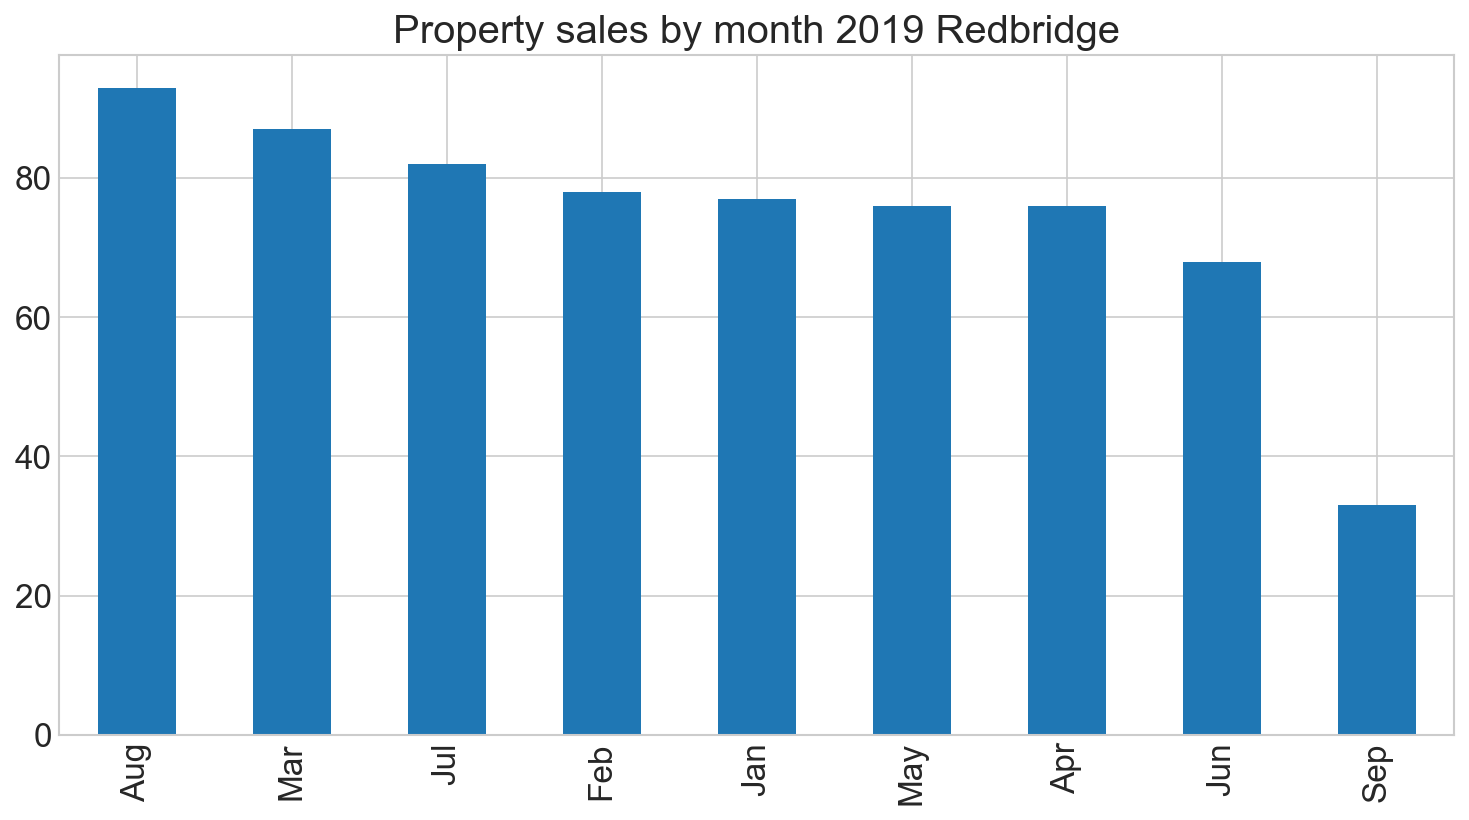

In [385]:
avg = filter_data(data, '2019-01-01', '2019-12-31')

bar_title = "Property sales by month 2019 {0}".format(area)
monthly_sales(avg).plot(x='date_of_transfer', kind='bar', title=bar_title)

print('Median price paid since 2019 = £ %d' % np.median(avg['price']))
print('Mean price paid since 2019 = £ %d' % np.mean(avg['price']))

In [386]:
df = filter_data(data, '2017-01-01', '2019-12-31')
twenty_percent = int(20/100 *len(df))

df_expensive = df.sort_values(by=['price'], ascending=False).head(twenty_percent)
df_expensive['cost'] = 'Expensive'


df_cheap = df.sort_values(by=['price'], ascending=True).head(twenty_percent)
df_cheap['cost'] = 'Cheap'


In [387]:
df = pd.concat([df_expensive, df_cheap], sort=False, ignore_index=True)
len(df)


1130

In [388]:
def plot_sales_price(df):
    # generate a new map latitude,longtitude
    latitude = query_latitude_longtitude(area)[0]
    longtitude = query_latitude_longtitude(area)[1]
    
    folium_map = folium.Map(location=[latitude ,longtitude],
                            zoom_start=13,
                            tiles="OpenStreetMap",
                            width='100%')

    # for each row in the data, add a cicle marker
    for index, row in df.iterrows():
                         
        popup_text = ''
                      
        # radius of circles
      
        if row["price"] >= 1000000:
            price = float((row["price"]/1000000))
            color="#8B0000" # drakred
            popup_text = "<br>Type:{} <br>Price:{}M"
            popup_text = popup_text.format(row["type"],price)           
        elif row["cost"] == 'Expensive':
            color="#008000" # 
            price = int((row["price"]/1000))
            popup_text = "<br>Type:{} <br>Price:{}K"
            popup_text = popup_text.format(row["type"],price)
        else:
            color="#0375B4" # 
            price = int((row["price"]/1000))
            popup_text = "<br>Type:{} <br>Price:{}K"
            popup_text = popup_text.format(row["type"],price)
        
        # add marker to the map
        folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=5,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

In [389]:
print("Expensive top 20% in green and dark red, dark red also represents houses prices over a million.")
print("Cheapest 20% in blue.")
plot_sales_price(df)   

Expensive top 20% in green and dark red, dark red also represents houses prices over a million.
Cheapest 20% in blue.


In [390]:
folium_map = plot_sales_price(df)   
folium_map.save(area+ ".html")

In [406]:
def heat_map(df,lat,lon):
    
    max_amount = float(for_map['price'].max())
    hmap = folium.Map(location=[latitude ,longtitude], zoom_start=13,  width='100%')

    hm_wide = HeatMap( list(zip(for_map.latitude.values, for_map.longitude.values, for_map.price.values)),
                       #min_opacity=0.2,
                       max_val=max_amount,
                       radius=17, blur=15, 
                       max_zoom=1, 
                     ).add_to(hmap)


    return hmap.add_child(hm_wide)
    
for_map =  filter_data(data, '2016-01-01', '2019-01-01')
latitude = query_latitude_longtitude(area)[0]
longtitude = query_latitude_longtitude(area)[1]

#heat_map(for_map,latitude,longtitude)

In [392]:
#folium_map =heat_map(for_map,latitude,longtitude)
#folium_map.save(area + "_heat_map.html")

Text(0.5, 1.0, 'Timeline of the Number of House Sales in Redbridge')

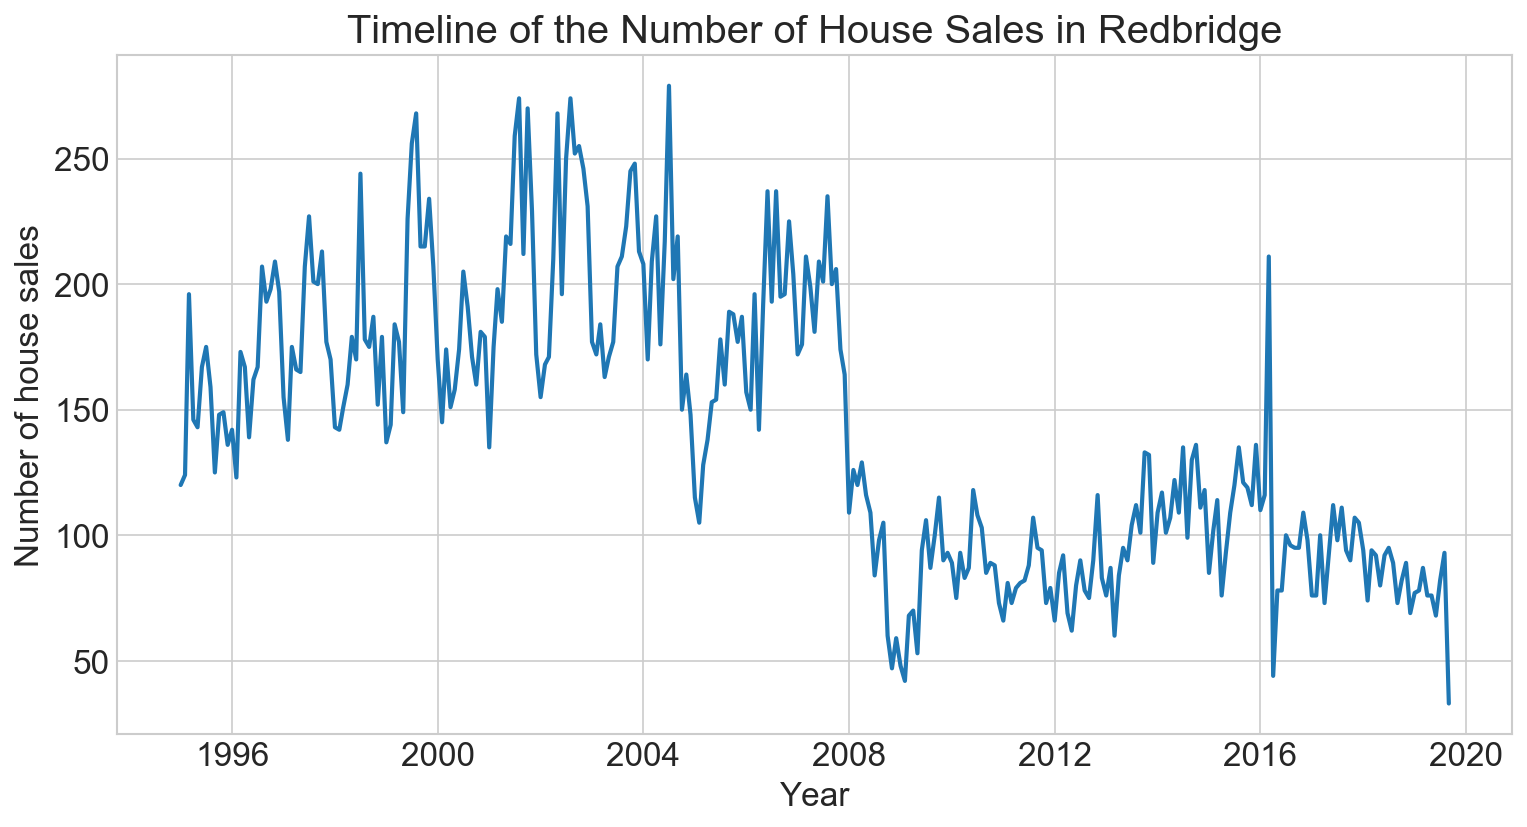

In [393]:
ts = data.groupby([(data['year']),(data['month'])])['transaction_unique_identifier'].count().reset_index()

ts['date'] = pd.to_datetime(ts.year.astype(str) + '-' + ts.month.astype(str))
 
fig, ax = plt.subplots()
ax.plot(ts['date'],ts['transaction_unique_identifier'])
plt.xlabel('Year')
plt.ylabel('Number of house sales')
ax.set_title('Timeline of the Number of House Sales in {0}'.format(area))
          


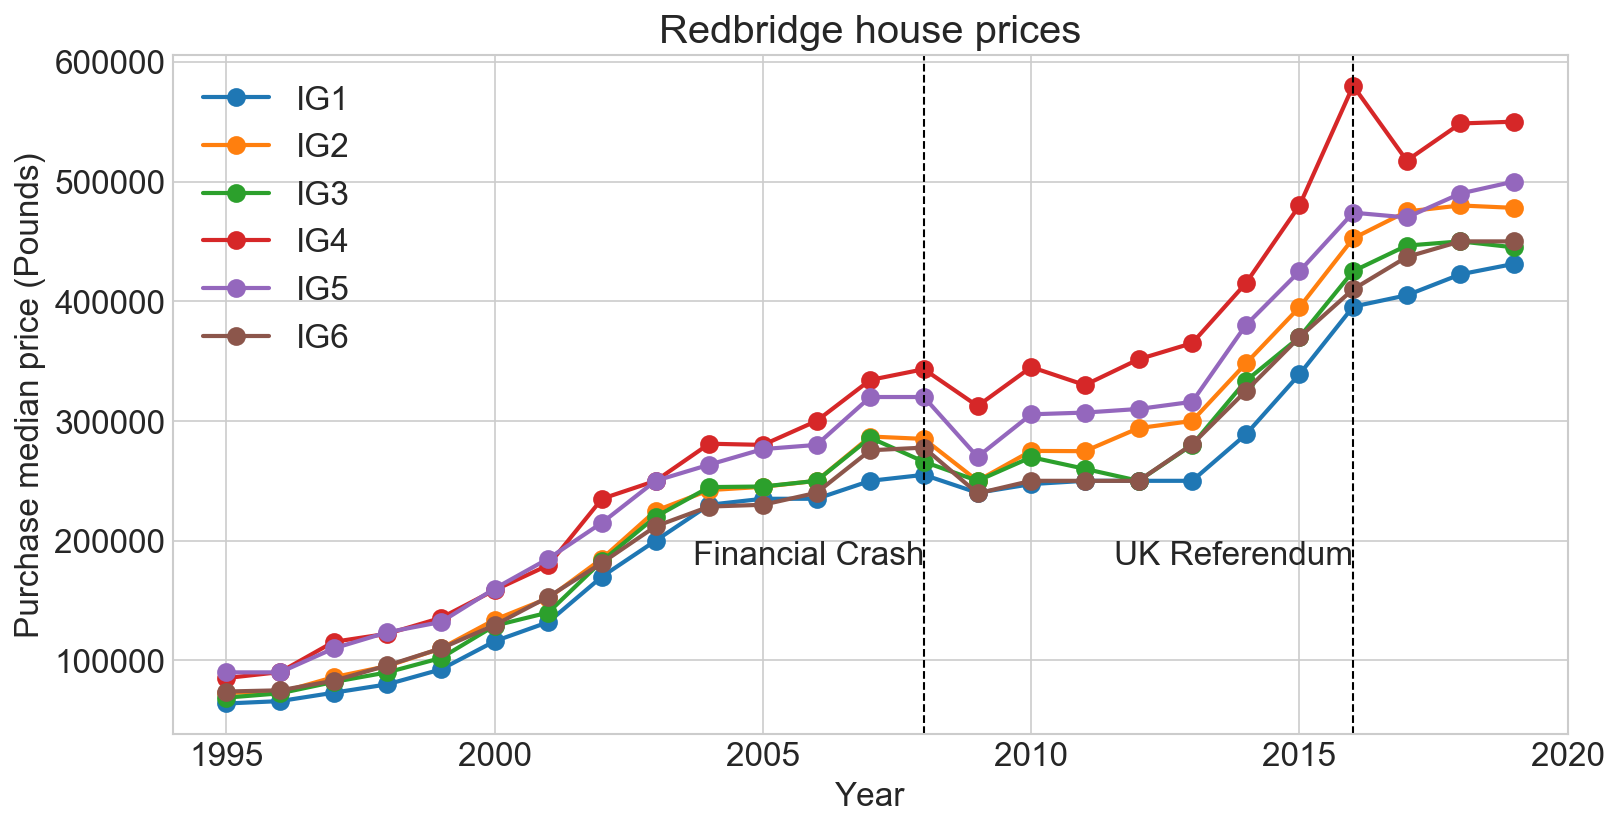

In [394]:
def get_median_price(data):
    return data.groupby(['year','outcode'])['price'].median().dropna().reset_index()

def get_by_postcode(data, postcode):
     return data[data.outcode == postcode]

def plot_by_postcode(data):
    ax = plt.gca()
    data.plot(kind='line',x='year',y='price',ax=ax,linewidth=2, marker='o', markersize=8)
    #plt.plot(year_mean, linewidth=2, marker='o', markersize=8)
    

[plot_by_postcode(get_by_postcode(get_median_price(data),pc))for pc in postcode]
plt.xlim(1994,2020)

#for code in postcode:
    # plot_by_postcode(get_by_postcode(get_median_price(data),code))

plt.legend(postcode, loc='upper left')
        
# gca stands for 'get current axis'
plt.text(2008,180000,'Financial Crash',horizontalalignment='right')
plt.text(2016,180000,'UK Referendum',horizontalalignment='right')
plt.xlabel('Year')
plt.ylabel('Purchase median price (Pounds)')
plt.title("{0} house prices".format(area))

plt.axvline(2008, color='k', linestyle='dashed', linewidth=1)
plt.axvline(2016, color='k', linestyle='dashed', linewidth=1)


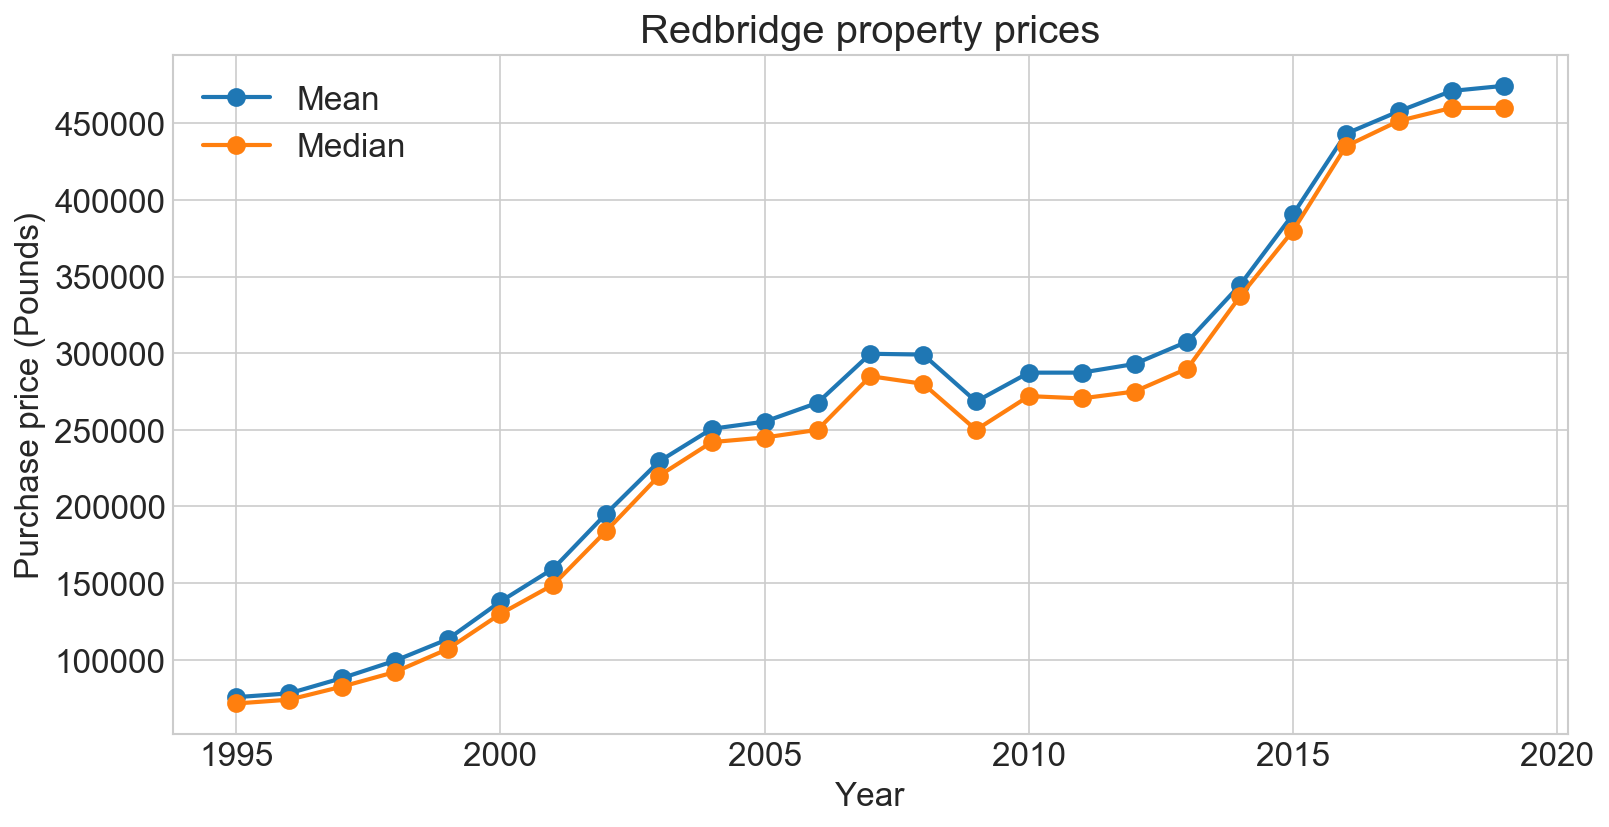

In [395]:
#plt.rcParams.update({'font.size': 8})

year_median = data['price'].groupby(data.year).aggregate(np.median)
year_mean = data['price'].groupby(data.year).aggregate(np.mean)
plt.plot(year_mean, linewidth=2, marker='o', markersize=8)
plt.plot(year_median, linewidth=2, marker='o', markersize=8)
plt.xlabel('Year')
plt.ylabel('Purchase price (Pounds)')
plt.title("{0} property prices".format(area))
plt.legend(['Mean', 'Median',], loc='upper left')
plt.show()

In [396]:
data = pd.merge(data, data_inflation, on='year', how='inner')


In [397]:
def percentage_change(df):
    df['price_change'] = (df.price - df.price.shift(1))/df.price * 100
    return df['price_change'] 


In [398]:
df = data.groupby(['year'])['price','inflation rate'].median().dropna().reset_index()
df.year = df.year.astype(int)
df = df.sort_values(['year'], ascending=[True])
df['price_change'] = percentage_change(df)

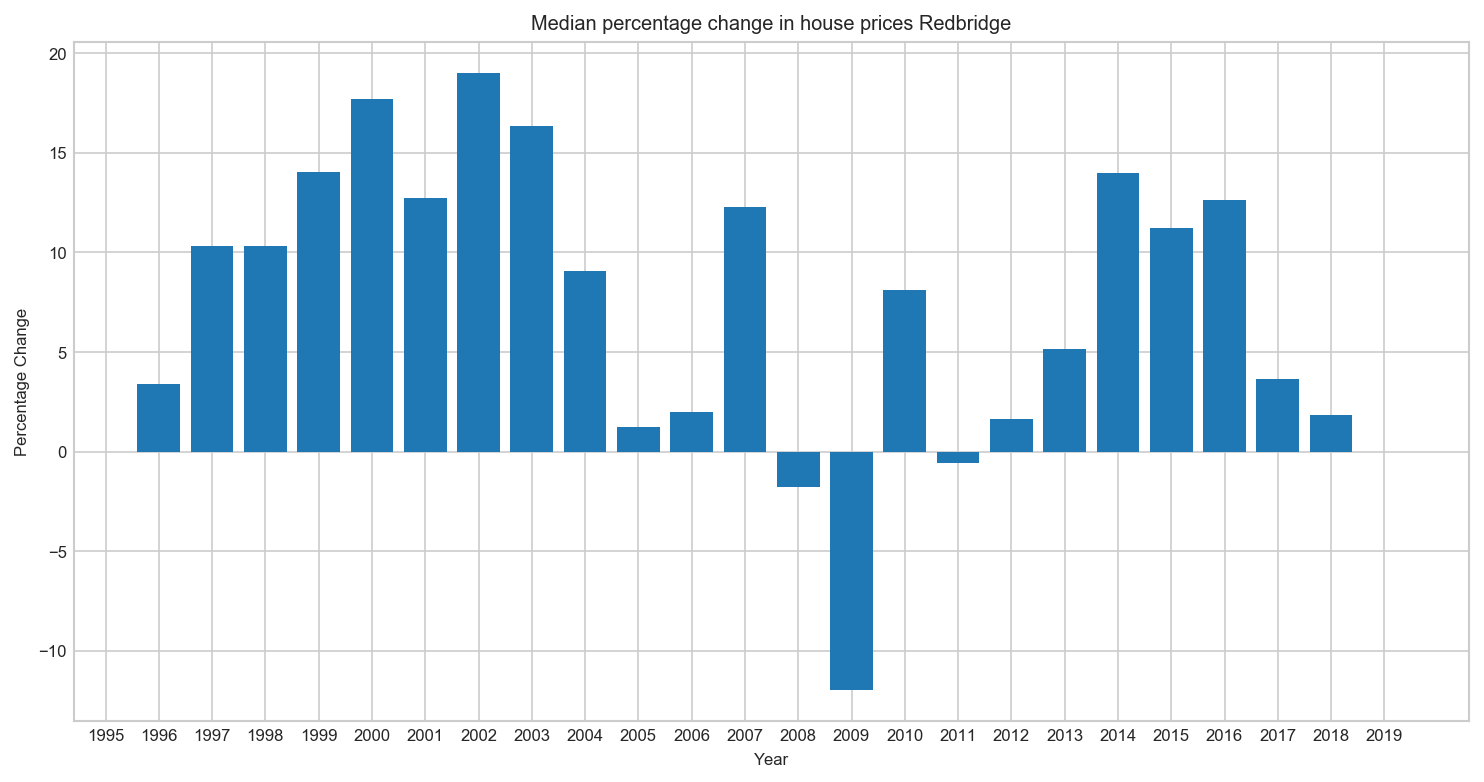

In [399]:
plt.rcParams.update({'font.size': 8})
objects = df['year'].unique()

y_pos = np.arange(len(objects))
performance = df['price_change']

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage Change')
plt.xlabel('Year')
plt.title('Median percentage change in house prices {0}'.format(area))
plt.show()

In [400]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [401]:
df['price_change'] = df['price_change'].replace('nan', np.nan).fillna(0)

df.style.applymap(color_negative_red)
#df.price_change.apply(lambda x : "{:,}".format(x))
# df['cost'].map('{:,}'.format)
#data

,year,price,inflation rate,price_change
0,1995,71500,3.46526,0
1,1996,74000,2.41414,3.37838
2,1997,82500,3.13745,10.303
3,1998,92000,3.4283,10.3261
4,1999,107000,1.54062,14.0187
5,2000,130000,2.95785,17.6923
6,2001,149000,1.77136,12.7517
7,2002,184000,1.6674,19.0217
8,2003,220000,2.89167,16.3636
9,2004,242000,2.97819,9.09091


In [402]:
df_turnover = filter_data(data, '2017-01-01', '2019-12-31')
#df[['Street']].count()
#df = df.groupby('Street').count()
df_turnover = df_turnover.groupby(['postcode'])['Street'].describe().dropna().reset_index()
rename_columns = {'top':'street','freq':'frequency'}
df_turnover = df_turnover.sort_values(by='count', ascending=False)
df_turnover = df_turnover.rename(index=str, columns=rename_columns)
df_turnover = df_turnover[['street','postcode','frequency']].head(10)
print('Top 10 turnover streets, since 2017')
df_turnover.reset_index(drop=True)


Top 10 turnover streets, since 2017


,street,postcode,frequency
0,HUGHES ROAD,IG6 2FP,26
1,MARINE CRESCENT,IG6 2FJ,25
2,REPTON GROVE,IG5 0RN,14
3,WOODBURY CRESCENT,IG5 0FF,12
4,FULLWELL AVENUE,IG5 0FA,11
5,PEAKETON AVENUE,IG4 5PG,10
6,WANSTEAD PARK ROAD,IG1 3TT,8
7,OAKHURST CLOSE,IG6 2LT,8
8,MOSSFORD LANE,IG6 2JA,8
9,TRELAWNEY ROAD,IG6 2NH,7


In [403]:
df_price = filter_data(data, '2017-01-01', '2019-12-31')
df_price = pd.DataFrame(df_price.groupby(['Street'])['price'].agg(['median','mean','count']).reset_index())
df_price = df_price.sort_values(by='median', ascending=False)
df_price = df_price.rename(index=str, columns={'Street':'street','count':'number_sold'})
df_price = df_price[['street','median','number_sold']]
df_price['median'] = df_price['median'].map('{:,}'.format)
print('Top 10 most expensive streets, since 2017')
df_price.reset_index(drop=True).head(10)


Top 10 most expensive streets, since 2017


,street,median,number_sold
0,HOLCOMBE ROAD,"1,375,000.0",3
1,DOUGLAS CLOSE,"950,000.0",1
2,HAZEL LANE,"840,000.0",3
3,BETHELL AVENUE,"837,500.0",2
4,PETERBOROUGH GARDENS,"805,000.0",1
5,CHELMSFORD GARDENS,"787,500.0",2
6,LORD AVENUE,"785,000.0",5
7,AMBER LANE,"750,000.0",1
8,SELBORNE ROAD,"740,000.0",5
9,EMPRESS AVENUE,"740,000.0",3


In [404]:
print('Top 10 cheapest streets, since 2017')
df_price.reset_index(drop=True).tail(10)

Top 10 cheapest streets, since 2017


,street,median,number_sold
632,DUNEDIN ROAD,"253,000.0",1
633,LYNTON CRESCENT,"252,000.0",1
634,HAWKESBURY CLOSE,"248,000.0",1
635,DE VERE GARDENS,"247,500.0",4
636,BENTLEY DRIVE,"225,000.0",1
637,OAKWOOD GARDENS,"215,000.0",1
638,BROADHURST AVENUE,"213,000.0",1
639,HUMPHREY CLOSE,"207,000.0",1
640,FALCONER ROAD,"198,050.0",2
641,CLANDON ROAD,"190,000.0",1
